# Import libraries

In [1]:
from platform import python_version

print(python_version())

3.8.18


In [2]:
# conda env list

In [3]:
# !pip install scikit-surprise

In [4]:
# from surprise import BaselineOnly
from surprise import NMF, SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import pandas as pd

import random
my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

from tqdm import tqdm
# from multiprocessing import Pool


Splitting the data using the *userfixed* method, where 80% of each user's data goes to training and the rest to testing set. Surprises split method is randomly. Their method is extended below.

In [5]:
from platform import python_version

print(python_version())

3.8.18


# Rating Data class 'userfixed' data split method.

In [6]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idxa = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    

# Data Import

In [7]:
# ls

In [8]:
# df = pd.read_csv('Data/ml-100k/udata.csv', 
#                  sep=";", header=0, engine="python")

# user = pd.read_csv('Data/ml-100k/uuser.csv', 
#                    sep=";", header=0, engine ="python")

# genre = pd.read_csv('Data/ml-100k/ugenre.csv', 
#                     sep=";", header=0, engine = "python")



df = pd.read_csv('./Data/ml-100k/u.data', 
                 sep="\t", header=None, engine="python", index_col=False,
                 names=['user', 'item', 'rating', 'timestamp'])

user = pd.read_csv('./Data/ml-100k/u.user', 
                   sep="|", header=None, engine ="python", 
                   names = ['id','age', 'gender', 'occupation', 'zipcode'])

genre = pd.read_csv('./Data/ml-100k/u.genre', 
                    sep="|", header=None, engine = "python", 
                    names = ['genre', 'id'])

In [9]:
# df.head()

In [10]:
# user.head()

In [11]:
# genre.head()

## Dimensionality Reduction - ncore

In [12]:
n_core = 5

In [13]:
f_name = 'f_%i_core'%n_core
f_name

'f_5_core'

In [14]:
# To reduce the dimensionality of the dataset,
# we will filter out rarely rated movies and rarely rating users

min_ratings = n_core
min_user_ratings = n_core

init_df = df
init_shp = df.shape[0]
filt_shp = 0.0

while True:

    filter_items = init_df['item'].value_counts() > min_ratings
    filter_items = filter_items[filter_items == True].index.tolist()

    filter_users = init_df['user'].value_counts() > min_user_ratings
    filter_users = filter_users[filter_users == True].index.tolist()

    filt_df = init_df[(init_df['item'].isin(filter_items)) & (init_df['user'].isin(filter_users))]

    print('The original data frame shape:\t{}'.format(init_df.shape))
    print('The new data frame shape:\t{}'.format(filt_df.shape))
    print()
    
    init_shp = init_df.shape[0]
    filt_shp = filt_df.shape[0]
    
    # print(init_shp, filt_shp)
    
    if (init_shp == filt_shp):
        break
    
    init_df = filt_df

    
#------------------------------------------------------------
'Updating the df to its filtered version'
'Now filt-df is called df.' 
df = filt_df
print(filt_df.shape)
print(df.head())

print()
print('#users: ', np.unique(df['user']).shape)
print('#items: ', np.unique(df['item']).shape)

The original data frame shape:	(100000, 4)
The new data frame shape:	(99032, 4)

The original data frame shape:	(99032, 4)
The new data frame shape:	(99032, 4)

(99032, 4)
   user  item  rating  timestamp
0   196   242       3  881250949
1   186   302       3  891717742
2    22   377       1  878887116
3   244    51       2  880606923
4   166   346       1  886397596

#users:  (943,)
#items:  (1298,)


### Saving the filtered rating data & re-reading it again

In [15]:
df.to_csv('./filtered_ml_%icore.csv'%n_core, sep=',', index=False)

In [16]:
df = pd.read_csv('./filtered_ml_%icore.csv'%n_core, sep=',')
print(df.shape)
df.head()

(99032, 4)


,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Data Preprocessing (pro & unpro)

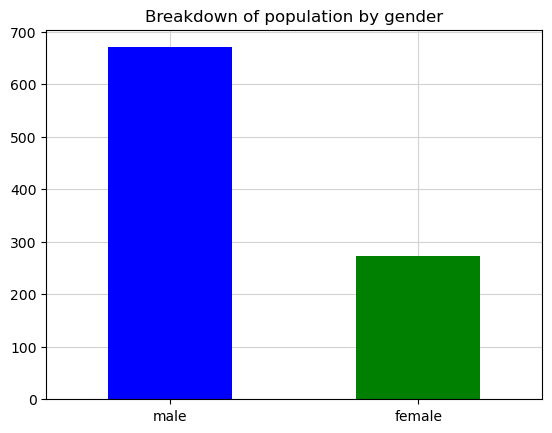

In [17]:
# Filtering the user.dat file based on the ncore process - not sure if we need this or not
user = user[user['id'].isin(np.unique(df['user']))]
user.shape


#  We consider "gender" as the sensitive attribute.
    # F is the protected value and M is the unprotected value.

#------------------------------------------------------------
'The protected and the unprotected'

user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i,'is_pro'] = 1
        
# user.head(3)

#------------------------------------------------------------
'preliminary stats'

breakbygender = pd.value_counts(user['is_pro'].values,sort=False)
# print(breakbygender,'\n')

ax = breakbygender.plot(kind='bar', title='Breakdown of population by gender', color=['b', 'g'])
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1])
ax.set_xticklabels(['male', 'female'], rotation='horizontal')
ax.set_axisbelow(True)

#------------------------------------------------------------



In [18]:
breakbygender

0    670
1    273
Name: count, dtype: int64

### original ratio of women to men 

In [19]:
breakbygender.get(1) / (breakbygender.get(0) + breakbygender.get(1))

0.28950159066808057

In [20]:
breakbygender.get(1) / breakbygender.get(0)

0.40746268656716417

### number of ratings by m & w in dataset (whole)

In [21]:
user[(user['id'] == 186) & (user['gender'] == 'F')]

,id,age,gender,occupation,zipcode,is_pro
185,186,39,F,executive,00000,1


In [22]:
np.any((user['id'] == 186) & (user['gender'] == 'F'))

True

In [23]:
f_rating_count = 0 
m_rating_count = 0

for a, b in df.groupby('user'):
    if np.any((user['id'] == a) & (user['gender'] == 'F')):
        f_rating_count += len(b)
    else:
        m_rating_count += len(b)
        
print(f_rating_count)
print(m_rating_count)
        

25385
73647


In [24]:
# probability oof rating by a woman
f_rating_count/(f_rating_count+m_rating_count)


0.2563312868567736

In [25]:
# user.head()

## Rating Distribution 

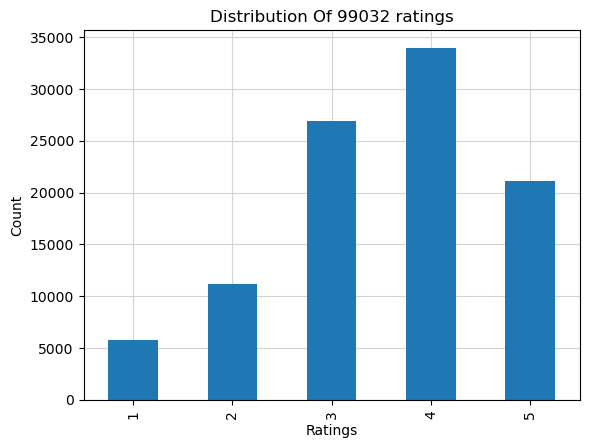

In [26]:
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
# ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)


In [27]:
data

rating
1     5825
2    11222
3    26895
4    33983
5    21107
Name: count, dtype: int64

In [28]:
# df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]['rating']

### Rating distribution by gender

Text(0, 0.5, 'Count')

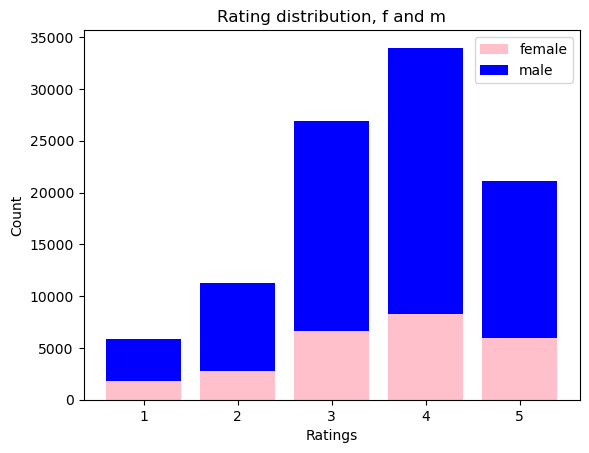

In [29]:
data_f = df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]['rating'].value_counts().sort_index(ascending=False)
data_m = df[(df['user']).isin(user.loc[user['gender'] == 'M', 'id'])]['rating'].value_counts().sort_index(ascending=False)


# ax = data_f.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))
# ax = data_m.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))

plt.bar(data_f.index, data_f, color='pink')
plt.bar(data_m.index, data_m, bottom=data_f, color='b')

plt.title('Rating distribution, f and m')
plt.legend(['female', 'male'])
# # plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')
# plt.grid(color='lightgray', which='major')
# plt.show()


In [30]:
data_f

rating
5    5957
4    8256
3    6678
2    2726
1    1768
Name: count, dtype: int64

In [31]:
data_m

rating
5    15150
4    25727
3    20217
2     8496
1     4057
Name: count, dtype: int64

In [32]:
data_f / (data_f + data_m)

rating
5    0.282229
4    0.242945
3    0.248299
2    0.242916
1    0.303519
Name: count, dtype: float64

In [33]:
data_m / (data_f + data_m)

rating
5    0.717771
4    0.757055
3    0.751701
2    0.757084
1    0.696481
Name: count, dtype: float64

70% of the ratings belong to men approximately. Their view probably affects the general view.

### Ratings Distribution By Item

Text(0, 0.5, 'Count')

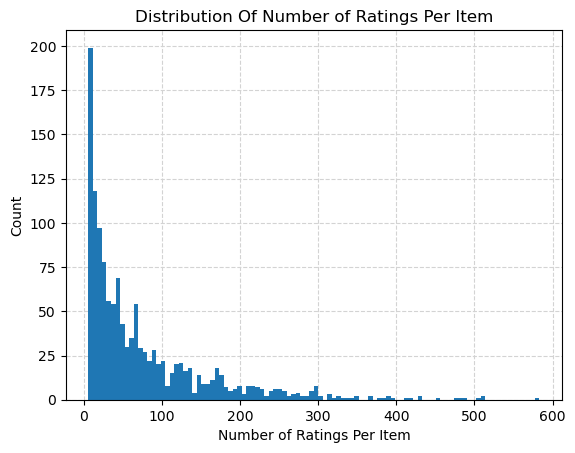

In [34]:
# Number of ratings per movie
data = df.groupby('item')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per Item', bins=100)
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per Item')
ax.set_ylabel('Count')


#### By gender

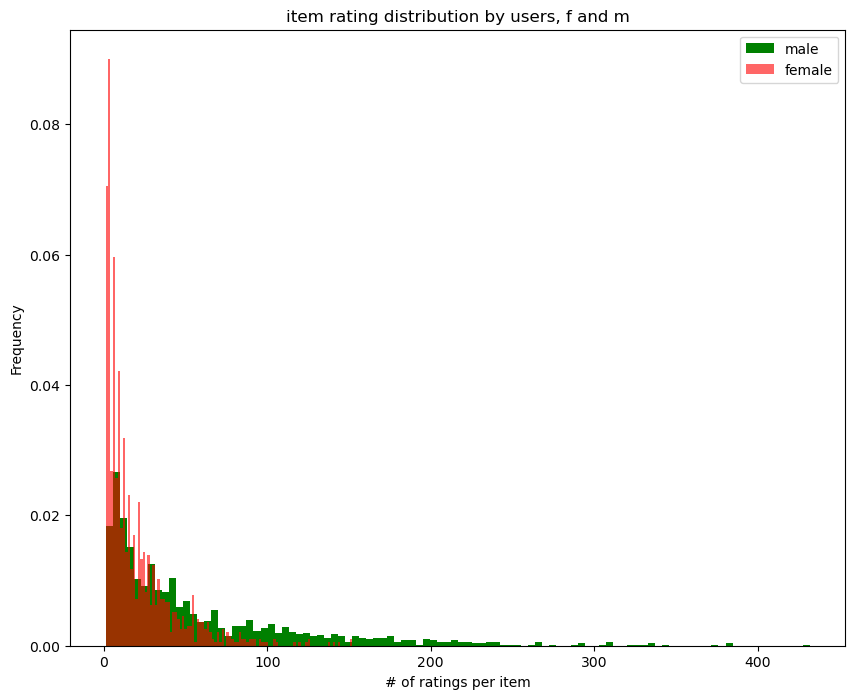

In [35]:
data_f = df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])].groupby('item')['rating'].count()
data_m = df[(df['user']).isin(user.loc[user['gender'] == 'M', 'id'])].groupby('item')['rating'].count()


#Stack the data
plt.figure(figsize=(10,8))
# plt.hist([data_f, data_m], stacked=True, density=True)
# ax = data_m.plot.hist(bins=100, label='male', density=1, color='green')
# ax = data_f.plot.hist(bins=100, label='female', alpha=0.6,density=1, color='red')
ax = data_m.plot.hist(bins=100, label='male', density=1, color='green')
ax = data_f.plot.hist(bins=100, label='female', alpha=0.6,density=1, color='red')


ax.set_title('item rating distribution by users, f and m')
ax.set_xlabel('# of ratings per item')
ax.legend()
plt.show()


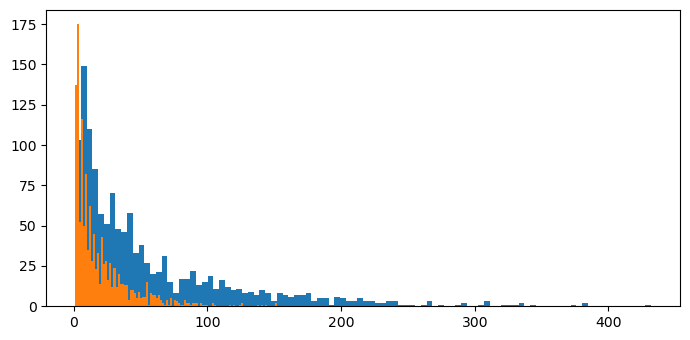

In [36]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
# a = np.random.random(100) * 0.5
# b = 1 - np.random.normal(size=100) * 0.1
bins = 100
b = np.histogram(np.hstack((data_f, data_m)), bins=bins)[1]
plt.hist(data_m, bins)
plt.hist(data_f, bins) # edgecolor='black'

plt.show()

- women have less ratings than men in general
- the long tail is shorter (but probably the controvertial items)
- their ratings are more focused on the popular items
- women's ratings of more popular items are more while men's ratings are more diverse and on more items.
    - so then shouldn't women receive good ratings because they are close to the majority of users?

- @INSIGHT: many of the items that are removed actually were rated by women! wth! we have many cold start users that are women! 
- all the users have at least 20 ratings, but after the ncore, some of them are removed. in the long tail there are items that are rated by men and women but are removed after the ncore. This could exacerbate the accuracy imbalance.
- we should try the data as is as well.
- there are some items that are only rated by men or women! specially in the long tail.


#### are cold start users more women or men?

In [37]:
# c_strt_usr = []
# c = 0
# exp = pd.read_csv('Data/ml-100k/udata.csv', sep=";", header=0, engine="python")
# for a, b in exp.groupby('user'):
# #     print(a, len(b))
#     if len(b) < 24:
#         c+=1
#         c_strt_usr.append(dataset.user_to_iid[str(a)])

# # print (c_strt_usr, c)
# print(c)

In [38]:
# c_pro = 0
# c_unpro = 0
# for i in c_strt_usr:
#     if i in pro_users_index:
#         c_pro+= 1
#     else:
#         c_unpro+=1
        
# print(len(c_strt_usr), 'women:', c_pro, 'men:', c_unpro)
    

- we have some nan values below

In [39]:
ratings_f_m = pd.DataFrame([data_f,data_m])
ratings_f_m

item,1,2,3,4,5,6,7,8,9,10,...,587,976,1151,1202,1205,1314,1449,1456,1512,1524
rating,119.0,19.0,16.0,45.0,22.0,5.0,82.0,60.0,83.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,333.0,112.0,74.0,164.0,64.0,21.0,310.0,159.0,216.0,69.0,...,14.0,12.0,7.0,8.0,6.0,11.0,8.0,7.0,6.0,8.0


In [40]:
# we have this many items, so the length is fine
ratings_f_m.shape

(2, 1298)

### Ratings Distribution By User

Text(0, 0.5, 'Count')

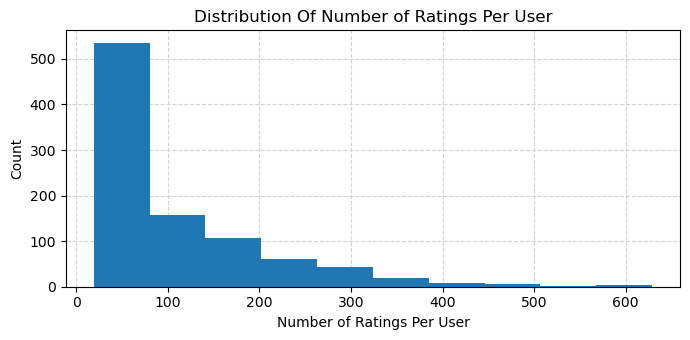

In [41]:
data = df.groupby('user')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per User')
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per User')
ax.set_ylabel('Count')

# RatingDataset() class

To load a dataset from a pandas dataframe, we will use the load_from_df() method The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

## Split into train and test

Note that this class is based on the data class in Surprise but it is not the same or connected to it whatsoever.

In [44]:
# data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

dataset = RatingDataset()
data_fn = './filtered_ml_%icore.csv'%n_core
dataset.read_from_file(data_fn, skip_lines=1, line_format='user item rating', sep=',')

print('# users', dataset.user_n)
print('# items', dataset.item_n)

# user_tests is the test_mat
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)

# ir = the pair of (item, rating)
# ir = user_ratings[user_iid][ir_idx]

user_ratings = dataset.list_users_ratings(dataset.rating_mat)
print(dataset.rating_mat.shape)

# users 943
# items 1298

Number of users with some items in testset: 943
Number of ratings in trainset: 79591 	 Number of ratings in testset: 19441

(943, 1298)


In [45]:
# # raw id to index
# print(dataset.user_to_iid['186'], type(dataset.user_to_iid['186']))

# # index to raw id
# print(dataset.user_to_ID[452], type(dataset.user_to_ID[452]))

## Train & Test to Dataframes

### train set

In [46]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]
# train_df = pd.DataFrame(columns = ['item','rating'])

tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    
train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']


print('unique users',np.unique(train_df['user']).shape)
print('unique items',np.unique(train_df['item']).shape)
print(train_df.shape)

train_df.head()

unique users (943,)
unique items (1298,)
(79591, 3)


,user,item,rating
0,0,42,4.0
1,0,57,3.0
2,0,83,3.0
3,0,91,5.0
4,0,106,4.0


### test set

In [47]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']

print('users',np.unique(test_df['user']).shape)
print('items',np.unique(test_df['item']).shape)
print(test_df.shape)

test_df.head()

users (943,)
items (1256,)
(19441, 3)


,user,item,rating
0,0,68,1.0
1,0,710,3.0
2,0,906,1.0
3,0,622,2.0
4,0,754,1.0


In [48]:
test_df.shape[0] + train_df.shape[0]

99032

## rating distribution of  training set and test set

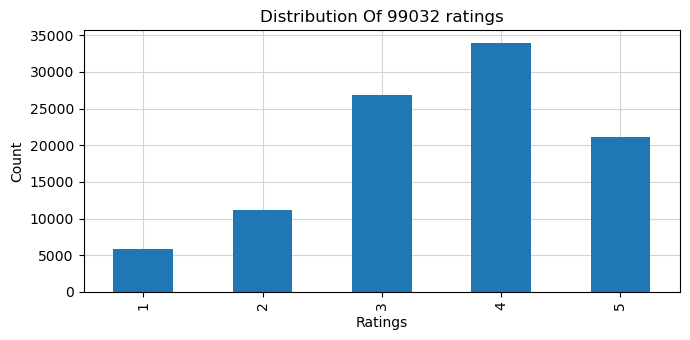

In [49]:
# all_d = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates(keep=False)
# print(all_d.shape)
# df.equals(all_d)b
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)

Index([5.0, 4.0, 3.0, 2.0, 1.0], dtype='float64', name='rating')
Index([5.0, 4.0, 3.0, 2.0, 1.0], dtype='float64', name='rating')


Text(0, 0.5, 'Count')

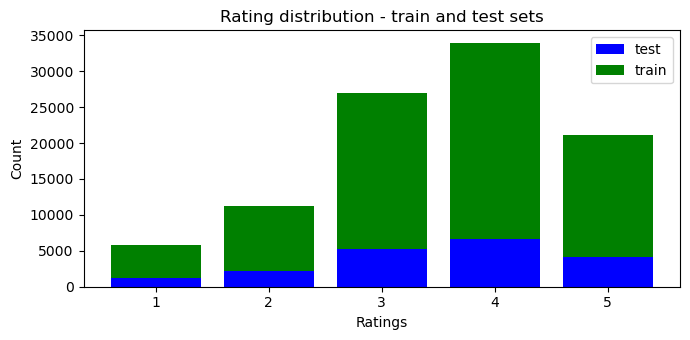

In [50]:
data_tr = train_df['rating'].value_counts().sort_index(ascending=False)
data_ts = test_df['rating'].value_counts().sort_index(ascending=False)

print(data_tr.index)
print(data_ts.index)

plt.bar(data_ts.index, data_ts, color='b')
plt.bar(data_tr.index, data_tr, bottom=data_ts, color='g')

plt.title('Rating distribution - train and test sets')
plt.legend(['test', 'train'])
# plt.grid(True, color='lightgray', linestyle='-')
# plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')

## Pro and Unpro - id to iid (ID to Index)

In [51]:
user.dtypes
# turn user id into string so you can retrieve int iid

id             int64
age            int64
gender        object
occupation    object
zipcode       object
is_pro         int64
dtype: object

In [52]:
'pro & unpro data structures'

# global pro_users_id
# global unpro_users_id

# pro_users_id = []
# unpro_users_id = []

global pro_users_index
global unpro_users_index

pro_users_index = []
unpro_users_index = []


# initializing a column
# this is inner id or index
user['iid'] = 0

for i, row in user[['id', 'is_pro']].iterrows():
    
    # user id to inner_id (index)
    u_index = dataset.user_to_iid[str(row['id'])]
    # print(row['id'], u_index, dataset.user_to_ID[u_index])
    
    # just add the inner id (index) to the user dataframe
    user.loc[user['id']==row['id'], 'iid'] = u_index
    
    
    if row['is_pro'] == 1:
        # pro_users_id.append(row['id'])
        pro_users_index.append(u_index)
    
    else:
        # unpro_users_id.append(row['id'])
        unpro_users_index.append(u_index)  


print('protected users', len(pro_users_index))
print('unprotected users', len(unpro_users_index))
print()

user.head(5)


protected users 273
unprotected users 670



,id,age,gender,occupation,zipcode,is_pro,iid
0,1,24,M,technician,85711,0,396
1,2,53,F,other,94043,1,451
2,3,23,M,writer,32067,0,529
3,4,24,M,technician,43537,0,70
4,5,33,F,other,15213,1,365


### iid 2 gender & reverse

In [53]:
# dictionary of iid and gender

iid_to_gender = dict(zip(user.iid, user.gender))
# gender_to_iid = dict(zip(user.gender, user.iid))

id_to_gender = dict(zip(user.id, user.gender))
# gender_to_id = dict(zip(user.gender, user.id))


### Deepcopy train & test w gender info

In [54]:
#copy training set
# it won't affect train_df, only the copy has an extra column
train_df_cp = train_df.copy(deep=True)
test_df_cp = test_df.copy(deep=True)


train_df_cp['gender'] = train_df['user'].map(iid_to_gender)
test_df_cp['gender'] = test_df['user'].map(iid_to_gender)

In [55]:
# train_df_cp.head()

### rating , gender, count (tr, ts)

In [56]:
m_f_cnt = []
for a, b in train_df_cp.groupby(['rating', 'gender']):
    m_f_cnt.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt, '\n') 
print()

m_f_cnt_ts = []
for a, b in test_df_cp.groupby(['rating', 'gender']):
    m_f_cnt_ts.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt_ts)

(1.0, 'F') 1434
(1.0, 'M') 3237
(2.0, 'F') 2185
(2.0, 'M') 6804
(3.0, 'F') 5387
(3.0, 'M') 16276
(4.0, 'F') 6628
(4.0, 'M') 20712
(5.0, 'F') 4781
(5.0, 'M') 12147

(1.0, 'F') 334
(1.0, 'M') 820
(2.0, 'F') 541
(2.0, 'M') 1692
(3.0, 'F') 1291
(3.0, 'M') 3941
(4.0, 'F') 1628
(4.0, 'M') 5015
(5.0, 'F') 1176
(5.0, 'M') 3003


In [57]:
np.array(m_f_cnt)[::2, :]

array([['1.0', 'F', '1434'],
       ['2.0', 'F', '2185'],
       ['3.0', 'F', '5387'],
       ['4.0', 'F', '6628'],
       ['5.0', 'F', '4781']], dtype='<U32')

In [58]:
np.array(m_f_cnt)[::-2, :][::-1]

array([['1.0', 'M', '3237'],
       ['2.0', 'M', '6804'],
       ['3.0', 'M', '16276'],
       ['4.0', 'M', '20712'],
       ['5.0', 'M', '12147']], dtype='<U32')

### plot ratings sep by gender and tr/ts

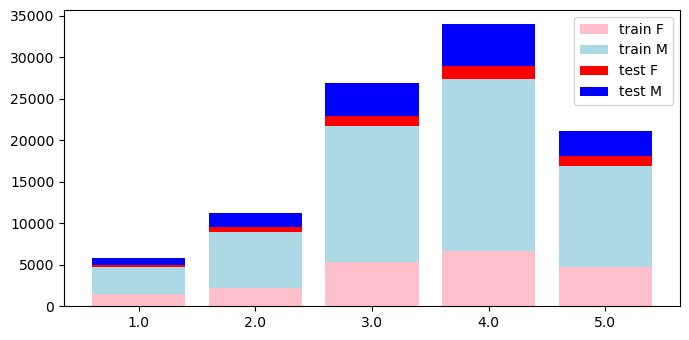

In [59]:


# female train
f_tr = np.array(m_f_cnt)[::2, :]
plt.bar(f_tr[:, 0], f_tr[:, 2].astype(int), color='pink', label='train F')

m_tr = np.array(m_f_cnt)[::-2, :][::-1]
plt.bar(m_tr[:, 0], m_tr[:, 2].astype(int),
        bottom = f_tr[:, 2].astype(int), color='lightblue', label='train M')



# test set
f_ts = np.array(m_f_cnt_ts)[::2, :]
plt.bar(f_ts[:, 0], f_ts[:, 2].astype(int),
        bottom=f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int), 
        color='red', label='test F')

m_ts = np.array(m_f_cnt_ts)[::-2, :][::-1]
plt.bar(m_ts[:, 0], m_ts[:, 2].astype(int),
        bottom = f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int) + f_ts[:, 2].astype(int),
        color='blue', label='test M')


plt.legend()

### ratio of women to men in train and text

In [60]:

print('training set')
# train f
p_f_r = f_tr[:, 2].astype(int) / (f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int))
p_m_r = m_tr[:, 2].astype(int) / (f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int))

print(('prob Fem given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' +
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_f_r))
print()
print(('prob Mal given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_m_r))
# print(p_f_r + p_m_r)



print('\n\ntest set')
p_f_r_ts = f_ts[:, 2].astype(int) / (f_ts[:, 2].astype(int) + m_ts[:, 2].astype(int))
p_m_r_ts = m_ts[:, 2].astype(int) / (f_ts[:, 2].astype(int) + m_ts[:, 2].astype(int))

print(('prob Fem given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_f_r_ts))
print()
print(('prob Mal given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_m_r_ts))



training set
prob Fem given rating 	 one 0.30700064226075785 
			 two 0.24307486928468128 
			 three 0.24867285232885566 
			 four 0.24242867593269934 
			 five 0.2824314744801512

prob Mal given rating 	 one 0.6929993577392421 
			 two 0.7569251307153188 
			 three 0.7513271476711444 
			 four 0.7575713240673007 
			 five 0.7175685255198487


test set
prob Fem given rating 	 one 0.28942807625649913 
			 two 0.24227496641289745 
			 three 0.24675076452599387 
			 four 0.24506999849465602 
			 five 0.2814070351758794

prob Mal given rating 	 one 0.7105719237435009 
			 two 0.7577250335871025 
			 three 0.7532492354740061 
			 four 0.754930001505344 
			 five 0.7185929648241206


The ratio oof men and women in train and test is similar. The probability of being a women given you have rated an item one is 30% which is higher than other ratings.

# Q: What is this? for the ratios of ratings?

### rating cnt, avg, median of ratings for m and f (TRAINING SET)

- if the distribution is symmetrical mean and meadian will be the same
- if the dist is skewed to the right (positively skewed, or the right side is thinner), it means that smaller numbers are more, then the median becomes one fo those small numbers. Since mean changes when when a few big numbers are added, mean becomes bigger. So median will be smaller than the mean.
- if it is skewed to the left or negatively skewed, the big numbers are more and so the median is a big number. the mean changes and becomes smaller as small numbers are added to it, so the median becomes bigger than the mean.
- so if median > mean, the dist is left skewed, so higher ratings are more common.
- if the median < mean, the dist is right skewed, so lower ratings are more common.
- is the difference statistically significant or not?

In [61]:

# for a, b in train_df_cp.groupby(['item', 'gender']):
    
#     print(a, b, '\n', b['rating'].median(), b['rating'].mean())
    
#     if b['rating'].median() > b['rating'].mean():
#         print('left skewed. higher ratings are more common.\n')
        
#     elif b['rating'].median() < b['rating'].mean():
#         print('right skewed. lower ratings are more common.\n')
    
#     else:
#         print('symmetrical. ratings follow a symmetrical normal dist\n')
        

#### train

In [62]:
# training set
# this is calcualted based on the training set only


# a dictionary of the number of ratings an item has received from men and women separately
# a dictionary of median and avg of rating of men & women on an item
item_f_m_cnt_dic = {} 


# starting from here, in case an item is not rated by one gender
for item in list(np.unique(train_df_cp.item)):
    item_f_m_cnt_dic[item] = {'F_c':0., 'M_c':0., 'F_med':0., 'F_avg':0.,'M_med':0., 'M_avg':0.} 

    
for a, b in train_df_cp.groupby(['item', 'gender']):
    
    # how many ratings, rating count
    item_f_m_cnt_dic[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_f_m_cnt_dic[a[0]][a[1]+'_med'] += b['rating'].median()
    item_f_m_cnt_dic[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_f_m_cnt = pd.DataFrame.from_dict(item_f_m_cnt_dic, orient='index').reset_index()
item_f_m_cnt.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_f_m_cnt.shape)
item_f_m_cnt.head()



(1298, 7)


,item_iid,F_c,M_c,F_med,F_avg,M_med,M_avg
0,0,11.0,51.0,4.0,3.545455,4.0,4.235294
1,1,22.0,43.0,4.0,4.136364,4.0,3.906977
2,2,75.0,190.0,4.0,3.666667,4.0,3.531579
3,3,14.0,28.0,3.0,3.000000,3.0,3.428571
4,4,13.0,31.0,4.0,3.846154,4.0,3.903226


#### test

In [63]:
# a dictionary of the number of ratings an item has received from men and women separately
# a dictionary of median and avg of rating of men & women on an item
item_f_m_cnt_dic_ts = {} 


# starting from here, in case an item is not rated by one gender
for item in list(np.unique(test_df_cp.item)):
    item_f_m_cnt_dic_ts[item] = {'F_c':0., 'M_c':0., 'F_med':0., 'F_avg':0.,'M_med':0., 'M_avg':0.} 

    
for a, b in test_df_cp.groupby(['item', 'gender']):
    
    # how many ratings, rating count
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_med'] += b['rating'].median()
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_f_m_cnt_ts = pd.DataFrame.from_dict(item_f_m_cnt_dic_ts, orient='index').reset_index()
item_f_m_cnt_ts.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_f_m_cnt_ts.shape)
item_f_m_cnt_ts.head()



(1256, 7)


,item_iid,F_c,M_c,F_med,F_avg,M_med,M_avg
0,0,3.0,15.0,4.0,3.666667,4.0,4.133333
1,1,2.0,14.0,3.5,3.500000,4.0,4.214286
2,2,18.0,43.0,4.0,4.111111,4.0,3.813953
3,3,0.0,8.0,0.0,0.000000,3.0,3.000000
4,4,4.0,8.0,4.5,4.500000,4.0,4.375000


- NOTE: if there zeros it only means that there were not any ratings! there are no ratings of zero!
- keep that in mind while doing the comparisions!

# Consumer-Side Fairness Metrics

note that iid here means item-id not inner-id

- 0: uid,    
- 1: iid,    
- 2:r_ui,    
- 3: est


- g: disadvantaged,    
- -g: advantaged

## Common Functions 

### Average Score

In [64]:

def avg_score(df_i, itemid, users, est=False): 
    if est:
        pred_type = 'est'
    else:
        pred_type = 'r_ui'
        
    f_df = df_i.loc[(df_i['uid']).isin(users), pred_type]
    
    return f_df.mean()

### Separate Preds for Pro & Unpro

In [65]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index
        if row.uid in pro_users_index:
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

### Pro & Upro Counts

In [66]:
#  not sure if I use this function at all!
def pro_unpro_count(preds):
    
    pros= []
    unpros =[]
    
    for row in preds:
        if row.uid in pro_users_index:
            pros.append(row.uid)
        else:
            unpros.append(row.uid)
            
    return np.unique(pros), np.unique(unpros)

### Item Eligibility (for c-fairness metrics)

- ISSUE: if an item is not rated by a group, the average rating of that group will be NaN as well as the final output.

To avoid this issue, we calculate the consumer-side fairness metrics over items that were rated by both groups (Pro & Unpro).

- NOTE: Therefore all the metrics below are calcualted over the common items.

In [67]:
def is_i_eligible(item_df):
    
    # if there is only one rating, return False
    cond_a = len(item_df) >= 2
    
    #check here: pro_users_index, is item_df['uid] == item_df['uid'].tolist() ?
    if cond_a:
        # if this item has ratings from both the protected and unprotected user groups
        cond_b = np.any(np.any((item_df['uid']).isin(pro_users_index)) and
                       np.any((item_df['uid']).isin(unpro_users_index)))
        return cond_b
    
    return False

## Value Fairness

In [68]:
def value_unfairness(p_df):
    
    '''
    value unfairness, measures inconsistency in signed estimation error across the user types
    
    Value unfairness occurs when one class of user is consistently given higher or lower predictions
    than their true preferences. If the errors in prediction are evenly balanced between overestimation
    and underestimation or if both classes of users have the same direction and magnitude of error, the
    value unfairness becomes small. Value unfairness becomes large when predictions for one class
    are consistently overestimated and predictions for the other class are consistently underestimated.
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users_index, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users_index, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users_index, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users_index, est=False)
        
        sum_err += abs((e_g_y - e_g_r) - (e_ng_y - e_ng_r))
    
    # if non of the items had any ratings. it's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'
        
    return sum_err/np.unique(p_df['iid']).size

In [69]:
print('# of ratings', len(df['rating'].tolist()))

# of ratings 99032


In [70]:
# value_unfairness(pd.DataFrame(predictions_al_p))

## Nonparity

In [71]:
def non_parity(p_df):
    
    '''
    nonparity measure based on the regularization term introduced by Kamishima et al. 
    can be computed as the absolute difference between the overall average ratings of disadvantaged users 
    and those of advantaged users.
    '''
    e_g_y = p_df.loc[(p_df['uid']).isin(pro_users_index), 'est'].mean()
    e_ng_y = p_df.loc[(p_df['uid']).isin(unpro_users_index), 'est'].mean()
    
    return abs(e_g_y - e_ng_y)

# Active Learning

### number of iterations/epocs

In [72]:
train_df.shape

(79591, 3)

### item_ratings

-  a dictionary of item iid and the (user_iid, rating)s

In [73]:
# item ratings
# a dictionary of item iid and the (user_iid, rating)

# item_ratings = dataset.list_items_ratings(dataset.rating_mat) 
item_ratings = dataset.list_items_ratings(train_mat)

# print(len(item_ratings[3]))
print(len(item_ratings))


1298


In [74]:
dataset.item_n

1298

In [75]:
range(dataset.item_n)

range(0, 1298)

## Attention-based Popularity

Attention-based. This group of strategies focus on selecting the
items that have received the highest “attention” among the
users. Such items are likely to be known by the users, and
therefore they can be rated by them. Hence, these strategies
usually add a lot of ratings. These strategies are
simple and easy to implement and they were introduced
in the initial attempts to solve the cold start problem in
collaborative filtering. They are considered as baseline
strategies.

Popularity: selects the most popular items, i.e., those
with the highest number of ratings. It is very likely that the
users are able to rate these items and consequently the
size of the rating dataset can be increased. However,
popular items are typically widely liked by the users.
Therefore, their ratings usually bring little information
to the system. Moreover, this strategy may cause the
*prefix bias*, i.e., the system trained with ratings for
popular items tend also to recommend these popular
items, making them even more popular.

### Order the items in the training set based on their popularity

In [76]:
# based on the training set
item_pop_df = pd.DataFrame(train_df.groupby('item')['rating'].count()).sort_values(by='rating', 
                                                                                    ascending=False).reset_index()

item_pop_df.columns = ['item_iid','popularity']

print (item_pop_df.shape)

item_pop_df.head()

(1298, 2)


,item_iid,popularity
0,130,482
1,661,407
2,460,407
3,326,405
4,266,394


### Sorting the dataset based on the item popularity

In [77]:
# computing the item counts
item_pop_df = []
# pd.DataFrame(columns=['item_iid','popularity'])

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
    item_pop_df.append((item_iid,len(item_ratings[item_iid]))) 
    
item_pop_df = pd.DataFrame(item_pop_df, columns=['item_iid','popularity'])
item_pop_df.sort_values(by='popularity', ascending=False, ignore_index=True, inplace=True)

print(item_pop_df.head())
# to see if this was equal to the previous way of creating this dataframe
# (np.array(item_pop_df) == np.array(item_pop_df)).all()

print(item_pop_df.shape)

   item_iid  popularity
0       130         482
1       661         407
2       460         407
3       326         405
4       266         394
(1298, 2)


## Attention-based Square(Popularity) * Variance

### Normalized Popularity 

In [78]:
# normalize popularity scores

item_pop_df['norm_pop'] = 0

min_pop = item_pop_df['popularity'].tolist()[-1]
max_pop = item_pop_df['popularity'].tolist()[0]

for inx, row in item_pop_df.iterrows():
    item_pop_df.loc[inx, 'norm_pop'] = ((row['popularity'] - min_pop) / (max_pop - min_pop))
    
item_pop_df.head()


,item_iid,popularity,norm_pop
0,130,482,1.000000
1,661,407,0.843424
2,460,407,0.843424
3,326,405,0.839248
4,266,394,0.816284


In [79]:
print (item_pop_df.shape)

(1298, 3)


### Item Sqrt(norm pop) * Variance

- note that the calcualtion of variance in numpy and dataframe isn't the same

- Note: sometimes some of these items end up with no ratings and this shows an error!

In [80]:
# computing the item variance
item_var_df = []
#

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
    item_var_df.append((item_iid, np.array(item_ratings[item_iid])[:,1].var(),
                        (np.array(item_ratings[item_iid])[:,1].var()) * np.sqrt(item_pop_df.loc[item_pop_df['item_iid'] == item_iid,'norm_pop'].values[0])))


item_var_df = pd.DataFrame(item_var_df, columns=['item_iid','variance', 'sqrt pop x var'])
# sorting based on sqrt(norm popularity) * variance
item_popvar_df = item_var_df.sort_values(by='sqrt pop x var', ascending=False, ignore_index=True)

print(item_popvar_df.shape)
item_popvar_df.head()


(1298, 3)


,item_iid,variance,sqrt pop x var
0,981,1.327774,1.187287
1,575,1.288549,1.147691
2,481,1.362338,1.103016
3,266,1.206582,1.090128
4,1101,1.283205,1.063473


## Uncertainty Reduction Based on Variance

In [81]:
# sorting based on variance
item_uc_var_df = item_var_df.sort_values(by='variance', ascending=False, ignore_index=True)

print(item_uc_var_df.shape)
item_uc_var_df.head()



(1298, 3)


,item_iid,variance,sqrt pop x var
0,636,3.555556,0.281385
1,792,3.173554,0.410131
2,934,2.888889,0.228625
3,351,2.805556,0.222030
4,500,2.805556,0.222030


### item table

In [82]:
item_f_m_cnt['pop'] = 0
item_f_m_cnt['normpop'] = 0
item_f_m_cnt['var'] = 0
item_f_m_cnt['sqrt normpopvar'] = 0


for itemid in item_f_m_cnt['item_iid'].tolist():
    
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'pop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'popularity'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'npop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'norm_pop'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'var'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                              'variance'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                 'sqrt npopvar'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                          'sqrt pop x var'].values[0]
    

item_f_m_cnt.head()

# item_f_m_cnt[item_f_m_cnt['item_iid'] == 1155]

# can sort it like this
# item_f_m_cnt.sort_values(by='pop', ascending=False)

,item_iid,F_c,M_c,F_med,F_avg,M_med,M_avg,pop,normpop,var,sqrt normpopvar,npop,sqrt npopvar
0,0,11.0,51.0,4.0,3.545455,4.0,4.235294,62,0,0.616285,0,0.123173,0.216292
1,1,22.0,43.0,4.0,4.136364,4.0,3.906977,65,0,0.630533,0,0.129436,0.226848
2,2,75.0,190.0,4.0,3.666667,4.0,3.531579,265,0,1.196070,0,0.546973,0.884585
3,3,14.0,28.0,3.0,3.000000,3.0,3.428571,42,0,0.918367,0,0.081420,0.262048
4,4,13.0,31.0,4.0,3.846154,4.0,3.903226,44,0,0.555269,0,0.085595,0.162453


## Surprise

In [83]:
# from surprise import BaselineOnly
from surprise import NMF, SVD, NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# from surprise.model_selection import KFold

In [84]:
reader = Reader(rating_scale=(1, 5))

# algo = SVD()

whole_df = pd.concat([train_df, test_df]).drop_duplicates(ignore_index=True)
whole_df.shape

(99032, 3)

### Grid Search & Algo Tuning

In [85]:
n_core

5

### Oracle - cheat - all data

In [86]:
# from surprise import Dataset
# from surprise.model_selection import train_test_split

# data_orc = Dataset.load_builtin("ml-100k")

# tr_orc, ts_orc = train_test_split(data_orc, test_size=0.2)

# svd_orc = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)
# # svd_orc = SVD()

# # preds = svd_orc.fit(tr_orc).test(ts_orc)
# trs = data_orc.build_full_trainset()
# svd_orc.fit(trs)

# preds = svd_orc.test(ts_orc)
# accuracy.rmse(preds)



In [87]:
tstart = datetime.now()

# SVD(n_epochs=200, n_factors=200,lr_all=0.005, reg_all=0.01, verbose=False, random_state=41023)
# oracle_ = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)
oracle_ = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=42)

trainset_all_ = Dataset.load_from_df(whole_df[['user', 'item', 'rating']],reader).build_full_trainset()
testset_all_ = Dataset.load_from_df(test_df[['user', 'item', 'rating']],reader).build_full_trainset().build_testset()

oracle_.fit(trainset_all_)
fin_preds = oracle_.test(testset_all_)
fin_acc_o_ = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o_)

tend = datetime.now()  
print("\n Active learning in ms : \n")
print(tend-tstart)

0.007722638933384871

 Active learning in ms : 

0:00:07.657951


### Accuracy on only training data

In [88]:
tstart = datetime.now()

oracle = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=42)
# oracle = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
    #n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)
# SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)

trainset_all = Dataset.load_from_df(train_df[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
testset_all = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

oracle.fit(trainset_all)
fin_preds = oracle.test(testset_all)
fin_acc_o = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o)

tend = datetime.now() 
print("\n Active learning in ms : \n")
print(tend-tstart)

0.9058250478463515

 Active learning in ms : 

0:00:01.599971


In [89]:
print(train_df.shape)
print(test_df.shape)

(79591, 3)
(19441, 3)


In [90]:
print(trainset_all.n_ratings)
print(len(testset_all))

79591
19441


## Greedy Extend

Code an Oracle in an expensive way and a cheap way

### Training without a specific item function

In [91]:
def retrain_without(item_iid, tr, tes, rec_mod):
        
    # should I remove from both train and test?
    tr_filt = tr[tr['item'] != item_iid]

#     tes_filt = tes[tes['item'] != item_iid]
    tes_filt = tes
    
    tr_temp = Dataset.load_from_df(tr_filt[['user', 'item', 'rating']],
                                   reader).build_full_trainset()
    tes_temp = Dataset.load_from_df(tes_filt[['user', 'item', 'rating']],
                                    reader).build_full_trainset().build_testset()

    rec_mod.fit(tr_temp)
    
    temp_preds = rec_mod.test(tes_temp)
    
    temp_acc = accuracy.rmse(temp_preds, verbose=False)

    return([item_iid, temp_acc])


In [92]:
np.unique(train_df['item']).size

1298

In [93]:
dataset.item_n

1298

In [94]:
np.unique(test_df['item']).size

1256

### Run: Parallel computations

- Both the training set and the test set have both items and users. we remove the items from the trianing set and calcualte the rmse on the test set. of course adding back the item will decrease RMSE! we have it in the test set! But how about how the addition ofo an item in general changes the model? In that case, we need to remove the whole item from both training set and the test set! Then we see if adding that item back will make the model better and reduces the RMSE.

In [95]:
# set the SVD model with the best parameters you could get
algo = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=42)
# algo = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
# algo = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)

In [96]:
# conda install multiprocess
# We are calculating the rmse for all of the training set.
# Then we remove every item one by one and see which one improves the accuracy after it's added.

start = timeit.default_timer()
import multiprocess as mp


def comp_tr(iid):
    # if the item id exists in the ncore training data (test too?)
    # if train_df[train_df['item']==item_iid].shape != 0:
    return (retrain_without(iid, train_df, test_df, algo))


if __name__ == "__main__":
    
    pool = mp.Pool(processes=25)
    results = pool.map(comp_tr, list(range(dataset.item_n)))
    
    # note that these two are the same, so we don't have to worry about the inner ides(how about the DATASET CLASS)
    # list(np.unique(train_df['item'])) == list(range(dataset.item_n))
    # Look here, you might want to run this for the WHOLE DATA!
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))
    
    

Process Time: 266.22 secs


- the number of items in the trian and test might not be the same!

In [97]:
len(list(range(dataset.item_n)))

1298

In [98]:
np.unique(train_df['item']).shape

(1298,)

In [99]:
np.unique(test_df['item']).shape

(1256,)

### Results (item iid, rmse_without)

-  Pick the ones that reduce the error

In [100]:
fin_acc_o

0.9058250478463515

In [101]:
# set this parameter

# which one is the final RMSE? th eone with all the data or only all the training
fin_acc = fin_acc_o
fin_acc

0.9058250478463515

In [102]:
# new results

result_df_ge = pd.DataFrame(results, columns=['item_iid','rmse without'])
# print(result_df_ge_2.head(5), '\n')

print('rmse all', fin_acc, '\n')

result_df_ge['added rmse wo'] = fin_acc - result_df_ge['rmse without']
print(result_df_ge.head(), '\n')

# order items in terms of least addition to the rmse
result_df_sorted_ge = result_df_ge.sort_values(by='added rmse wo', ascending=True)
print(result_df_sorted_ge.head())

# we are calculating the added RMSE, therefore *negative values* are desirable!
# negative values: good values: if rmse without the item is higher than when we have it in the pool.
    # It means that item is helping decrease the RMSE which is good!
# positive values: if rmse without that item is lower than after adding it, the result is positive.
    # we don't want those items then! They increase rmse which is undesirable!
    

rmse all 0.9058250478463515 

   item_iid  rmse without  added rmse wo
0         0      0.906269      -0.000444
1         1      0.907017      -0.001192
2         2      0.905926      -0.000101
3         3      0.907406      -0.001581
4         4      0.906602      -0.000777 

      item_iid  rmse without  added rmse wo
130        130      0.908522      -0.002697
179        179      0.908357      -0.002532
847        847      0.908218      -0.002393
1016      1016      0.908154      -0.002329
1228      1228      0.908122      -0.002297


# Experiments: n item(query) at a time evaluation

NOTE: we choose one or 10 item at a time and the we add all the ratings of all the users who have rated on them

In [103]:
np.unique(train_df['item']).shape[0]

1298

## Known set for all the algos

In [104]:
# known_n = 0.02

In [105]:
# train_df.shape

In [106]:
# Randomly pick some percent of the data
# known_n = 0.02
# known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)

# remove these item ids from the sorted lists
# to_be_removed_id = known_df.index.tolist()
# train_df = pd.concat([train_df, known_df]).drop_duplicates(keep=False,ignore_index=True)
# train_df.shape

In [107]:
# (78463*2)/100

In [108]:
# known_df.shape

In [109]:

def rating_dic_to_df(rating_dic):
    lst = []

    for user_iid in range(dataset.user_n): 
    
        if rating_dic[user_iid]:
            res = pd.DataFrame(rating_dic[user_iid])
            res[2] = user_iid

            lst.append(res[[2,0,1]])
    

    df = pd.concat(lst, ignore_index=True)
    df.columns = ['user','item','rating']
    return df


#-------------------------------------------------------------

# the lower bound
initial_n = int(round((0.02 * train_df.shape[0])/dataset.user_n))
print('initial ratings', initial_n)
# initial_n = 2

candidate_user_ratings = dataset.list_users_ratings(train_mat)
initial_user_ratings = {}


for user_iid in range(dataset.user_n):
    
    initial_user_ratings[user_iid] = []
    len_u = len(candidate_user_ratings[user_iid])
    
    if len_u >= initial_n:
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        selected_u = selected_u[:initial_n][:]

        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
    
    else: # number of ratings less than required initial number
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        
        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
            
            
# initial dataset turned into a dataframe
initial_train_df = rating_dic_to_df(initial_user_ratings)

print(initial_train_df.shape)
print('# users: ', np.unique(initial_train_df['user']).shape)
print('# items: ', np.unique(initial_train_df['item']).shape)
print('# users in the training set', np.unique(train_df['user']).shape)
# now the number of users in the training, test and the initial data are the same!
print('# of ratings', train_df.shape)


initial ratings 2
(1886, 3)
# users:  (943,)
# items:  (673,)
# users in the training set (943,)
# of ratings (79591, 3)


In [110]:
known_df = initial_train_df

In [111]:
known_df.shape

(1886, 3)

## Running all Strategies

In [112]:
range(dataset.item_n)

range(0, 1298)

In [113]:
train_df.shape

(79591, 3)

# ActiveLearningProcess

In [114]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(train_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        # if i_indx%100. == 0.:
        #     print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]

            # sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
            tr_iter = pd.concat([tr_iter, 
                                  tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()

        else:
            tr_iter = knw_df


        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])

        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    


################## main #######################


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}
    

    
    #------------------------ test set & algo & window ---------------------
    
    # the known set, a part of the training set
    # known_n = 0.02
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    known_df = initial_train_df
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    # svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=42)
#     algo = SVD()

    w = 10   # window of w items    

    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=25)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))



while loop:  10%|██▌                       | 130/1299 [02:57<26:33,  1.36s/it]


Process Time: 177.30 secs


/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_track

In [115]:
# results

# Results

# 1. normal known_df / normal picking / normal test 

In [116]:
w

10

In [117]:
n_core

5

In [118]:
# len(results[i][1]['rmse'])

In [119]:
# results[0][1]['rmse']

## save the results

In [118]:
for a, b in results:
    print(a)
    pd.DataFrame.from_dict(b).to_csv('./outputs_nonpers/%s_exp1_iter3.csv'%a,index=False)
    

ran
pop
var
popvar
ge


In [120]:
label_d = {'ran':'Random', 'var':'Var', 'pop':'Pop', 'popvar': 'Pop-Var', 'ge':'GE'}

## RMSE Comparision

Text(0, 0.5, 'RMSE')

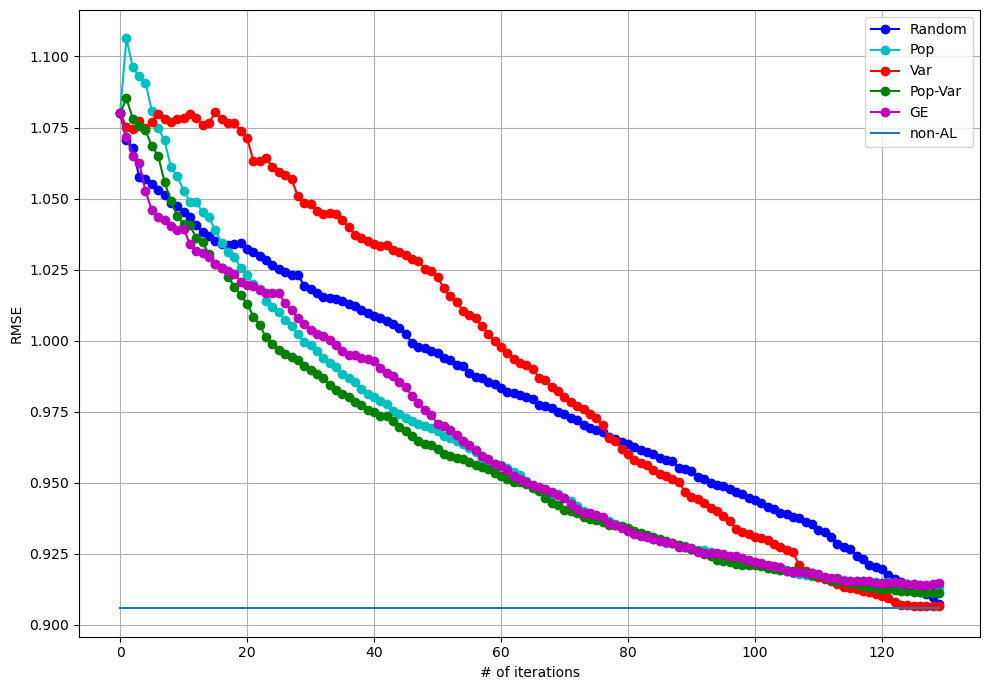

In [122]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

# y_axis = list(range(0, dataset.item_n, w))
# y_axis = list(range(0, results[i][1]['rmse']))


for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(list(range(0, len(results[i][1]['rmse']))), results[i][1]['rmse'], m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
    

ax.plot(list(range(0, len(results[0][1]['rmse']))), [fin_acc]*len(list(range(0, len(results[0][1]['rmse'])))),'-', label='non-AL')   
# ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all-tr')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('Non-personalized AL Strategies')

# plt.show()
# plt.savefig('./outputs/rmse_exp1_iter4.png', dpi=300)

## RMSE difference

In [123]:
# results[0][1].keys()

Text(0, 0.5, 'RMSE difference')

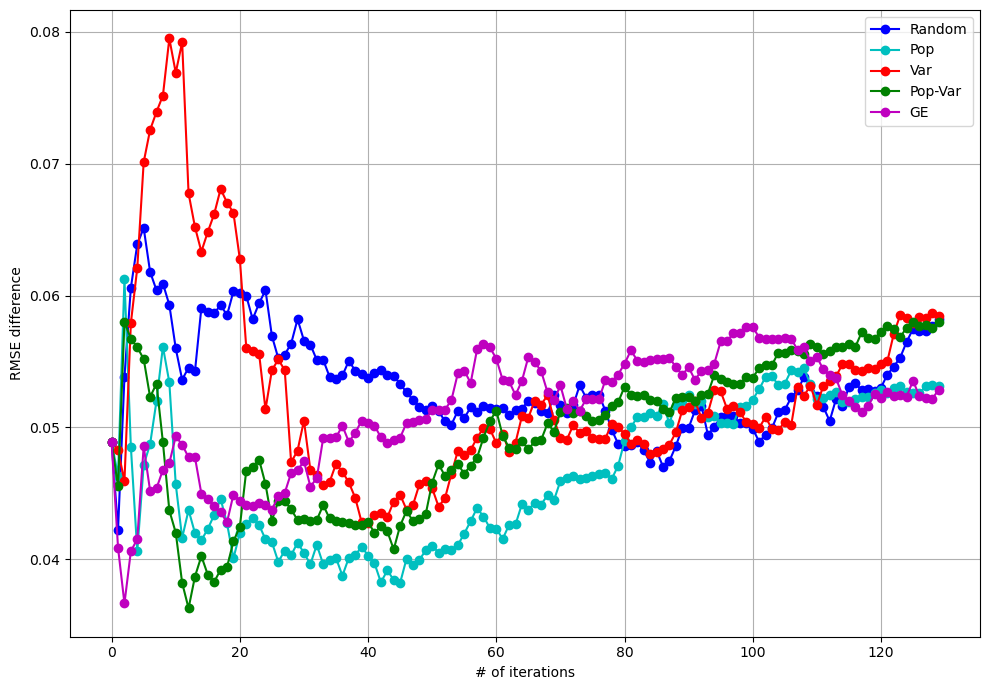

In [124]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(list(range(0, len(results[i][1]['rmse']))), rmse_diff, m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')

# plt.show()
# plt.savefig('./outputs/rmse_diff_exp1_iter4.png', dpi=300)

- why does popvar work best than the others here?
    - popvar has one of the lowest RMSE and also rmse difference. 
    - women in this dataset have rated more popular items and there are many items in the long tail that are rated by men that have very little rating by women. Women and men have different tastes (need to check), then by picking high variance items and also popular items, it's more likely to include women in the selections. So, this strategy picks a more balanced set of men and women.
    - so both low RMSE, and low accuracy difference.
    - the datasets follow the powerlaw distribtuions. Are we doomed to select items from the majority groups even it is random????
    

## SEP RMSE 

Text(0, 0.5, 'RMSE')

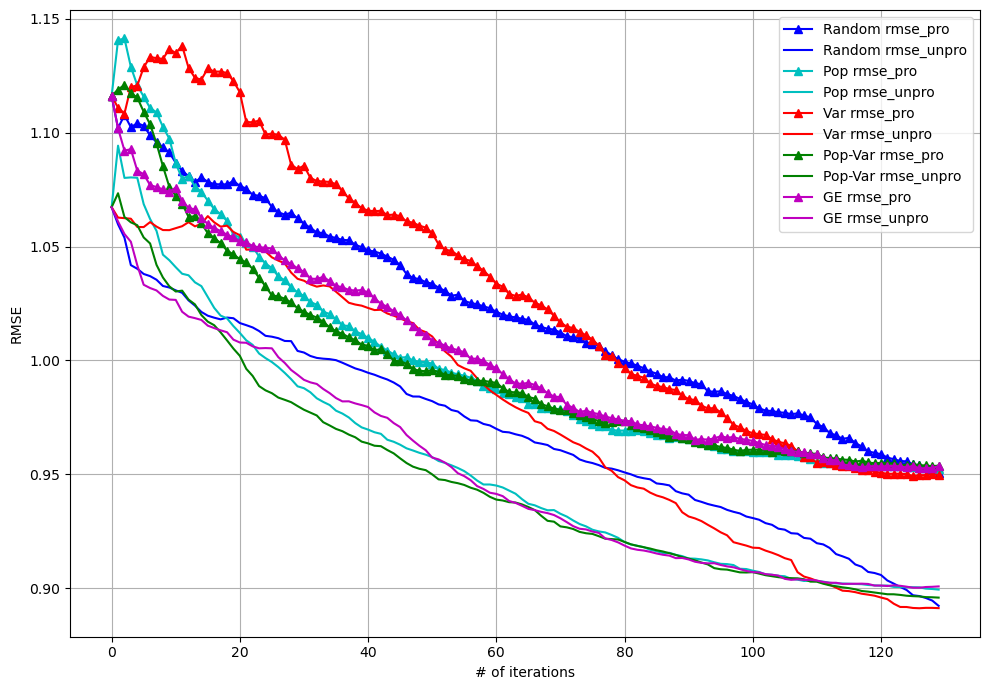

In [125]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))
list(range(0, len(results[i][1]['rmse'])))


for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['rmse_pro']))), results[i][1]['rmse_pro'], m+'^', label=label_d[results[i][0]]+' rmse_pro')
    ax.plot(list(range(0, len(results[i][1]['rmse_unpro']))), results[i][1]['rmse_unpro'], m, label=label_d[results[i][0]]+' rmse_unpro')
    # ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    # ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('RMSE Plors for Pro & Unpro')
# plt.show()
# plt.savefig('./outputs/rmse_sep_exp1_iter4.png', dpi=300)

## pro/Unpro count

In [124]:
# list(range(0, len()))

Text(0, 0.5, 'rating count')

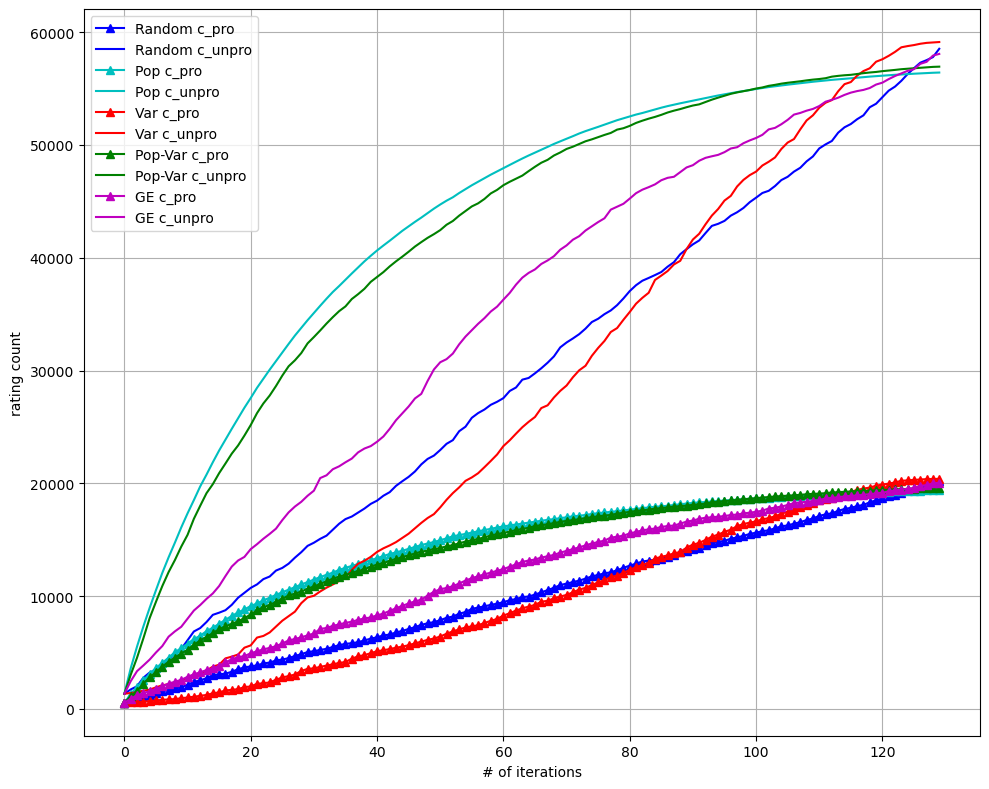

In [126]:
fig, ax = plt.subplots(figsize=(10, 8))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

# y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['c_pro']))), results[i][1]['c_pro'], m+'^', label=label_d[results[i][0]]+' c_pro')
    ax.plot(list(range(0, len(results[i][1]['c_unpro']))), results[i][1]['c_unpro'], m, label=label_d[results[i][0]]+' c_unpro')

    
#     ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
#     ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('rating count')
# plt.title('Pro & Unpro Counts')
# plt.show()
# plt.savefig('./outputs/c_sep_exp1_iter4.png', dpi=300)

- this number tells us the number of ratings counts by mena dn women.
- pop and popvar both take a lot of ratings initially and then it decreases
    - maybe that is why they have lower RMSE, as they have more data for the majority
    - their RMSE for the unpro group is the lowest
    - RMSE for prot group is almost similar but popvar is slightly lower.
- var takes less ratings initially but a more equal number of men and women
    - that's why it has lower rmse
    - then it kinda grows as it doesn't have any other choice than selecting mroe data from men.
    - so we can say that controversial items with high variance rating, don't have many ratings on them in general but the number of men and women is more equal. (??? There are certain niche items that men adn women disagree on a lot.)
    
- popvar and var have small rmse differences compared to others. Var has smaller rmse difference.

## How popular are the items that have more balanced ratings?

In [127]:
item_f_m_cnt['c'] = item_f_m_cnt['F_c']+item_f_m_cnt['M_c']
# item_f_m_cnt.head()

In [128]:
itemSortedByPop = item_f_m_cnt.sort_values(by='pop')
itemSortedByPop.head()

,item_iid,F_c,M_c,F_med,F_avg,M_med,M_avg,pop,normpop,var,sqrt normpopvar,npop,sqrt npopvar,c
877,877,0.0,3.0,0.0,0.0,3.0,2.666667,3,0,0.222222,0,0.0,0.0,3.0
461,461,1.0,2.0,2.0,2.0,4.5,4.500000,3,0,1.555556,0,0.0,0.0,3.0
658,658,1.0,2.0,4.0,4.0,1.5,1.500000,3,0,1.555556,0,0.0,0.0,3.0
1071,1071,1.0,2.0,2.0,2.0,2.0,2.000000,3,0,0.666667,0,0.0,0.0,3.0
1171,1171,1.0,2.0,1.0,1.0,2.0,2.000000,3,0,0.222222,0,0.0,0.0,3.0


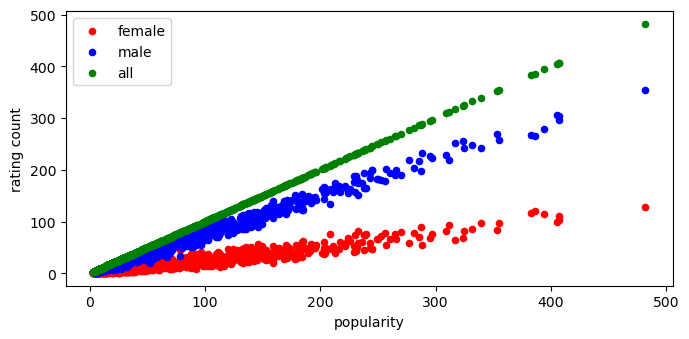

In [129]:

ax1 = itemSortedByPop.plot(kind = 'scatter', x='pop', y='F_c', c='red', label='female')
ax2 = itemSortedByPop.plot(kind='scatter', x='pop', y='M_c', c='blue', label='male', ax= ax1)
ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("rating count")
plt.show()

In [130]:
from sklearn.metrics import r2_score

print(r2_score(itemSortedByPop['pop'], itemSortedByPop['c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['M_c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['F_c']))

1.0
0.8777384685099019
-0.01995307544500302


- The more popular an item is the more ratings it has. This trend is true for men, but not for women. There's a slight correlation.
- very popular items are not that many and they have more mens' ratings compared to women.
- the more popular an item gets, the less rating from women it gathers, then the accuracy difference increases.

- women's ratings have more variance

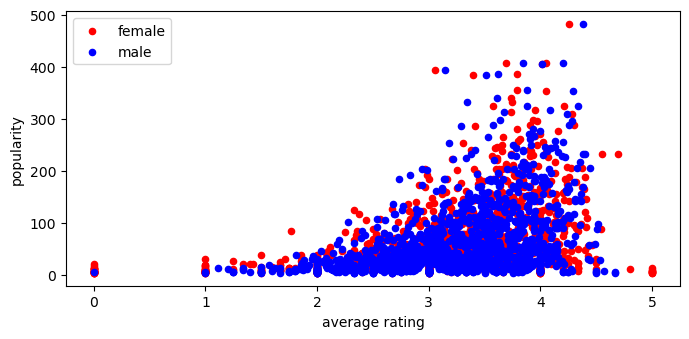

In [131]:

ax1 = itemSortedByPop.plot(kind = 'scatter', y='pop', x='F_avg', c='red', label='female')
ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='M_avg', c='blue', label='male', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_ylabel("popularity")
ax1.set_xlabel("average rating")
plt.show()

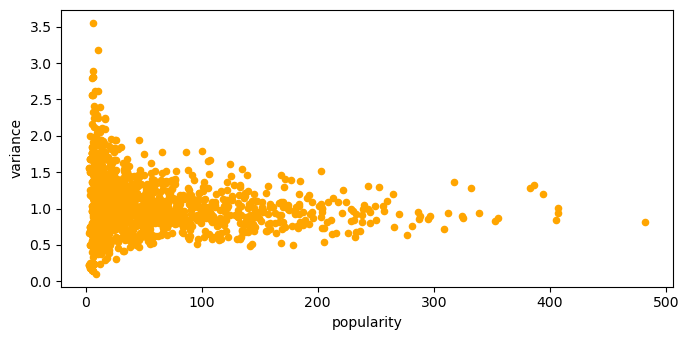

In [132]:
ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='pop', c='Orange')
# ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='M_avg', c='Blue', label='male', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("variance")
plt.show()

In [133]:
itemSortedByPop

,item_iid,F_c,M_c,F_med,F_avg,M_med,M_avg,pop,normpop,var,sqrt normpopvar,npop,sqrt npopvar,c
877,877,0.0,3.0,0.0,0.000000,3.0,2.666667,3,0,0.222222,0,0.000000,0.000000,3.0
461,461,1.0,2.0,2.0,2.000000,4.5,4.500000,3,0,1.555556,0,0.000000,0.000000,3.0
658,658,1.0,2.0,4.0,4.000000,1.5,1.500000,3,0,1.555556,0,0.000000,0.000000,3.0
1071,1071,1.0,2.0,2.0,2.000000,2.0,2.000000,3,0,0.666667,0,0.000000,0.000000,3.0
1171,1171,1.0,2.0,1.0,1.000000,2.0,2.000000,3,0,0.222222,0,0.000000,0.000000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,115.0,279.0,3.0,3.052174,3.0,3.146953,394,0,1.206582,0,0.816284,1.090128,394.0
326,326,100.0,305.0,4.0,4.010000,4.0,4.016393,405,0,0.839287,0,0.839248,0.768875,405.0
460,460,103.0,304.0,4.0,4.048544,4.0,4.203947,407,0,0.943417,0,0.843424,0.866416,407.0
661,661,110.0,297.0,4.0,3.690909,4.0,3.841751,407,0,1.004618,0,0.843424,0.922622,407.0


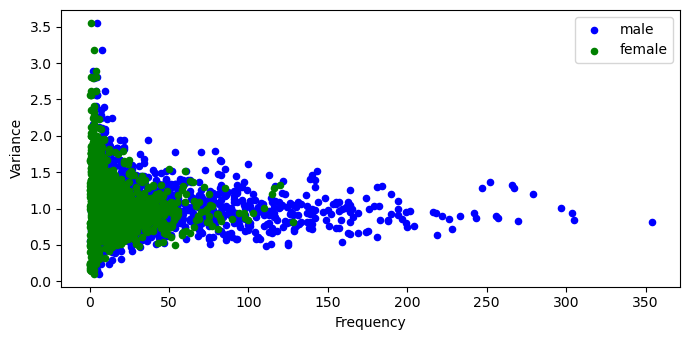

In [134]:
# ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='M_c', c='Orange')
ax1 = itemSortedByPop.plot(kind='scatter', y='var', x='M_c', c='blue', label='male')
ax2 = itemSortedByPop.plot(kind='scatter', y='var', x='F_c', c='green', label='female', ax=ax1)

ax1.set_xlabel("Frequency")
ax1.set_ylabel("Variance")
plt.show()

- There are a lot of items with high popularity and very low variance.
- And the popular items have mostly male ratings.
- So, high variance items have low to medium popularity and also more balanced ratings probably.

# RATIO EXPERIMENT

# 2. random known_df / same ratio picking / normal test 

In [135]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(tr_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        if i_indx%100. == 0.:
            print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]
            
            
            # filtering for equal proportions
            chosen_df = tr_df[tr_df['item'].isin(chosen_is)]
            
            pro_chosen_df = chosen_df[chosen_df['user'].isin(pro_users_index)]
            
            p_c = pro_chosen_df.shape[0] # count of how many female ratings
            
            # select as many male ratings as women's ratings
            unpro_chosen_df = chosen_df[~chosen_df['user'].isin(pro_users_index)][:p_c]

            
            print(p_c, unpro_chosen_df.shape[0])
            
            
            tr_iter = pd.concat([tr_iter, 
                                pro_chosen_df,
                                unpro_chosen_df]).drop_duplicates()

            # Sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#             tr_iter = pd.concat([tr_iter, 
#                                   tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()
        
        else:
            tr_iter = knw_df

 
            
        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])
        
        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    
    


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}

#     strtgs = {'ran':shuffled_i_ran}
    

    
    #------------------------ test set & algo & window ---------------------
    # the known set, a part of the training set
    # known_n = 0.02
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    known_df = initial_train_df
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    # svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=42)
#     algo = SVD()

    w = 10   # window of w items
    
    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=30)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))


while loop:   0%|                                    | 0/1299 [00:00<?, ?it/s]

sample 0-th item...

while loop:   0%|                                    | 0/1299 [00:00<?, ?it/s]

sample 0-th item...sample 0-th item...sample 0-th item...

sample 0-th item...




while loop:   0%|                            | 1/1299 [00:00<02:56,  7.33it/s]

29585366 764 10729  585 
366
764107




while loop:   0%|                            | 2/1299 [00:00<02:57,  7.32it/s]

29 29
115 115


while loop:   0%|                            | 2/1299 [00:00<03:03,  7.07it/s]

310 310


while loop:   0%|                            | 2/1299 [00:00<03:09,  6.83it/s]

495 495


while loop:   0%|                            | 2/1299 [00:00<03:15,  6.62it/s]

696 696


while loop:   0%|                            | 3/1299 [00:00<04:30,  4.80it/s]

51 51


while loop:   0%|                            | 3/1299 [00:00<04:43,  4.58it/s]

123 

while loop:   0%|                            | 3/1299 [00:00<04:43,  4.57it/s]

123
196 196


while loop:   0%|                            | 3/1299 [00:00<05:06,  4.23it/s]

659 659


while loop:   0%|                            | 3/1299 [00:00<05:12,  4.15it/s]

602 602


while loop:   0%|                            | 4/1299 [00:00<03:53,  5.55it/s]

37 37


while loop:   0%|                            | 4/1299 [00:00<04:05,  5.27it/s]

235 235


while loop:   0%|                            | 4/1299 [00:00<04:16,  5.04it/s]

179 179


while loop:   0%|                            | 4/1299 [00:00<04:46,  4.52it/s]

600 600


while loop:   0%|                            | 5/1299 [00:00<03:33,  6.07it/s]

67 67


while loop:   0%|                            | 4/1299 [00:00<04:58,  4.33it/s]

594 594


while loop:   0%|                            | 5/1299 [00:00<03:49,  5.64it/s]

101 101


while loop:   0%|                            | 5/1299 [00:00<04:04,  5.29it/s]

200 200


while loop:   0%|▏                           | 6/1299 [00:00<03:22,  6.39it/s]

45 45


while loop:   0%|▏                           | 6/1299 [00:01<03:41,  5.83it/s]

121

while loop:   0%|                            | 5/1299 [00:01<04:46,  4.52it/s]

 121
457 457


while loop:   0%|                            | 5/1299 [00:01<05:02,  4.28it/s]

526 526


while loop:   0%|▏                           | 6/1299 [00:01<03:59,  5.39it/s]

233 233


while loop:   1%|▏                           | 7/1299 [00:01<03:15,  6.59it/s]

51 51


while loop:   1%|▏                           | 7/1299 [00:01<03:37,  5.94it/s]

135 135


while loop:   1%|▏                           | 8/1299 [00:01<03:12,  6.70it/s]

24 24


while loop:   0%|▏                           | 6/1299 [00:01<04:52,  4.41it/s]

518 518


while loop:   1%|▏                           | 7/1299 [00:01<04:00,  5.38it/s]

249 249


while loop:   0%|▏                           | 6/1299 [00:01<05:12,  4.13it/s]

461 461


while loop:   1%|▏                           | 8/1299 [00:01<03:37,  5.94it/s]

131 131


while loop:   1%|▏                           | 8/1299 [00:01<04:04,  5.28it/s]

166 166


while loop:   1%|▏                           | 9/1299 [00:01<03:46,  5.70it/s]

82 82


while loop:   1%|▏                           | 7/1299 [00:01<05:04,  4.25it/s]

432 432


while loop:   1%|▏                           | 7/1299 [00:01<05:28,  3.94it/s]

485 485


while loop:   1%|▏                          | 10/1299 [00:01<03:36,  5.96it/s]

sample 100-th item...


while loop:   1%|▏                           | 9/1299 [00:01<04:18,  4.98it/s]

67 176 67176



while loop:   1%|▏                           | 9/1299 [00:01<04:49,  4.45it/s]

177 177


while loop:   1%|▏                          | 11/1299 [00:01<03:30,  6.13it/s]

67 67


while loop:   1%|▏                           | 8/1299 [00:01<05:21,  4.02it/s]

384 384


while loop:   1%|▏                          | 10/1299 [00:01<04:10,  5.15it/s]

sample 100-th item...
264 264


while loop:   1%|▏                           | 8/1299 [00:01<05:46,  3.73it/s]

489 489


while loop:   1%|▏                          | 12/1299 [00:01<03:25,  6.26it/s]

89 89


while loop:   1%|▏                          | 10/1299 [00:02<04:43,  4.55it/s]

sample 100-th item...
277 277


while loop:   1%|▏                          | 11/1299 [00:02<04:08,  5.18it/s]

141 141


while loop:   1%|▎                          | 13/1299 [00:02<03:23,  6.30it/s]

72 72


while loop:   1%|▏                           | 9/1299 [00:02<06:13,  3.46it/s]

363 363


while loop:   1%|▏                          | 12/1299 [00:02<04:08,  5.18it/s]

193 193


while loop:   1%|▏                          | 11/1299 [00:02<04:43,  4.54it/s]

230 230


while loop:   1%|▎                          | 14/1299 [00:02<03:23,  6.32it/s]

158 158


while loop:   1%|▏                           | 9/1299 [00:02<06:41,  3.22it/s]

371 371


while loop:   1%|▎                          | 13/1299 [00:02<04:12,  5.09it/s]

106 106


while loop:   1%|▎                          | 15/1299 [00:02<03:25,  6.26it/s]

77 77


while loop:   1%|▏                          | 12/1299 [00:02<04:50,  4.44it/s]

173 173


while loop:   1%|▏                          | 10/1299 [00:02<06:17,  3.41it/s]

sample 100-th item...
353 353


while loop:   1%|▎                          | 14/1299 [00:02<04:18,  4.98it/s]

140 140


while loop:   1%|▏                          | 10/1299 [00:02<06:50,  3.14it/s]

sample 100-th item...
411 411


while loop:   1%|▎                          | 16/1299 [00:02<04:04,  5.25it/s]

173 173


while loop:   1%|▎                          | 13/1299 [00:02<04:54,  4.37it/s]

213 213


while loop:   1%|▏                          | 11/1299 [00:02<06:26,  3.34it/s]

457 457


while loop:   1%|▎                          | 15/1299 [00:02<04:19,  4.94it/s]

247 247


while loop:   1%|▎                          | 17/1299 [00:02<03:56,  5.43it/s]

54 54


while loop:   1%|▎                          | 14/1299 [00:02<05:01,  4.26it/s]

156 156


while loop:   1%|▏                          | 11/1299 [00:03<06:59,  3.07it/s]

406 406


while loop:   1%|▎                          | 18/1299 [00:03<03:51,  5.53it/s]

66 66


while loop:   1%|▎                          | 16/1299 [00:03<05:00,  4.28it/s]

79 79


while loop:   1%|▏                          | 12/1299 [00:03<06:40,  3.21it/s]

379 379


while loop:   1%|▎                          | 15/1299 [00:03<05:05,  4.20it/s]

219 219


while loop:   1%|▍                          | 19/1299 [00:03<03:49,  5.58it/s]

186 186


while loop:   1%|▎                          | 17/1299 [00:03<04:58,  4.29it/s]

116 116


while loop:   1%|▏                          | 12/1299 [00:03<07:16,  2.95it/s]

317 317


while loop:   2%|▍                          | 20/1299 [00:03<03:52,  5.51it/s]

sample 200-th item...
52 52


while loop:   1%|▎                          | 13/1299 [00:03<06:56,  3.09it/s]

346 346


while loop:   1%|▎                          | 16/1299 [00:03<05:53,  3.63it/s]

330 330


while loop:   2%|▍                          | 21/1299 [00:03<03:56,  5.40it/s]

250 250


while loop:   1%|▎                          | 18/1299 [00:03<04:58,  4.30it/s]

94 94


while loop:   1%|▎                          | 13/1299 [00:03<07:34,  2.83it/s]

416 416


while loop:   1%|▎                          | 17/1299 [00:03<05:54,  3.62it/s]

210 279210 
279


while loop:   1%|▎                          | 14/1299 [00:03<07:09,  2.99it/s]

335 335


while loop:   2%|▍                          | 22/1299 [00:03<04:40,  4.55it/s]

42 42


while loop:   2%|▍                          | 20/1299 [00:04<04:58,  4.28it/s]

sample 200-th item...
172 172


while loop:   2%|▍                          | 23/1299 [00:04<04:32,  4.69it/s]

87 87


while loop:   1%|▎                          | 18/1299 [00:04<05:58,  3.58it/s]

184 184


while loop:   1%|▎                          | 14/1299 [00:04<07:52,  2.72it/s]

315 315


while loop:   1%|▎                          | 15/1299 [00:04<07:25,  2.88it/s]

372 372


while loop:   2%|▍                          | 24/1299 [00:04<04:27,  4.77it/s]

246 246


while loop:   2%|▍                          | 21/1299 [00:04<05:03,  4.22it/s]

170 170


while loop:   1%|▍                          | 19/1299 [00:04<06:02,  3.53it/s]

106 106


while loop:   2%|▌                          | 25/1299 [00:04<04:27,  4.77it/s]

213 213


while loop:   1%|▎                          | 15/1299 [00:04<08:08,  2.63it/s]

349 349


while loop:   2%|▍                          | 22/1299 [00:04<05:48,  3.66it/s]

139 139


while loop:   2%|▍                          | 20/1299 [00:04<06:07,  3.48it/s]

sample 200-th item...
251 251


while loop:   2%|▌                          | 26/1299 [00:04<04:32,  4.68it/s]

240 128240 
128


while loop:   2%|▍                          | 23/1299 [00:04<05:43,  3.71it/s]

73 73


while loop:   2%|▌                          | 27/1299 [00:04<04:34,  4.63it/s]

137 137


while loop:   2%|▍                          | 21/1299 [00:05<06:11,  3.44it/s]

189 189


while loop:   1%|▎                          | 16/1299 [00:05<08:59,  2.38it/s]

373 373


while loop:   1%|▎                          | 17/1299 [00:05<08:24,  2.54it/s]

233 233


while loop:   2%|▌                          | 28/1299 [00:05<04:40,  4.54it/s]

334 334


while loop:   2%|▍                          | 24/1299 [00:05<05:40,  3.74it/s]

82 82


while loop:   2%|▍                          | 22/1299 [00:05<07:03,  3.02it/s]

180 180


while loop:   2%|▌                          | 25/1299 [00:05<05:39,  3.76it/s]

105 105


while loop:   2%|▌                          | 29/1299 [00:05<05:33,  3.81it/s]

183 183

while loop:   1%|▎                          | 18/1299 [00:05<08:30,  2.51it/s]

while loop:   1%|▎                          | 17/1299 [00:05<09:08,  2.34it/s]

230 230
349 349


while loop:   2%|▌                          | 26/1299 [00:05<05:38,  3.76it/s]

220 220


while loop:   2%|▍                          | 23/1299 [00:05<06:58,  3.05it/s]

136 136


while loop:   2%|▌                          | 30/1299 [00:05<05:29,  3.85it/s]

sample 300-th item...
51 51


while loop:   1%|▍                          | 19/1299 [00:05<08:34,  2.49it/s]

290 290


while loop:   1%|▎                          | 18/1299 [00:05<09:17,  2.30it/s]

322 322


while loop:   2%|▌                          | 27/1299 [00:06<05:41,  3.72it/s]

232 232


while loop:   2%|▋                          | 31/1299 [00:06<05:29,  3.85it/s]

136 136


while loop:   2%|▍                          | 24/1299 [00:06<06:59,  3.04it/s]

156 156


while loop:   2%|▋                          | 32/1299 [00:06<05:28,  3.85it/s]

118 118


while loop:   2%|▌                          | 28/1299 [00:06<06:20,  3.34it/s]

sample 200-th item...
121 121338
 338


while loop:   2%|▌                          | 25/1299 [00:06<07:02,  3.02it/s]

254 254


while loop:   1%|▍                          | 19/1299 [00:06<09:26,  2.26it/s]

270 270


while loop:   3%|▋                          | 33/1299 [00:06<05:28,  3.86it/s]

114 114


while loop:   2%|▌                          | 29/1299 [00:06<06:18,  3.36it/s]

309 309


while loop:   2%|▌                          | 26/1299 [00:06<07:03,  3.01it/s]

270 270


while loop:   2%|▍                          | 21/1299 [00:06<08:57,  2.38it/s]

377 377


while loop:   3%|▋                          | 34/1299 [00:06<05:29,  3.84it/s]

125 125


while loop:   2%|▍                          | 20/1299 [00:06<09:38,  2.21it/s]

sample 200-th item...
314 314


while loop:   2%|▌                          | 30/1299 [00:06<06:19,  3.34it/s]

sample 300-th item...
198 198


while loop:   2%|▌                          | 27/1299 [00:07<07:09,  2.96it/s]

136 136


while loop:   3%|▋                          | 35/1299 [00:07<06:06,  3.44it/s]

88 88


while loop:   2%|▋                          | 31/1299 [00:07<06:26,  3.28it/s]

196 196


while loop:   2%|▍                          | 22/1299 [00:07<09:50,  2.16it/s]

287 287


while loop:   2%|▍                          | 21/1299 [00:07<09:54,  2.15it/s]

230 230


while loop:   3%|▋                          | 36/1299 [00:07<06:00,  3.51it/s]

301 301


while loop:   2%|▌                          | 28/1299 [00:07<07:50,  2.70it/s]

152 152


while loop:   2%|▋                          | 32/1299 [00:07<06:33,  3.22it/s]

242 242


while loop:   3%|▊                          | 37/1299 [00:07<06:01,  3.49it/s]

220 220


while loop:   2%|▍                          | 23/1299 [00:07<09:52,  2.15it/s]

192 192


while loop:   2%|▌                          | 29/1299 [00:07<07:44,  2.74it/s]

180 180


while loop:   3%|▋                          | 33/1299 [00:07<06:42,  3.15it/s]

182 182


while loop:   2%|▍                          | 22/1299 [00:08<10:52,  1.96it/s]

283 283


while loop:   3%|▊                          | 38/1299 [00:08<06:12,  3.38it/s]

109 109


while loop:   2%|▌                          | 30/1299 [00:08<07:55,  2.67it/s]

sample 300-th item...


while loop:   3%|▋                          | 34/1299 [00:08<06:58,  3.02it/s]

17098  17098



while loop:   2%|▍                          | 24/1299 [00:08<10:07,  2.10it/s]

277 277


while loop:   3%|▊                          | 39/1299 [00:08<06:16,  3.35it/s]

174 174


while loop:   2%|▍                          | 23/1299 [00:08<10:55,  1.95it/s]

244 244


while loop:   3%|▊                          | 40/1299 [00:08<06:18,  3.33it/s]

sample 400-th item...
185 185


while loop:   2%|▋                          | 31/1299 [00:08<07:59,  2.65it/s]

416 416


while loop:   3%|▋                          | 35/1299 [00:08<07:34,  2.78it/s]

162 162


while loop:   2%|▌                          | 25/1299 [00:08<10:14,  2.07it/s]

285 285


while loop:   2%|▋                          | 32/1299 [00:09<08:02,  2.63it/s]

83 83


while loop:   3%|▊                          | 41/1299 [00:09<06:58,  3.00it/s]

255 255208
78  20878



while loop:   2%|▌                          | 26/1299 [00:09<10:22,  2.04it/s]

304 304


while loop:   3%|▊                          | 42/1299 [00:09<06:54,  3.03it/s]

120 120


while loop:   3%|▊                          | 37/1299 [00:09<07:27,  2.82it/s]

176 176


while loop:   3%|▋                          | 33/1299 [00:09<08:07,  2.60it/s]

192 192


while loop:   2%|▌                          | 25/1299 [00:09<11:04,  1.92it/s]

247 247


while loop:   3%|▉                          | 43/1299 [00:09<06:54,  3.03it/s]

112 112


while loop:   3%|▊                          | 38/1299 [00:09<07:26,  2.82it/s]

189 189


while loop:   2%|▌                          | 27/1299 [00:09<10:26,  2.03it/s]

163 163


while loop:   3%|▋                          | 34/1299 [00:09<08:19,  2.53it/s]

140 140


while loop:   3%|▉                          | 44/1299 [00:10<06:50,  3.06it/s]

104 104


while loop:   2%|▌                          | 26/1299 [00:10<11:13,  1.89it/s]

227 227


while loop:   3%|▊                          | 39/1299 [00:10<07:38,  2.75it/s]

91 91


while loop:   2%|▌                          | 28/1299 [00:10<10:30,  2.02it/s]

199 199


while loop:   3%|▉                          | 45/1299 [00:10<06:47,  3.08it/s]

126 126


while loop:   3%|▋                          | 35/1299 [00:10<09:06,  2.31it/s]

134 134


while loop:   3%|▊                          | 40/1299 [00:10<07:43,  2.71it/s]

sample 400-th item...
161 161


while loop:   2%|▌                          | 27/1299 [00:10<11:24,  1.86it/s]

230 230


while loop:   4%|▉                          | 46/1299 [00:10<06:54,  3.02it/s]

167 167


while loop:   3%|▋                          | 36/1299 [00:10<09:03,  2.32it/s]

106 106


while loop:   2%|▌                          | 29/1299 [00:10<11:19,  1.87it/s]

258 258


while loop:   3%|▊                          | 41/1299 [00:11<08:23,  2.50it/s]

202 202


while loop:   4%|▉                          | 47/1299 [00:11<06:57,  3.00it/s]

150 150


while loop:   3%|▊                          | 37/1299 [00:11<08:58,  2.34it/s]

168 168


while loop:   2%|▌                          | 28/1299 [00:11<12:12,  1.74it/s]

250 250


while loop:   3%|▊                          | 42/1299 [00:11<08:16,  2.53it/s]

151 151


while loop:   4%|▉                          | 48/1299 [00:11<07:33,  2.76it/s]

166 166


while loop:   2%|▌                          | 30/1299 [00:11<11:24,  1.85it/s]

sample 300-th item...
200 200


while loop:   3%|▊                          | 38/1299 [00:11<09:04,  2.32it/s]

123 123


while loop:   3%|▉                          | 43/1299 [00:11<08:15,  2.54it/s]

215 215


while loop:   4%|█                          | 49/1299 [00:11<07:30,  2.77it/s]

119 119


while loop:   2%|▌                          | 29/1299 [00:11<12:09,  1.74it/s]

217 217


while loop:   2%|▋                          | 31/1299 [00:12<11:32,  1.83it/s]

213 213


while loop:   3%|▊                          | 39/1299 [00:12<09:05,  2.31it/s]

98 98


while loop:   3%|▉                          | 44/1299 [00:12<08:14,  2.54it/s]

148 148


while loop:   4%|█                          | 50/1299 [00:12<07:30,  2.77it/s]

sample 500-th item...
181 181


while loop:   2%|▌                          | 30/1299 [00:12<12:11,  1.73it/s]

sample 300-th item...
234 234


while loop:   3%|▊                          | 40/1299 [00:12<09:13,  2.28it/s]

sample 400-th item...
184 184


while loop:   3%|▉                          | 45/1299 [00:12<08:16,  2.52it/s]

246 246237
 237


while loop:   2%|▋                          | 32/1299 [00:12<11:33,  1.83it/s]

257 257


while loop:   4%|█                          | 52/1299 [00:12<07:48,  2.66it/s]

218 218


while loop:   4%|▉                          | 46/1299 [00:13<08:30,  2.45it/s]

97 97


while loop:   3%|▊                          | 41/1299 [00:13<09:47,  2.14it/s]

162 162


while loop:   2%|▋                          | 31/1299 [00:13<12:20,  1.71it/s]

226 226


while loop:   3%|▋                          | 33/1299 [00:13<11:39,  1.81it/s]

232 232


while loop:   4%|█                          | 53/1299 [00:13<07:56,  2.62it/s]

174 174


while loop:   4%|▉                          | 47/1299 [00:13<08:32,  2.44it/s]

120 120


while loop:   3%|▊                          | 42/1299 [00:13<09:45,  2.15it/s]

253 253


while loop:   2%|▋                          | 32/1299 [00:13<12:25,  1.70it/s]

201 201


while loop:   3%|▋                          | 34/1299 [00:13<11:44,  1.80it/s]

180 180


while loop:   4%|█                          | 54/1299 [00:13<08:42,  2.38it/s]

175 175


while loop:   4%|▉                          | 48/1299 [00:13<09:10,  2.27it/s]

164 164


while loop:   3%|▉                          | 43/1299 [00:14<09:49,  2.13it/s]

230 230


while loop:   4%|█▏                         | 55/1299 [00:14<08:36,  2.41it/s]

103 103


while loop:   3%|▋                          | 33/1299 [00:14<12:38,  1.67it/s]

202 202


while loop:   4%|█                          | 49/1299 [00:14<09:11,  2.27it/s]

125 125


while loop:   3%|▋                          | 35/1299 [00:14<12:29,  1.69it/s]

168 168


while loop:   3%|▉                          | 44/1299 [00:14<09:49,  2.13it/s]

235 235


while loop:   4%|█▏                         | 56/1299 [00:14<08:29,  2.44it/s]

96 96


while loop:   4%|█                          | 50/1299 [00:14<09:08,  2.28it/s]

sample 500-th item...
108 108


while loop:   3%|▋                          | 34/1299 [00:14<12:47,  1.65it/s]

243 243


while loop:   3%|▉                          | 45/1299 [00:15<09:57,  2.10it/s]

204 204


while loop:   3%|▋                          | 36/1299 [00:15<12:34,  1.67it/s]

193 193


while loop:   4%|█▏                         | 57/1299 [00:15<08:31,  2.43it/s]

209 209


while loop:   4%|█                          | 51/1299 [00:15<09:20,  2.23it/s]

89 89


while loop:   4%|▉                          | 46/1299 [00:15<10:12,  2.04it/s]

197 197


while loop:   4%|█▏                         | 58/1299 [00:15<08:40,  2.38it/s]

188 188


while loop:   3%|▊                          | 37/1299 [00:15<12:48,  1.64it/s]

155 155


while loop:   3%|▋                          | 35/1299 [00:15<13:54,  1.52it/s]

190 

while loop:   4%|█                          | 52/1299 [00:15<09:27,  2.20it/s]

190
156 156


while loop:   5%|█▏                         | 59/1299 [00:16<08:51,  2.33it/s]

173 173


while loop:   4%|▉                          | 47/1299 [00:16<10:59,  1.90it/s]

143 143


while loop:   4%|█                          | 53/1299 [00:16<09:33,  2.17it/s]

162 162


while loop:   3%|▊                          | 38/1299 [00:16<12:53,  1.63it/s]

180 180


while loop:   3%|▋                          | 36/1299 [00:16<13:54,  1.51it/s]

172 172


while loop:   5%|█▏                         | 60/1299 [00:16<09:35,  2.15it/s]

sample 600-th item...
310 310


while loop:   4%|▉                          | 48/1299 [00:16<10:53,  1.91it/s]

381 381


while loop:   4%|█                          | 54/1299 [00:16<10:10,  2.04it/s]

106 106


while loop:   3%|▊                          | 39/1299 [00:16<12:58,  1.62it/s]

226 226


while loop:   5%|█▎                         | 61/1299 [00:17<09:30,  2.17it/s]

210 210


while loop:   3%|▊                          | 37/1299 [00:17<13:52,  1.52it/s]

167 167


while loop:   4%|█                          | 49/1299 [00:17<10:48,  1.93it/s]

350 350


while loop:   4%|█▏                         | 55/1299 [00:17<10:00,  2.07it/s]

187 187


while loop:   5%|█▎                         | 62/1299 [00:17<09:24,  2.19it/s]

251 251


while loop:   3%|▊                          | 40/1299 [00:17<13:04,  1.60it/s]

sample 400-th item...
179 179


while loop:   4%|█                          | 50/1299 [00:17<10:55,  1.91it/s]

sample 500-th item...
229 229


while loop:   4%|█▏                         | 56/1299 [00:17<09:55,  2.09it/s]

246 246


while loop:   3%|▊                          | 38/1299 [00:17<13:51,  1.52it/s]

158 158


while loop:   5%|█▎                         | 63/1299 [00:17<09:25,  2.19it/s]

206 206


while loop:   3%|▊                          | 41/1299 [00:18<13:04,  1.60it/s]

154 154


while loop:   4%|█▏                         | 57/1299 [00:18<10:02,  2.06it/s]

83 83


while loop:   4%|█                          | 51/1299 [00:18<11:08,  1.87it/s]

110 110


while loop:   5%|█▎                         | 64/1299 [00:18<09:26,  2.18it/s]

155 155


while loop:   3%|▊                          | 39/1299 [00:18<13:50,  1.52it/s]

182 182


while loop:   4%|█▏                         | 58/1299 [00:18<10:07,  2.04it/s]

116 116


while loop:   4%|█                          | 52/1299 [00:18<11:07,  1.87it/s]

167 167


while loop:   5%|█▎                         | 65/1299 [00:18<09:33,  2.15it/s]

162 162


while loop:   3%|▊                          | 42/1299 [00:18<13:51,  1.51it/s]

202 202


while loop:   3%|▊                          | 40/1299 [00:19<13:54,  1.51it/s]

sample 400-th item...
184 184


while loop:   5%|█▏                         | 59/1299 [00:19<10:09,  2.04it/s]

227 227


while loop:   5%|█▎                         | 66/1299 [00:19<09:44,  2.11it/s]

286 286


while loop:   4%|█                          | 53/1299 [00:19<11:11,  1.85it/s]

248 248


while loop:   3%|▉                          | 43/1299 [00:19<13:44,  1.52it/s]

161 161


while loop:   5%|█▏                         | 60/1299 [00:19<10:54,  1.89it/s]

sample 600-th item...
91 91


while loop:   3%|▊                          | 41/1299 [00:19<14:43,  1.42it/s]

193 193


while loop:   5%|█▍                         | 67/1299 [00:19<10:34,  1.94it/s]

80 80


while loop:   4%|█                          | 54/1299 [00:20<12:11,  1.70it/s]

266 266


while loop:   3%|▉                          | 44/1299 [00:20<13:43,  1.52it/s]

175 175


while loop:   5%|█▎                         | 61/1299 [00:20<10:42,  1.93it/s]

137 137


while loop:   5%|█▍                         | 68/1299 [00:20<10:25,  1.97it/s]

235 235


while loop:   3%|▊                          | 42/1299 [00:20<14:35,  1.44it/s]

189 189


while loop:   4%|█▏                         | 55/1299 [00:20<12:13,  1.70it/s]

222 222


while loop:   5%|█▎                         | 62/1299 [00:20<10:39,  1.93it/s]

130 130


while loop:   3%|▉                          | 45/1299 [00:20<13:43,  1.52it/s]

166 166


while loop:   5%|█▍                         | 69/1299 [00:20<10:28,  1.96it/s]

158 158


while loop:   4%|█▏                         | 56/1299 [00:21<12:05,  1.71it/s]

177 177


while loop:   3%|▉                          | 43/1299 [00:21<14:33,  1.44it/s]

150 150


while loop:   5%|█▎                         | 63/1299 [00:21<10:43,  1.92it/s]

176 176


while loop:   5%|█▍                         | 70/1299 [00:21<10:33,  1.94it/s]

sample 700-th item...
147 147


while loop:   4%|▉                          | 46/1299 [00:21<13:46,  1.52it/s]

159 159


while loop:   4%|█▏                         | 57/1299 [00:21<12:05,  1.71it/s]

169 169


while loop:   5%|█▎                         | 64/1299 [00:21<10:49,  1.90it/s]

314 314


while loop:   3%|▉                          | 44/1299 [00:21<14:32,  1.44it/s]

146 146


while loop:   5%|█▍                         | 71/1299 [00:22<10:36,  1.93it/s]

248 248


while loop:   4%|▉                          | 47/1299 [00:22<13:50,  1.51it/s]

170 170


while loop:   4%|█▏                         | 58/1299 [00:22<12:14,  1.69it/s]

161 161


while loop:   5%|█▎                         | 65/1299 [00:22<10:52,  1.89it/s]

134 134


while loop:   6%|█▍                         | 72/1299 [00:22<10:41,  1.91it/s]

247 247


while loop:   3%|▉                          | 45/1299 [00:22<14:35,  1.43it/s]

173 173


while loop:   5%|█▏                         | 59/1299 [00:23<12:15,  1.68it/s]

155 155


while loop:   4%|▉                          | 48/1299 [00:23<14:39,  1.42it/s]

102 102


while loop:   5%|█▎                         | 66/1299 [00:23<11:45,  1.75it/s]

141 141


while loop:   6%|█▌                         | 73/1299 [00:23<11:25,  1.79it/s]

156 156


while loop:   4%|▉                          | 46/1299 [00:23<14:46,  1.41it/s]

168 168


while loop:   5%|█▍                         | 67/1299 [00:23<11:39,  1.76it/s]

103 103


while loop:   5%|█▏                         | 60/1299 [00:23<12:55,  1.60it/s]

sample 600-th item...
168 168


while loop:   6%|█▌                         | 74/1299 [00:23<11:17,  1.81it/s]

249 249


while loop:   4%|█                          | 49/1299 [00:23<14:37,  1.42it/s]

137 137


while loop:   4%|▉                          | 47/1299 [00:24<15:26,  1.35it/s]

173 173


while loop:   5%|█▍                         | 68/1299 [00:24<11:40,  1.76it/s]

113 113


while loop:   6%|█▌                         | 75/1299 [00:24<11:22,  1.79it/s]

253 253


while loop:   5%|█▎                         | 61/1299 [00:24<12:53,  1.60it/s]

207 207


while loop:   4%|█                          | 50/1299 [00:24<14:30,  1.43it/s]

sample 500-th item...
92 92


while loop:   5%|█▍                         | 69/1299 [00:24<11:36,  1.76it/s]

139 139


while loop:   6%|█▌                         | 76/1299 [00:24<11:26,  1.78it/s]

200 200


while loop:   4%|▉                          | 48/1299 [00:24<15:17,  1.36it/s]

136 136


while loop:   5%|█▎                         | 62/1299 [00:24<12:54,  1.60it/s]

223 223


while loop:   4%|█                          | 51/1299 [00:25<14:29,  1.44it/s]

152 152


while loop:   5%|█▍                         | 70/1299 [00:25<11:29,  1.78it/s]

sample 700-th item...
100 100


while loop:   6%|█▌                         | 77/1299 [00:25<11:39,  1.75it/s]

290 290


while loop:   5%|█▎                         | 63/1299 [00:25<13:03,  1.58it/s]

216 216


while loop:   4%|█                          | 49/1299 [00:25<15:15,  1.37it/s]

139 139


while loop:   4%|█                          | 52/1299 [00:25<14:28,  1.44it/s]

112 112


while loop:   5%|█▍                         | 71/1299 [00:25<11:33,  1.77it/s]

189 189


while loop:   6%|█▌                         | 78/1299 [00:26<11:48,  1.72it/s]

120 120


while loop:   5%|█▎                         | 64/1299 [00:26<13:10,  1.56it/s]

125 125


while loop:   4%|█                          | 50/1299 [00:26<15:17,  1.36it/s]

sample 500-th item...
157 157


while loop:   6%|█▍                         | 72/1299 [00:26<11:35,  1.76it/s]

67 67


while loop:   4%|█                          | 53/1299 [00:26<14:31,  1.43it/s]

176 176


while loop:   6%|█▋                         | 79/1299 [00:26<12:33,  1.62it/s]

252 252


while loop:   5%|█▎                         | 65/1299 [00:26<13:22,  1.54it/s]

88 88


while loop:   4%|█                          | 51/1299 [00:27<15:23,  1.35it/s]

170 170


while loop:   6%|█▌                         | 73/1299 [00:27<12:07,  1.69it/s]

108 108


while loop:   4%|█                          | 54/1299 [00:27<14:30,  1.43it/s]

139 139


while loop:   6%|█▋                         | 80/1299 [00:27<12:32,  1.62it/s]

sample 800-th item...
290 290


while loop:   5%|█▎                         | 66/1299 [00:27<14:01,  1.47it/s]

182 182


while loop:   6%|█▌                         | 74/1299 [00:27<12:03,  1.69it/s]

109 109


while loop:   4%|█                          | 52/1299 [00:27<15:31,  1.34it/s]

187 187


while loop:   6%|█▋                         | 81/1299 [00:28<12:39,  1.60it/s]

242 242


while loop:   4%|█▏                         | 55/1299 [00:28<15:12,  1.36it/s]

150 150


while loop:   6%|█▌                         | 75/1299 [00:28<12:00,  1.70it/s]

227 227


while loop:   5%|█▍                         | 67/1299 [00:28<13:49,  1.49it/s]

108 108


while loop:   4%|█                          | 53/1299 [00:28<15:38,  1.33it/s]

104

while loop:   6%|█▋                         | 82/1299 [00:28<12:45,  1.59it/s]

 104
195 195


while loop:   4%|█▏                         | 56/1299 [00:28<15:12,  1.36it/s]

91 91


while loop:   6%|█▌                         | 76/1299 [00:28<11:58,  1.70it/s]

181 181


while loop:   5%|█▍                         | 68/1299 [00:29<13:46,  1.49it/s]

123 123


while loop:   6%|█▋                         | 83/1299 [00:29<12:52,  1.57it/s]

209 209


while loop:   4%|█▏                         | 57/1299 [00:29<15:10,  1.36it/s]

148 148


while loop:   4%|█                          | 54/1299 [00:29<16:20,  1.27it/s]

113 113


while loop:   6%|█▌                         | 77/1299 [00:29<12:05,  1.69it/s]

219 219


while loop:   5%|█▍                         | 69/1299 [00:29<13:50,  1.48it/s]

214 214


while loop:   6%|█▋                         | 84/1299 [00:29<12:54,  1.57it/s]

383 383


while loop:   6%|█▌                         | 78/1299 [00:30<12:08,  1.68it/s]

74 74


while loop:   4%|█▏                         | 58/1299 [00:30<15:16,  1.35it/s]

170 170


while loop:   4%|█▏                         | 55/1299 [00:30<16:13,  1.28it/s]

111 111


while loop:   5%|█▍                         | 70/1299 [00:30<13:53,  1.47it/s]

sample 700-th item...
153 153


while loop:   7%|█▊                         | 85/1299 [00:30<13:05,  1.55it/s]

159 159


while loop:   6%|█▋                         | 79/1299 [00:30<12:48,  1.59it/s]

230 230


while loop:   5%|█▏                         | 59/1299 [00:31<15:26,  1.34it/s]

106 106


while loop:   5%|█▍                         | 71/1299 [00:31<13:52,  1.48it/s]

166 166


while loop:   4%|█▏                         | 56/1299 [00:31<16:12,  1.28it/s]

124 124


while loop:   7%|█▊                         | 86/1299 [00:31<13:40,  1.48it/s]

130 130


while loop:   6%|█▋                         | 80/1299 [00:31<12:51,  1.58it/s]

sample 800-th item...
44 44


while loop:   6%|█▍                         | 72/1299 [00:31<13:53,  1.47it/s]

152 152


while loop:   5%|█▏                         | 60/1299 [00:31<15:30,  1.33it/s]

sample 600-th item...
127 127


while loop:   4%|█▏                         | 57/1299 [00:31<16:11,  1.28it/s]

106 106


while loop:   7%|█▊                         | 87/1299 [00:32<13:42,  1.47it/s]

189 189


while loop:   6%|█▋                         | 81/1299 [00:32<12:54,  1.57it/s]

157 157


while loop:   6%|█▌                         | 73/1299 [00:32<14:29,  1.41it/s]

182 182


while loop:   5%|█▎                         | 61/1299 [00:32<16:05,  1.28it/s]

116 116


while loop:   4%|█▏                         | 58/1299 [00:32<16:12,  1.28it/s]

114 114


while loop:   7%|█▊                         | 88/1299 [00:32<13:48,  1.46it/s]

136 136


while loop:   6%|█▋                         | 82/1299 [00:32<12:59,  1.56it/s]

185 185


while loop:   6%|█▌                         | 74/1299 [00:33<14:34,  1.40it/s]

174 174


while loop:   5%|█▎                         | 62/1299 [00:33<15:52,  1.30it/s]

134 134


while loop:   6%|█▋                         | 83/1299 [00:33<12:58,  1.56it/s]

147 147


while loop:   5%|█▏                         | 59/1299 [00:33<16:10,  1.28it/s]

114 114


while loop:   7%|█▊                         | 89/1299 [00:33<13:53,  1.45it/s]

383 383


while loop:   6%|█▌                         | 75/1299 [00:33<14:28,  1.41it/s]

137 137


while loop:   6%|█▋                         | 84/1299 [00:34<13:08,  1.54it/s]

117 117


while loop:   7%|█▊                         | 90/1299 [00:34<13:51,  1.45it/s]

sample 900-th item...
277 277


while loop:   5%|█▎                         | 63/1299 [00:34<15:56,  1.29it/s]

107 107


while loop:   5%|█▏                         | 60/1299 [00:34<16:55,  1.22it/s]

sample 600-th item...
104 104


while loop:   6%|█▌                         | 76/1299 [00:34<14:25,  1.41it/s]

124 124


while loop:   7%|█▊                         | 85/1299 [00:34<13:17,  1.52it/s]

147 147


while loop:   7%|█▉                         | 91/1299 [00:34<14:08,  1.42it/s]

157 157


while loop:   5%|█▎                         | 64/1299 [00:34<15:48,  1.30it/s]

97 97


while loop:   5%|█▎                         | 61/1299 [00:35<16:48,  1.23it/s]

89 89


while loop:   6%|█▌                         | 77/1299 [00:35<14:31,  1.40it/s]

285 285


while loop:   7%|█▊                         | 86/1299 [00:35<13:51,  1.46it/s]

112 112


while loop:   5%|█▎                         | 65/1299 [00:35<15:46,  1.30it/s]

156 156


while loop:   7%|█▉                         | 92/1299 [00:35<14:55,  1.35it/s]

273 273


while loop:   5%|█▎                         | 62/1299 [00:35<16:43,  1.23it/s]

84 84


while loop:   6%|█▌                         | 78/1299 [00:36<14:47,  1.38it/s]

73 73


while loop:   7%|█▊                         | 87/1299 [00:36<13:43,  1.47it/s]

236 236


while loop:   7%|█▉                         | 93/1299 [00:36<14:50,  1.35it/s]

296 296


while loop:   5%|█▎                         | 66/1299 [00:36<15:49,  1.30it/s]

84 84


while loop:   5%|█▎                         | 63/1299 [00:36<16:37,  1.24it/s]

78 78


while loop:   7%|█▊                         | 88/1299 [00:36<13:37,  1.48it/s]

126 126


while loop:   6%|█▋                         | 79/1299 [00:36<15:27,  1.32it/s]

102 102


while loop:   7%|█▉                         | 94/1299 [00:37<14:50,  1.35it/s]

185 185


while loop:   5%|█▍                         | 67/1299 [00:37<15:58,  1.29it/s]

83 83


while loop:   5%|█▎                         | 64/1299 [00:37<16:37,  1.24it/s]

10888  10888



while loop:   6%|█▋                         | 80/1299 [00:37<15:18,  1.33it/s]

sample 800-th item...
199 199


while loop:   7%|█▉                         | 95/1299 [00:37<15:00,  1.34it/s]

253 253


while loop:   5%|█▍                         | 68/1299 [00:38<16:27,  1.25it/s]

104 104


while loop:   7%|█▊                         | 90/1299 [00:38<13:50,  1.46it/s]

sample 900-th item...
180 180


while loop:   5%|█▎                         | 65/1299 [00:38<16:37,  1.24it/s]

92 92


while loop:   6%|█▋                         | 81/1299 [00:38<15:11,  1.34it/s]

143 143


while loop:   7%|█▉                         | 96/1299 [00:38<15:08,  1.32it/s]

193 193


while loop:   5%|█▍                         | 69/1299 [00:38<16:18,  1.26it/s]

108 108


while loop:   7%|█▉                         | 91/1299 [00:38<13:54,  1.45it/s]

177 177


while loop:   5%|█▎                         | 66/1299 [00:39<16:40,  1.23it/s]

84 84


while loop:   6%|█▋                         | 82/1299 [00:39<15:21,  1.32it/s]

146 146


while loop:   7%|██                         | 97/1299 [00:39<15:15,  1.31it/s]

321 321


while loop:   5%|█▍                         | 70/1299 [00:39<16:11,  1.26it/s]

sample 700-th item...
90 90


while loop:   7%|█▉                         | 92/1299 [00:39<14:33,  1.38it/s]

139 139


while loop:   6%|█▋                         | 83/1299 [00:39<15:19,  1.32it/s]

88 88


while loop:   5%|█▍                         | 67/1299 [00:40<17:18,  1.19it/s]

85 85


while loop:   8%|██                         | 98/1299 [00:40<16:03,  1.25it/s]

190 190


while loop:   7%|█▉                         | 93/1299 [00:40<14:28,  1.39it/s]

148 148


while loop:   5%|█▍                         | 71/1299 [00:40<16:12,  1.26it/s]

77 77


while loop:   6%|█▋                         | 84/1299 [00:40<15:26,  1.31it/s]

77 77


while loop:   5%|█▍                         | 68/1299 [00:40<17:09,  1.20it/s]

66 66


while loop:   7%|█▉                         | 94/1299 [00:41<14:26,  1.39it/s]

156 156


while loop:   8%|██                         | 99/1299 [00:41<16:03,  1.25it/s]

121 121


while loop:   6%|█▍                         | 72/1299 [00:41<16:11,  1.26it/s]

75 75


while loop:   7%|█▊                         | 85/1299 [00:41<15:57,  1.27it/s]

149 149


while loop:   5%|█▍                         | 69/1299 [00:41<17:05,  1.20it/s]

84 84


while loop:   7%|█▉                         | 95/1299 [00:41<14:31,  1.38it/s]

332 332


while loop:   8%|██                        | 100/1299 [00:41<15:56,  1.25it/s]

sample 1000-th item...
128 128


while loop:   6%|█▌                         | 73/1299 [00:42<16:23,  1.25it/s]

104 104


while loop:   7%|█▊                         | 86/1299 [00:42<15:53,  1.27it/s]

81 81


while loop:   5%|█▍                         | 70/1299 [00:42<17:03,  1.20it/s]

sample 700-th item...
87 87


while loop:   7%|█▉                         | 96/1299 [00:42<14:39,  1.37it/s]

180 180


while loop:   8%|██                        | 101/1299 [00:42<15:56,  1.25it/s]

170 170


while loop:   6%|█▌                         | 74/1299 [00:42<16:57,  1.20it/s]

73 73


while loop:   7%|█▊                         | 87/1299 [00:43<15:55,  1.27it/s]

43 43


while loop:   5%|█▍                         | 71/1299 [00:43<17:02,  1.20it/s]

80 80


while loop:   7%|██                         | 97/1299 [00:43<14:46,  1.36it/s]

79 79


while loop:   8%|██                        | 102/1299 [00:43<15:54,  1.25it/s]

121 121


while loop:   6%|█▌                         | 75/1299 [00:43<16:51,  1.21it/s]

76 76


while loop:   7%|█▊                         | 88/1299 [00:43<15:53,  1.27it/s]

178 178


while loop:   8%|██                         | 98/1299 [00:44<15:18,  1.31it/s]

159 159


while loop:   6%|█▍                         | 72/1299 [00:44<17:06,  1.20it/s]

53 53


while loop:   8%|██                        | 103/1299 [00:44<16:05,  1.24it/s]

156 156


while loop:   6%|█▌                         | 76/1299 [00:44<16:40,  1.22it/s]

78 78


while loop:   7%|█▊                         | 89/1299 [00:44<16:02,  1.26it/s]

179 179


while loop:   8%|██                         | 99/1299 [00:44<15:13,  1.31it/s]

245 245


while loop:   6%|█▌                         | 73/1299 [00:45<17:44,  1.15it/s]

74 74


while loop:   8%|██                        | 104/1299 [00:45<16:37,  1.20it/s]

233 233


while loop:   6%|█▌                         | 77/1299 [00:45<16:36,  1.23it/s]

53 53


while loop:   7%|█▊                         | 90/1299 [00:45<16:11,  1.24it/s]

sample 900-th item...
102 102


while loop:   8%|██                        | 100/1299 [00:45<15:15,  1.31it/s]

sample 1000-th item...
127 127


while loop:   6%|█▌                         | 74/1299 [00:46<17:35,  1.16it/s]

90 90


while loop:   8%|██                        | 105/1299 [00:46<16:38,  1.20it/s]

179 179


while loop:   6%|█▌                         | 78/1299 [00:46<16:44,  1.22it/s]

117 117


while loop:   7%|█▉                         | 91/1299 [00:46<16:43,  1.20it/s]

161 161


while loop:   8%|██                        | 101/1299 [00:46<15:12,  1.31it/s]

196 196


while loop:   6%|█▌                         | 75/1299 [00:46<17:31,  1.16it/s]

78 78


while loop:   8%|██                        | 106/1299 [00:47<16:45,  1.19it/s]

130 130


while loop:   6%|█▋                         | 79/1299 [00:47<16:46,  1.21it/s]

86 86


while loop:   8%|██                        | 102/1299 [00:47<15:13,  1.31it/s]

131 131


while loop:   7%|█▉                         | 92/1299 [00:47<16:38,  1.21it/s]

95 95


while loop:   6%|█▌                         | 76/1299 [00:47<17:30,  1.16it/s]

64 64


while loop:   8%|██▏                       | 107/1299 [00:47<16:51,  1.18it/s]

277 277


while loop:   6%|█▋                         | 80/1299 [00:48<17:17,  1.18it/s]

sample 800-th item...
84 84


while loop:   8%|██                        | 103/1299 [00:48<15:14,  1.31it/s]

161 161


while loop:   7%|█▉                         | 93/1299 [00:48<16:38,  1.21it/s]

45 45


while loop:   6%|█▌                         | 77/1299 [00:48<17:29,  1.16it/s]

54 54


while loop:   8%|██▏                       | 108/1299 [00:48<16:56,  1.17it/s]

235 235


while loop:   6%|█▋                         | 81/1299 [00:48<17:16,  1.17it/s]

75 75


while loop:   8%|██                        | 104/1299 [00:48<16:01,  1.24it/s]

143 143


while loop:   7%|█▉                         | 94/1299 [00:48<16:32,  1.21it/s]

50 50


while loop:   6%|█▌                         | 78/1299 [00:49<17:31,  1.16it/s]

58 58


while loop:   8%|██▏                       | 109/1299 [00:49<17:06,  1.16it/s]

181 181


while loop:   6%|█▋                         | 82/1299 [00:49<17:08,  1.18it/s]

70 70


while loop:   8%|██                        | 105/1299 [00:49<15:50,  1.26it/s]

63 63


while loop:   7%|█▉                         | 95/1299 [00:49<16:36,  1.21it/s]

61 61


while loop:   6%|█▋                         | 79/1299 [00:50<17:29,  1.16it/s]

68 68


while loop:   6%|█▋                         | 83/1299 [00:50<17:00,  1.19it/s]

52 52


while loop:   8%|██▏                       | 110/1299 [00:50<17:20,  1.14it/s]

sample 1100-th item...
215 215


while loop:   8%|██                        | 106/1299 [00:50<15:57,  1.25it/s]

155 155


while loop:   7%|█▉                         | 96/1299 [00:50<16:30,  1.21it/s]

89 89


while loop:   6%|█▋                         | 80/1299 [00:51<18:05,  1.12it/s]

sample 800-th item...
74 74


while loop:   8%|██▏                       | 107/1299 [00:51<15:51,  1.25it/s]

138 138


while loop:   6%|█▋                         | 84/1299 [00:51<17:05,  1.18it/s]

93 93


while loop:   7%|██                         | 97/1299 [00:51<16:38,  1.20it/s]

42 42


while loop:   9%|██▏                       | 111/1299 [00:51<17:51,  1.11it/s]

141 141


while loop:   8%|██▏                       | 108/1299 [00:52<16:01,  1.24it/s]

108 108


while loop:   6%|█▋                         | 81/1299 [00:52<18:01,  1.13it/s]

59 59


while loop:   7%|█▊                         | 85/1299 [00:52<17:11,  1.18it/s]

42 42


while loop:   9%|██▏                       | 112/1299 [00:52<17:43,  1.12it/s]

96 96


while loop:   8%|██                         | 98/1299 [00:52<17:09,  1.17it/s]

108 108


while loop:   8%|██▏                       | 109/1299 [00:52<16:05,  1.23it/s]

170 170


while loop:   6%|█▋                         | 82/1299 [00:53<17:55,  1.13it/s]

82 82


while loop:   7%|█▊                         | 86/1299 [00:53<17:11,  1.18it/s]

73 73


while loop:   8%|██                         | 99/1299 [00:53<17:06,  1.17it/s]

64 64


while loop:   9%|██▎                       | 113/1299 [00:53<17:39,  1.12it/s]

268 268


while loop:   8%|██▏                       | 110/1299 [00:53<16:13,  1.22it/s]

sample 1100-th item...
258 258


while loop:   6%|█▋                         | 83/1299 [00:53<17:52,  1.13it/s]

61 61


while loop:   7%|█▊                         | 87/1299 [00:54<17:45,  1.14it/s]

74 74


while loop:   8%|██                        | 100/1299 [00:54<17:05,  1.17it/s]

sample 1000-th item...
79 79


while loop:   9%|██▎                       | 114/1299 [00:54<17:38,  1.12it/s]

195 195


while loop:   9%|██▏                       | 111/1299 [00:54<16:59,  1.17it/s]

91 91


while loop:   6%|█▋                         | 84/1299 [00:54<17:51,  1.13it/s]

63 63


while loop:   7%|█▊                         | 88/1299 [00:54<17:31,  1.15it/s]

34 34


while loop:   8%|██                        | 101/1299 [00:54<16:53,  1.18it/s]

104 104


while loop:   9%|██▎                       | 115/1299 [00:55<17:55,  1.10it/s]

74 74


while loop:   9%|██▏                       | 112/1299 [00:55<16:46,  1.18it/s]

212 212


while loop:   7%|█▊                         | 85/1299 [00:55<17:52,  1.13it/s]

41 41


while loop:   7%|█▊                         | 89/1299 [00:55<17:33,  1.15it/s]

58 58


while loop:   8%|██                        | 102/1299 [00:55<16:49,  1.19it/s]

196 196


while loop:   9%|██▎                       | 116/1299 [00:56<18:03,  1.09it/s]

169 169


while loop:   9%|██▎                       | 113/1299 [00:56<16:47,  1.18it/s]

131 131


while loop:   7%|█▊                         | 90/1299 [00:56<17:24,  1.16it/s]

sample 900-th item...
57 57


while loop:   8%|██                        | 103/1299 [00:56<17:00,  1.17it/s]

68 68


while loop:   7%|█▊                         | 86/1299 [00:56<18:26,  1.10it/s]

57 57


while loop:   9%|██▎                       | 117/1299 [00:57<18:45,  1.05it/s]

118 118


while loop:   9%|██▎                       | 114/1299 [00:57<16:42,  1.18it/s]

116 116


while loop:   7%|█▉                         | 91/1299 [00:57<17:25,  1.16it/s]

51 51


while loop:   7%|█▊                         | 87/1299 [00:57<18:21,  1.10it/s]

66 66


while loop:   8%|██                        | 104/1299 [00:57<17:40,  1.13it/s]

116 116


while loop:   9%|██▎                       | 118/1299 [00:58<18:43,  1.05it/s]

97 97


while loop:   9%|██▎                       | 115/1299 [00:58<16:45,  1.18it/s]

177 177


while loop:   7%|█▉                         | 92/1299 [00:58<17:33,  1.15it/s]

80 80


while loop:   8%|██                        | 105/1299 [00:58<17:25,  1.14it/s]

133 133


while loop:   7%|█▊                         | 88/1299 [00:58<18:11,  1.11it/s]

66 66


while loop:   9%|██▍                       | 119/1299 [00:58<18:41,  1.05it/s]

167 167


while loop:   9%|██▎                       | 116/1299 [00:59<16:54,  1.17it/s]

171 171


while loop:   8%|██                        | 106/1299 [00:59<17:16,  1.15it/s]

183 183


while loop:   7%|█▉                         | 93/1299 [00:59<18:03,  1.11it/s]

100 100


while loop:   7%|█▊                         | 89/1299 [00:59<18:10,  1.11it/s]

63 63


while loop:   9%|██▍                       | 120/1299 [00:59<18:38,  1.05it/s]

sample 1200-th item...
105 105


while loop:   9%|██▎                       | 117/1299 [01:00<17:40,  1.11it/s]

151 151


while loop:   8%|██▏                       | 107/1299 [01:00<17:18,  1.15it/s]

45 45


while loop:   7%|█▉                         | 94/1299 [01:00<17:57,  1.12it/s]

66 66


while loop:   7%|█▊                         | 90/1299 [01:00<18:08,  1.11it/s]

sample 900-th item...
55 55


while loop:   9%|██▍                       | 121/1299 [01:00<18:42,  1.05it/s]

84 84


while loop:   9%|██▎                       | 118/1299 [01:00<17:34,  1.12it/s]

121 121


while loop:   8%|██▏                       | 108/1299 [01:01<17:16,  1.15it/s]

81 81


while loop:   7%|█▉                         | 95/1299 [01:01<17:50,  1.12it/s]

45 45


while loop:   7%|█▉                         | 91/1299 [01:01<18:04,  1.11it/s]

56 56


while loop:   9%|██▍                       | 119/1299 [01:01<17:24,  1.13it/s]

149 149


while loop:   9%|██▍                       | 122/1299 [01:01<18:38,  1.05it/s]

119 119


while loop:   8%|██▏                       | 109/1299 [01:01<17:28,  1.13it/s]

51 51


while loop:   7%|█▉                         | 96/1299 [01:01<17:50,  1.12it/s]

60 60


while loop:   7%|█▉                         | 92/1299 [01:02<18:42,  1.08it/s]

35 35


while loop:   9%|██▍                       | 120/1299 [01:02<17:26,  1.13it/s]

sample 1200-th item...
176 176


while loop:   7%|██                         | 97/1299 [01:02<17:48,  1.13it/s]

54 54


while loop:   9%|██▍                       | 123/1299 [01:02<19:09,  1.02it/s]

142 142


while loop:   8%|██▏                       | 110/1299 [01:02<18:13,  1.09it/s]

sample 1100-th item...
92 92


while loop:   7%|█▉                         | 93/1299 [01:03<18:36,  1.08it/s]

49 49


while loop:   9%|██▍                       | 121/1299 [01:03<17:38,  1.11it/s]

182 182


while loop:   8%|██                         | 98/1299 [01:03<17:53,  1.12it/s]

50 50


while loop:  10%|██▍                       | 124/1299 [01:03<18:59,  1.03it/s]

45 45


while loop:   9%|██▏                       | 111/1299 [01:03<18:00,  1.10it/s]

150 150


while loop:   7%|█▉                         | 94/1299 [01:03<18:23,  1.09it/s]

37 37


while loop:   9%|██▍                       | 122/1299 [01:04<17:45,  1.10it/s]

146 146


while loop:   8%|██                         | 99/1299 [01:04<18:26,  1.08it/s]

50 50


while loop:   9%|██▏                       | 112/1299 [01:04<17:57,  1.10it/s]

56 56


while loop:  10%|██▌                       | 125/1299 [01:04<19:02,  1.03it/s]

35 35


while loop:   7%|█▉                         | 95/1299 [01:04<18:22,  1.09it/s]

46 46


while loop:   9%|██▍                       | 123/1299 [01:05<18:13,  1.08it/s]

189 189


while loop:   9%|██▎                       | 113/1299 [01:05<17:51,  1.11it/s]

52 52


while loop:   8%|██                        | 100/1299 [01:05<18:21,  1.09it/s]

sample 1000-th item...
63 63


while loop:  10%|██▌                       | 126/1299 [01:05<19:12,  1.02it/s]

36

while loop:   7%|█▉                         | 96/1299 [01:05<18:17,  1.10it/s]

 36
44 44


while loop:  10%|██▍                       | 124/1299 [01:06<18:07,  1.08it/s]

198 198


while loop:   9%|██▎                       | 114/1299 [01:06<17:47,  1.11it/s]

80 80


while loop:   8%|██                        | 101/1299 [01:06<18:11,  1.10it/s]

45 45


while loop:   7%|██                         | 97/1299 [01:06<18:17,  1.10it/s]

36 36


while loop:  10%|██▌                       | 127/1299 [01:06<19:10,  1.02it/s]

36 36


while loop:  10%|██▌                       | 125/1299 [01:07<18:13,  1.07it/s]

208 208


while loop:   9%|██▎                       | 115/1299 [01:07<17:43,  1.11it/s]

52 

while loop:   8%|██                        | 102/1299 [01:07<18:02,  1.11it/s]

52
58 58


while loop:   8%|██                         | 98/1299 [01:07<18:11,  1.10it/s]

47 47


while loop:  10%|██▌                       | 128/1299 [01:07<19:16,  1.01it/s]

10 10


while loop:  10%|██▌                       | 126/1299 [01:08<18:08,  1.08it/s]

133 133


while loop:   9%|██▎                       | 116/1299 [01:08<17:42,  1.11it/s]

32 32


while loop:   8%|██                        | 103/1299 [01:08<18:04,  1.10it/s]

45 45


while loop:   8%|██                         | 99/1299 [01:08<18:44,  1.07it/s]

34 34


while loop:  10%|██▌                       | 129/1299 [01:08<19:16,  1.01it/s]

13 13


while loop:  10%|██▌                       | 127/1299 [01:09<18:21,  1.06it/s]

193 193


while loop:   8%|██                        | 104/1299 [01:09<18:00,  1.11it/s]

37 37


while loop:   9%|██▎                       | 117/1299 [01:09<18:12,  1.08it/s]

64 64


while loop:   8%|██                        | 100/1299 [01:09<18:31,  1.08it/s]

sample 1000-th item...
33 33


while loop:  10%|██▌                       | 128/1299 [01:10<18:26,  1.06it/s]

128 128


while loop:   9%|██▎                       | 118/1299 [01:10<18:06,  1.09it/s]

54 54


while loop:   8%|██                        | 105/1299 [01:10<18:34,  1.07it/s]

30 30


while loop:   8%|██                        | 101/1299 [01:10<18:27,  1.08it/s]

39 39


while loop:   9%|██▍                       | 119/1299 [01:11<17:54,  1.10it/s]

66 66


while loop:  10%|██▌                       | 129/1299 [01:11<18:26,  1.06it/s]

36283 36 
283


while loop:   8%|██                        | 102/1299 [01:11<18:10,  1.10it/s]

35 35


while loop:   9%|██▍                       | 120/1299 [01:11<17:41,  1.11it/s]

sample 1200-th item...
62 62


while loop:   8%|██▏                       | 107/1299 [01:12<18:09,  1.09it/s]

42 42


while loop:   8%|██                        | 103/1299 [01:12<18:11,  1.10it/s]

43 43


while loop:   8%|██▏                       | 108/1299 [01:12<17:46,  1.12it/s]

63 63


while loop:   9%|██▍                       | 121/1299 [01:12<17:45,  1.11it/s]

123 123


while loop:   8%|██                        | 104/1299 [01:13<17:59,  1.11it/s]

36 36


while loop:   8%|██▏                       | 109/1299 [01:13<17:25,  1.14it/s]

27 27


while loop:   9%|██▍                       | 122/1299 [01:13<17:46,  1.10it/s]

85 85


while loop:   8%|██                        | 105/1299 [01:14<18:24,  1.08it/s]

40 40


while loop:   8%|██▏                       | 110/1299 [01:14<17:28,  1.13it/s]

sample 1100-th item...
26 26


while loop:   9%|██▍                       | 123/1299 [01:14<18:02,  1.09it/s]

81 81


while loop:   8%|██                        | 106/1299 [01:14<18:05,  1.10it/s]

36 36


while loop:   9%|██▏                       | 111/1299 [01:15<17:29,  1.13it/s]

43 43


while loop:  10%|██▍                       | 124/1299 [01:15<17:41,  1.11it/s]

73 73


while loop:   8%|██▏                       | 107/1299 [01:15<17:53,  1.11it/s]

35 35


while loop:   9%|██▏                       | 112/1299 [01:16<18:03,  1.10it/s]

63 63


while loop:  10%|██▌                       | 125/1299 [01:16<17:29,  1.12it/s]

63 63


while loop:   8%|██▏                       | 108/1299 [01:16<17:46,  1.12it/s]

33 33


while loop:   9%|██▎                       | 113/1299 [01:17<17:51,  1.11it/s]

31 31


while loop:  10%|██▌                       | 126/1299 [01:17<17:23,  1.12it/s]

195 195


while loop:   8%|██▏                       | 109/1299 [01:17<17:43,  1.12it/s]

30 30


while loop:  10%|██▌                       | 127/1299 [01:18<17:14,  1.13it/s]

59 59


while loop:   9%|██▎                       | 114/1299 [01:18<17:49,  1.11it/s]

29 29


while loop:   8%|██▏                       | 110/1299 [01:18<17:43,  1.12it/s]

sample 1100-th item...
29 29


while loop:  10%|██▌                       | 128/1299 [01:19<17:26,  1.12it/s]

166 166


while loop:   9%|██▎                       | 115/1299 [01:19<17:52,  1.10it/s]

27 27


while loop:   9%|██▏                       | 111/1299 [01:19<18:23,  1.08it/s]

29 29


while loop:   9%|██▎                       | 116/1299 [01:20<17:43,  1.11it/s]

30 30


while loop:  10%|██▌                       | 129/1299 [01:20<17:29,  1.11it/s]

49 49


while loop:   9%|██▏                       | 112/1299 [01:20<18:09,  1.09it/s]

26 26


while loop:   9%|██▎                       | 117/1299 [01:20<17:27,  1.13it/s]

24 24


while loop:   9%|██▎                       | 113/1299 [01:21<17:55,  1.10it/s]

36 36


while loop:   9%|██▎                       | 118/1299 [01:21<17:47,  1.11it/s]

23 23


while loop:   9%|██▎                       | 114/1299 [01:22<17:35,  1.12it/s]

19 19


while loop:   9%|██▍                       | 119/1299 [01:22<17:38,  1.11it/s]

26 26


while loop:   9%|██▎                       | 115/1299 [01:23<17:27,  1.13it/s]

26 26


while loop:   9%|██▍                       | 120/1299 [01:23<17:36,  1.12it/s]

sample 1200-th item...
22 22


while loop:   9%|██▎                       | 116/1299 [01:23<17:27,  1.13it/s]

16 16


while loop:   9%|██▍                       | 121/1299 [01:24<17:43,  1.11it/s]

28 28


while loop:   9%|██▎                       | 117/1299 [01:24<17:29,  1.13it/s]

19 19


while loop:   9%|██▍                       | 122/1299 [01:25<17:35,  1.11it/s]

35 35


while loop:   9%|██▎                       | 118/1299 [01:25<17:54,  1.10it/s]

23 23


while loop:   9%|██▍                       | 123/1299 [01:26<17:42,  1.11it/s]

24 24


while loop:   9%|██▍                       | 119/1299 [01:26<17:44,  1.11it/s]

19 19


while loop:  10%|██▍                       | 124/1299 [01:27<17:59,  1.09it/s]

29 29


while loop:   9%|██▍                       | 120/1299 [01:27<17:27,  1.13it/s]

sample 1200-th item...
20 20


while loop:  10%|██▌                       | 125/1299 [01:28<17:53,  1.09it/s]

14 14


while loop:   9%|██▍                       | 121/1299 [01:28<17:31,  1.12it/s]

19 19


while loop:  10%|██▌                       | 126/1299 [01:29<17:51,  1.09it/s]

18 18


while loop:   9%|██▍                       | 122/1299 [01:29<17:32,  1.12it/s]

20 20


while loop:  10%|██▌                       | 127/1299 [01:30<17:49,  1.10it/s]

13 13


while loop:   9%|██▍                       | 123/1299 [01:30<17:38,  1.11it/s]

30 27


while loop:  10%|██▌                       | 128/1299 [01:30<17:38,  1.11it/s]

15 15


while loop:  10%|██▍                       | 124/1299 [01:31<18:04,  1.08it/s]

12 12


while loop:  10%|██▌                       | 129/1299 [01:31<17:45,  1.10it/s]

6 6


while loop:  10%|██▌                       | 125/1299 [01:32<17:57,  1.09it/s]

16 16


while loop:  10%|██▌                       | 126/1299 [01:32<17:47,  1.10it/s]

19 19


while loop:  10%|██▌                       | 127/1299 [01:33<17:32,  1.11it/s]

18 18


while loop:  10%|██▌                       | 128/1299 [01:34<17:20,  1.13it/s]

13 13


while loop:  10%|██▌                       | 129/1299 [01:35<17:12,  1.13it/s]

6 6


while loop:  10%|██▌                       | 130/1299 [01:36<14:28,  1.35it/s]


Process Time: 96.69 secs


/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_track

## save results

In [137]:
for a, b in results:
    print(a)
    pd.DataFrame.from_dict(b).to_csv('./outputs_nonpers/%s_exp2_iter3.csv'%a,index=False)
    

ran
pop
var
popvar
ge


## plots

In [136]:
label_d = {'ran':'Random', 'var':'Var', 'pop':'Pop', 'popvar': 'Pop-Var', 'ge':'GE'}

### RMSE

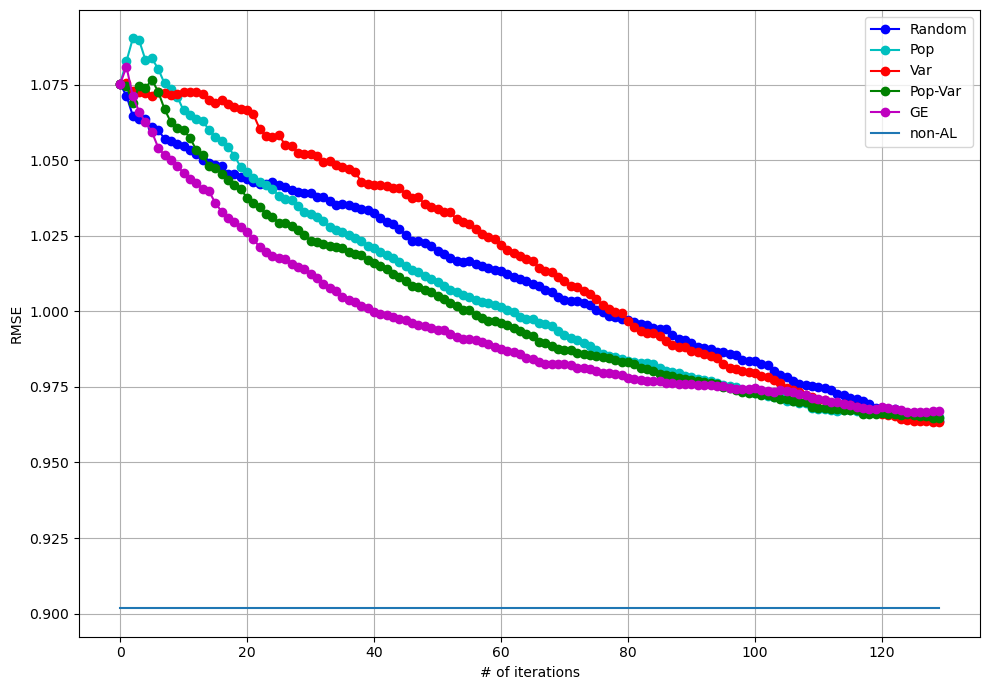

In [137]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

# y_axis = list(range(0, dataset.item_n, w))
# y_axis = list(range(0, results[i][1]['rmse']))


for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(list(range(0, len(results[i][1]['rmse']))), results[i][1]['rmse'], m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
    

ax.plot(list(range(0, len(results[0][1]['rmse']))), [fin_acc]*len(list(range(0, len(results[0][1]['rmse'])))),'-', label='non-AL')   
# ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all-tr')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('Non-personalized AL Strategies')

# plt.show()
plt.savefig('./outputs/rmse_exp2_iter4.png', dpi=300)

### RMSE difference

In [138]:
# results[0][1].keys()

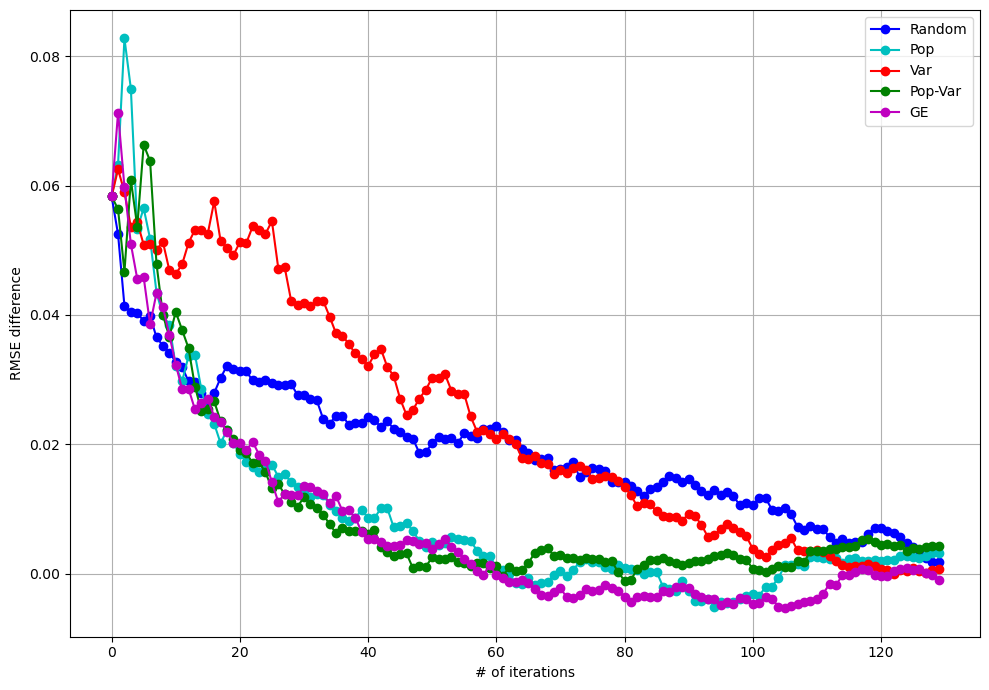

In [139]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(list(range(0, len(results[i][1]['rmse']))), rmse_diff, m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')

# plt.show()
plt.savefig('./outputs/rmse_diff_exp2_iter4.png', dpi=300)

### SEP RMSE 

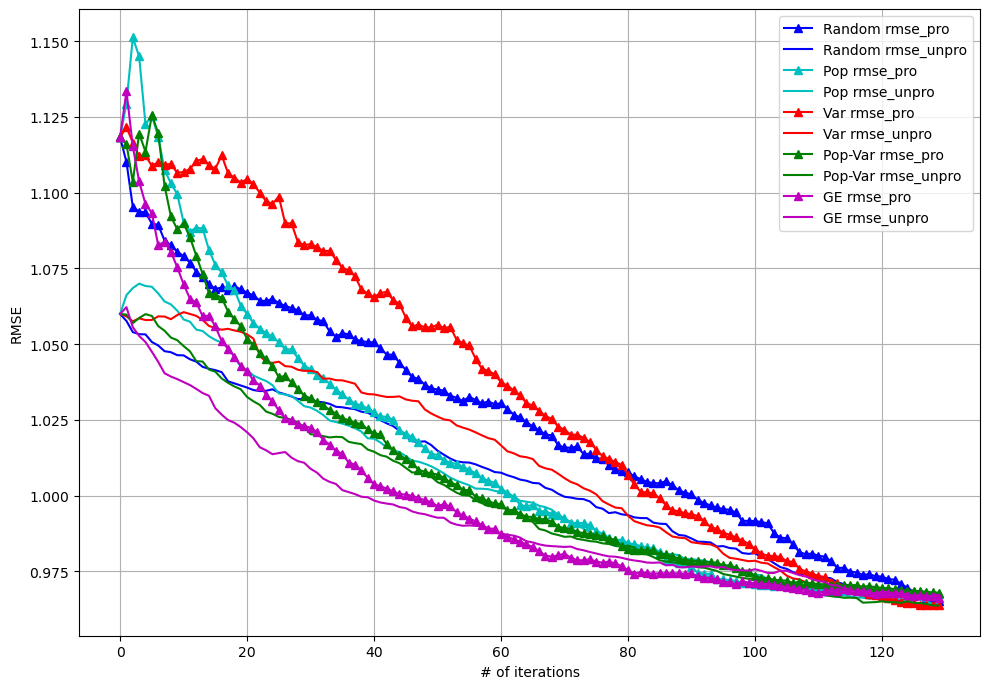

In [140]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))
list(range(0, len(results[i][1]['rmse'])))


for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['rmse_pro']))), results[i][1]['rmse_pro'], m+'^', label=label_d[results[i][0]]+' rmse_pro')
    ax.plot(list(range(0, len(results[i][1]['rmse_unpro']))), results[i][1]['rmse_unpro'], m, label=label_d[results[i][0]]+' rmse_unpro')
    # ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    # ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('RMSE Plors for Pro & Unpro')
# plt.show()
plt.savefig('./outputs/rmse_sep_exp2_iter4.png', dpi=300)

### pro/Unpro Count

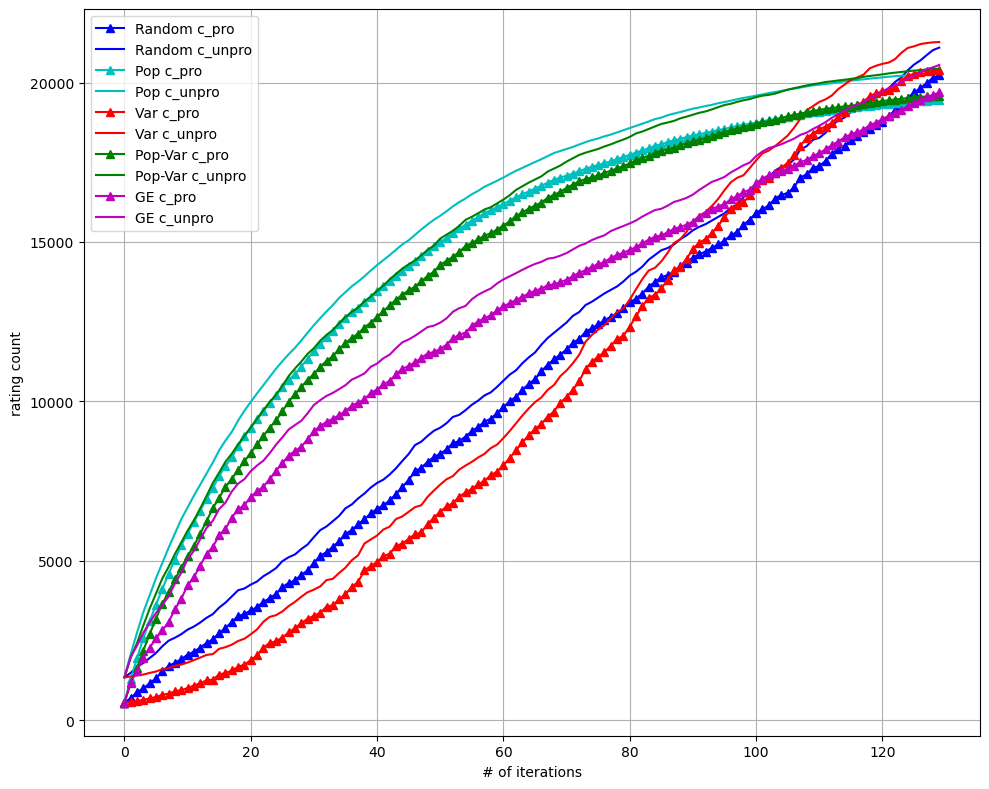

In [141]:
fig, ax = plt.subplots(figsize=(10, 8))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

# y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['c_pro']))), results[i][1]['c_pro'], m+'^', label=label_d[results[i][0]]+' c_pro')
    ax.plot(list(range(0, len(results[i][1]['c_unpro']))), results[i][1]['c_unpro'], m, label=label_d[results[i][0]]+' c_unpro')

    
#     ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
#     ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('rating count')
# plt.title('Pro & Unpro Counts')
# plt.show()
plt.savefig('./outputs/c_sep_exp2_iter4.png', dpi=300)

# 3. same ratio known_df / same ratio picking / normal test

In [142]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(tr_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        if i_indx%100. == 0.:
            print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]
            
            
            # filtering for equal proportions
            chosen_df = tr_df[tr_df['item'].isin(chosen_is)]
            
            pro_chosen_df = chosen_df[chosen_df['user'].isin(pro_users_index)]
            
            p_c = pro_chosen_df.shape[0] # count of how many female ratings
            
            # select as many male ratings as women's ratings
            unpro_chosen_df = chosen_df[~chosen_df['user'].isin(pro_users_index)][:p_c]

            
            print(p_c, unpro_chosen_df.shape[0])
            
            
            tr_iter = pd.concat([tr_iter, 
                                pro_chosen_df,
                                unpro_chosen_df]).drop_duplicates()

            # Sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#             tr_iter = pd.concat([tr_iter, 
#                                   tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()
        
        else:
            tr_iter = knw_df

 
            
        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])
        
        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    
    


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}

#     strtgs = {'ran':shuffled_i_ran}
    

    
    #------------------------ test set & algo & window ---------------------
    # the known set, a part of the training set
    # known_n = 0.02
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    initial_train_df_rat = initial_train_df[(initial_train_df['user']).isin(unpro_users_index + random.sample(unpro_users_index, len(pro_users_index)))]
    known_df = initial_train_df_rat
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    w = 10   # window of w items
    
    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=30)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))


while loop:   0%|          | 0/1299 [00:00<?, ?it/s]

sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...






while loop:   0%|          | 1/1299 [00:00<04:09,  5.21it/s]

28665169   28631665757169
 

 631757



while loop:   0%|          | 2/1299 [00:00<04:08,  5.22it/s]

34 34


while loop:   0%|          | 2/1299 [00:00<04:17,  5.03it/s]

117 117


while loop:   0%|          | 2/1299 [00:00<04:46,  4.52it/s]

489 368489 
368


while loop:   0%|          | 2/1299 [00:00<04:52,  4.44it/s]

686 686


while loop:   0%|          | 3/1299 [00:00<04:10,  5.18it/s]

28 28


while loop:   0%|          | 3/1299 [00:00<04:26,  4.86it/s]

181 181


while loop:   0%|          | 3/1299 [00:00<05:16,  4.09it/s]

412 

while loop:   0%|          | 3/1299 [00:00<05:19,  4.06it/s]

412
574 574


while loop:   0%|          | 3/1299 [00:00<05:39,  3.82it/s]

661 661


while loop:   0%|          | 4/1299 [00:00<04:12,  5.13it/s]

54 54


while loop:   0%|          | 4/1299 [00:00<04:38,  4.64it/s]

63 63


while loop:   0%|          | 4/1299 [00:01<05:48,  3.71it/s]

337 337


while loop:   0%|          | 4/1299 [00:01<05:57,  3.63it/s]

542 542


while loop:   0%|          | 4/1299 [00:01<06:26,  3.35it/s]

547 547


while loop:   0%|          | 5/1299 [00:01<05:49,  3.71it/s]

44 44


while loop:   0%|          | 5/1299 [00:01<06:22,  3.39it/s]

140 140


while loop:   0%|          | 6/1299 [00:01<05:20,  4.03it/s]

76 76


while loop:   0%|          | 6/1299 [00:01<06:00,  3.59it/s]

162 162


while loop:   0%|          | 5/1299 [00:01<07:47,  2.77it/s]

294 294


while loop:   0%|          | 5/1299 [00:01<08:15,  2.61it/s]

33 33
483 483


while loop:   0%|          | 5/1299 [00:01<08:46,  2.46it/s]

544 544


while loop:   1%|          | 7/1299 [00:01<05:53,  3.65it/s]

173 173


while loop:   1%|          | 8/1299 [00:01<04:57,  4.33it/s]

78 78


while loop:   0%|          | 6/1299 [00:01<07:45,  2.78it/s]

262 262


while loop:   0%|          | 6/1299 [00:02<08:25,  2.56it/s]

491 491


while loop:   1%|          | 8/1299 [00:02<05:55,  3.63it/s]

157 157


while loop:   0%|          | 6/1299 [00:02<09:06,  2.37it/s]

498 498


while loop:   1%|          | 9/1299 [00:02<05:54,  3.64it/s]

39 39


while loop:   1%|          | 7/1299 [00:02<07:55,  2.72it/s]

267 267


while loop:   1%|          | 10/1299 [00:02<05:35,  3.84it/s]

sample 100-th item...
65 65


while loop:   1%|          | 7/1299 [00:02<08:48,  2.44it/s]

371 371


while loop:   1%|          | 9/1299 [00:02<07:07,  3.02it/s]

161 161


while loop:   1%|          | 7/1299 [00:02<09:34,  2.25it/s]

488 488


while loop:   1%|          | 11/1299 [00:02<05:26,  3.94it/s]

79 79


while loop:   1%|          | 8/1299 [00:02<08:08,  2.64it/s]

414 414


while loop:   1%|          | 10/1299 [00:02<06:54,  3.11it/s]

sample 100-th item...
108 108


while loop:   1%|          | 12/1299 [00:02<05:20,  4.02it/s]

83 83


while loop:   1%|          | 8/1299 [00:02<09:17,  2.32it/s]

419 419


while loop:   1%|          | 11/1299 [00:03<06:53,  3.11it/s]

197 197


while loop:   1%|          | 8/1299 [00:03<10:10,  2.12it/s]

452 452


while loop:   1%|          | 13/1299 [00:03<06:16,  3.42it/s]

344 344
87 87


while loop:   1%|          | 12/1299 [00:03<06:55,  3.09it/s]

100 100


while loop:   1%|          | 14/1299 [00:03<05:59,  3.57it/s]

29 29


while loop:   1%|          | 9/1299 [00:03<10:51,  1.98it/s]

368 368


while loop:   1%|          | 10/1299 [00:03<09:42,  2.21it/s]

sample 100-th item...
440 440


while loop:   1%|          | 15/1299 [00:03<05:52,  3.64it/s]

168 168


while loop:   1%|          | 13/1299 [00:03<07:03,  3.04it/s]

94 94


while loop:   1%|          | 9/1299 [00:03<11:51,  1.81it/s]

457 457


while loop:   1%|          | 16/1299 [00:04<05:50,  3.66it/s]

51 51


while loop:   1%|          | 10/1299 [00:04<11:04,  1.94it/s]

sample 100-th item...
378 378


while loop:   1%|          | 11/1299 [00:04<10:19,  2.08it/s]

261 261


while loop:   1%|          | 14/1299 [00:04<08:09,  2.62it/s]

187 187


while loop:   1%|▏         | 17/1299 [00:04<05:50,  3.66it/s]

79 79


while loop:   1%|          | 10/1299 [00:04<12:11,  1.76it/s]

sample 100-th item...
374 374


while loop:   1%|          | 15/1299 [00:04<08:03,  2.65it/s]

308 308


while loop:   1%|          | 11/1299 [00:04<11:24,  1.88it/s]

334 334


while loop:   1%|▏         | 18/1299 [00:04<06:52,  3.11it/s]

118 118


while loop:   1%|          | 12/1299 [00:04<10:34,  2.03it/s]

380 380


while loop:   1%|          | 16/1299 [00:05<08:06,  2.64it/s]

169

while loop:   1%|▏         | 19/1299 [00:05<06:39,  3.21it/s]

 169
73 73


while loop:   1%|          | 11/1299 [00:05<12:35,  1.70it/s]

377 377


while loop:   1%|          | 12/1299 [00:05<11:48,  1.82it/s]

391 391


while loop:   2%|▏         | 20/1299 [00:05<06:32,  3.26it/s]

sample 200-th item...364
 364
137 137


while loop:   1%|▏         | 17/1299 [00:05<08:17,  2.58it/s]

80 80


while loop:   2%|▏         | 21/1299 [00:05<06:32,  3.26it/s]

156 156


while loop:   1%|          | 12/1299 [00:05<13:06,  1.64it/s]

365 365


while loop:   1%|          | 13/1299 [00:05<12:18,  1.74it/s]

404 404


while loop:   2%|▏         | 22/1299 [00:05<06:37,  3.21it/s]

250 250


while loop:   1%|▏         | 18/1299 [00:06<09:25,  2.26it/s]

168 168


while loop:   1%|          | 14/1299 [00:06<12:18,  1.74it/s]

235 235


while loop:   1%|▏         | 19/1299 [00:06<09:18,  2.29it/s]

103 103


while loop:   2%|▏         | 23/1299 [00:06<07:42,  2.76it/s]

158 158


while loop:   1%|          | 13/1299 [00:06<14:39,  1.46it/s]

371 371


while loop:   1%|          | 15/1299 [00:06<12:26,  1.72it/s]

375 375


while loop:   1%|          | 14/1299 [00:06<13:50,  1.55it/s]

415 415


while loop:   2%|▏         | 24/1299 [00:06<07:38,  2.78it/s]

53 53


while loop:   2%|▏         | 20/1299 [00:06<09:15,  2.30it/s]

sample 200-th item...
125 125


while loop:   2%|▏         | 25/1299 [00:07<07:36,  2.79it/s]

124 124


while loop:   1%|          | 16/1299 [00:07<12:44,  1.68it/s]

204 204


while loop:   2%|▏         | 21/1299 [00:07<09:16,  2.30it/s]

144 144


while loop:   1%|          | 14/1299 [00:07<14:51,  1.44it/s]

352 352


while loop:   1%|          | 15/1299 [00:07<14:07,  1.52it/s]

336 336


while loop:   2%|▏         | 26/1299 [00:07<07:39,  2.77it/s]

169 169


while loop:   2%|▏         | 22/1299 [00:07<09:22,  2.27it/s]

119 119


while loop:   1%|▏         | 17/1299 [00:07<13:03,  1.64it/s]

365 365


while loop:   2%|▏         | 27/1299 [00:08<08:47,  2.41it/s]

137 137


while loop:   1%|          | 15/1299 [00:08<15:12,  1.41it/s]

387 387


while loop:   1%|          | 16/1299 [00:08<14:30,  1.47it/s]

350 350


while loop:   2%|▏         | 23/1299 [00:08<10:30,  2.02it/s]

266 266


while loop:   2%|▏         | 28/1299 [00:08<08:37,  2.46it/s]

164 164


while loop:   1%|▏         | 18/1299 [00:08<14:24,  1.48it/s]

255 255


while loop:   2%|▏         | 24/1299 [00:08<10:26,  2.03it/s]

145 145
141 141


while loop:   1%|          | 16/1299 [00:08<15:37,  1.37it/s]

323 323


while loop:   1%|▏         | 17/1299 [00:08<14:55,  1.43it/s]

259 259


while loop:   2%|▏         | 30/1299 [00:09<08:40,  2.44it/s]

sample 300-th item...
89 89


while loop:   2%|▏         | 25/1299 [00:09<10:26,  2.03it/s]

191 191


while loop:   1%|▏         | 19/1299 [00:09<14:28,  1.47it/s]

141 141


while loop:   1%|▏         | 17/1299 [00:09<16:06,  1.33it/s]

274 274


while loop:   1%|▏         | 18/1299 [00:09<16:22,  1.30it/s]

300 300


while loop:   2%|▏         | 26/1299 [00:09<10:34,  2.01it/s]

102166  166102



while loop:   2%|▏         | 20/1299 [00:10<14:36,  1.46it/s]

sample 200-th item...
259 259


while loop:   2%|▏         | 32/1299 [00:10<09:36,  2.20it/s]

203 203


while loop:   2%|▏         | 27/1299 [00:10<11:43,  1.81it/s]

70 70


while loop:   1%|▏         | 19/1299 [00:10<16:30,  1.29it/s]

273 273


while loop:   1%|▏         | 18/1299 [00:10<17:33,  1.22it/s]

366 366


while loop:   3%|▎         | 33/1299 [00:10<09:33,  2.21it/s]

42 42


while loop:   2%|▏         | 21/1299 [00:10<14:50,  1.44it/s]

183 183


while loop:   2%|▏         | 28/1299 [00:11<11:31,  1.84it/s]

144 144


while loop:   3%|▎         | 34/1299 [00:11<09:32,  2.21it/s]

194 194


while loop:   2%|▏         | 20/1299 [00:11<16:44,  1.27it/s]

sample 200-th item...
273 273


while loop:   1%|▏         | 19/1299 [00:11<17:43,  1.20it/s]

315 315


while loop:   2%|▏         | 29/1299 [00:11<11:29,  1.84it/s]

77 77


while loop:   3%|▎         | 35/1299 [00:11<09:40,  2.18it/s]

174 174


while loop:   2%|▏         | 22/1299 [00:11<16:00,  1.33it/s]

153 153


while loop:   2%|▏         | 30/1299 [00:12<11:31,  1.83it/s]

sample 300-th item...
184 184


while loop:   2%|▏         | 21/1299 [00:12<17:02,  1.25it/s]

280 280


while loop:   3%|▎         | 36/1299 [00:12<10:44,  1.96it/s]

239 239


while loop:   2%|▏         | 20/1299 [00:12<17:59,  1.18it/s]

sample 200-th item...
282 282


while loop:   2%|▏         | 23/1299 [00:12<15:58,  1.33it/s]

245 245


while loop:   3%|▎         | 37/1299 [00:12<10:42,  1.96it/s]

158 158


while loop:   2%|▏         | 31/1299 [00:12<12:37,  1.67it/s]

135 135


while loop:   2%|▏         | 22/1299 [00:13<18:18,  1.16it/s]

270 270


while loop:   2%|▏         | 24/1299 [00:13<16:04,  1.32it/s]

276 276


while loop:   2%|▏         | 21/1299 [00:13<18:25,  1.16it/s]

273 273


while loop:   3%|▎         | 38/1299 [00:13<10:44,  1.96it/s]

377 377


while loop:   2%|▏         | 32/1299 [00:13<12:26,  1.70it/s]

79 79


while loop:   3%|▎         | 39/1299 [00:13<10:58,  1.91it/s]

135 135


while loop:   3%|▎         | 33/1299 [00:14<12:22,  1.70it/s]

291 291


while loop:   2%|▏         | 25/1299 [00:14<16:15,  1.31it/s]

236 236


while loop:   2%|▏         | 23/1299 [00:14<18:23,  1.16it/s]

263 263


while loop:   2%|▏         | 22/1299 [00:14<18:48,  1.13it/s]

261 261


while loop:   3%|▎         | 40/1299 [00:14<11:10,  1.88it/s]

sample 400-th item...
128 128


while loop:   3%|▎         | 34/1299 [00:14<12:28,  1.69it/s]

178 178


while loop:   2%|▏         | 26/1299 [00:14<16:31,  1.28it/s]

251 251


while loop:   2%|▏         | 24/1299 [00:15<18:35,  1.14it/s]

230 230


while loop:   3%|▎         | 41/1299 [00:15<12:17,  1.71it/s]

194 194


while loop:   3%|▎         | 35/1299 [00:15<12:36,  1.67it/s]

226 226


while loop:   2%|▏         | 23/1299 [00:15<20:10,  1.05it/s]

271 271


while loop:   3%|▎         | 42/1299 [00:15<12:16,  1.71it/s]

92 92


while loop:   2%|▏         | 27/1299 [00:15<17:49,  1.19it/s]

146 146


while loop:   2%|▏         | 25/1299 [00:15<18:52,  1.12it/s]

290 290


while loop:   3%|▎         | 36/1299 [00:16<13:51,  1.52it/s]

109 109


while loop:   2%|▏         | 24/1299 [00:16<20:15,  1.05it/s]

261 261


while loop:   3%|▎         | 43/1299 [00:16<12:18,  1.70it/s]

242 242


while loop:   3%|▎         | 37/1299 [00:16<13:43,  1.53it/s]

122 122


while loop:   2%|▏         | 28/1299 [00:16<17:51,  1.19it/s]

134 134


while loop:   2%|▏         | 26/1299 [00:16<19:10,  1.11it/s]

313 313


while loop:   3%|▎         | 44/1299 [00:16<12:24,  1.68it/s]

83 83


while loop:   2%|▏         | 25/1299 [00:17<20:26,  1.04it/s]

237 237


while loop:   3%|▎         | 38/1299 [00:17<13:44,  1.53it/s]

128 128


while loop:   2%|▏         | 29/1299 [00:17<17:55,  1.18it/s]

242 242


while loop:   3%|▎         | 45/1299 [00:17<13:28,  1.55it/s]

146 146


while loop:   2%|▏         | 27/1299 [00:18<20:27,  1.04it/s]

247 247


while loop:   3%|▎         | 39/1299 [00:18<13:47,  1.52it/s]

288 288


while loop:   2%|▏         | 26/1299 [00:18<20:45,  1.02it/s]

228 228


while loop:   4%|▎         | 46/1299 [00:18<13:43,  1.52it/s]

147 147


while loop:   2%|▏         | 30/1299 [00:18<18:05,  1.17it/s]

sample 300-th item...
269 269


while loop:   3%|▎         | 40/1299 [00:18<13:56,  1.51it/s]

sample 400-th item...
195 195


while loop:   2%|▏         | 28/1299 [00:18<20:33,  1.03it/s]

221 221


while loop:   4%|▎         | 47/1299 [00:19<13:36,  1.53it/s]

62 62


while loop:   2%|▏         | 31/1299 [00:19<18:22,  1.15it/s]

153 153


while loop:   2%|▏         | 27/1299 [00:19<21:59,  1.04s/it]

203 203


while loop:   3%|▎         | 41/1299 [00:19<15:09,  1.38it/s]

175 175


while loop:   4%|▎         | 48/1299 [00:19<13:32,  1.54it/s]

267 267


while loop:   2%|▏         | 29/1299 [00:20<20:47,  1.02it/s]

243 243


while loop:   3%|▎         | 42/1299 [00:20<15:07,  1.39it/s]

259 259


while loop:   2%|▏         | 32/1299 [00:20<19:36,  1.08it/s]

139 139


while loop:   4%|▍         | 49/1299 [00:20<14:39,  1.42it/s]

204 204


while loop:   2%|▏         | 28/1299 [00:20<21:58,  1.04s/it]

240 240


while loop:   2%|▏         | 30/1299 [00:21<21:00,  1.01it/s]

sample 300-th item...
183 183

while loop:   3%|▎         | 43/1299 [00:21<15:12,  1.38it/s]


200 200


while loop:   4%|▍         | 50/1299 [00:21<14:29,  1.44it/s]

sample 500-th item...
190 190


while loop:   3%|▎         | 33/1299 [00:21<19:29,  1.08it/s]

95 95


while loop:   2%|▏         | 29/1299 [00:21<22:06,  1.04s/it]

253 253


while loop:   3%|▎         | 44/1299 [00:21<15:23,  1.36it/s]

156 156


while loop:   4%|▍         | 51/1299 [00:21<14:29,  1.43it/s]

172 172


while loop:   2%|▏         | 31/1299 [00:22<22:15,  1.05s/it]

237 237


while loop:   3%|▎         | 34/1299 [00:22<19:27,  1.08it/s]

120 120


while loop:   4%|▍         | 52/1299 [00:22<14:35,  1.42it/s]

100 100


while loop:   2%|▏         | 30/1299 [00:22<22:34,  1.07s/it]

sample 300-th item...


while loop:   3%|▎         | 45/1299 [00:22<16:36,  1.26it/s]

242 242
187 187


while loop:   3%|▎         | 35/1299 [00:23<19:31,  1.08it/s]

125 125


while loop:   2%|▏         | 32/1299 [00:23<22:13,  1.05s/it]

186 186


while loop:   4%|▍         | 53/1299 [00:23<14:41,  1.41it/s]

210 210


while loop:   4%|▎         | 46/1299 [00:23<16:30,  1.26it/s]

110 110


while loop:   2%|▏         | 31/1299 [00:23<22:48,  1.08s/it]

225 225


while loop:   4%|▍         | 54/1299 [00:24<15:47,  1.31it/s]

132 132


while loop:   3%|▎         | 36/1299 [00:24<20:33,  1.02it/s]

177 177


while loop:   4%|▎         | 47/1299 [00:24<16:32,  1.26it/s]

135 135


while loop:   3%|▎         | 33/1299 [00:24<22:21,  1.06s/it]

157 157


while loop:   4%|▍         | 55/1299 [00:24<15:41,  1.32it/s]

117 117


while loop:   2%|▏         | 32/1299 [00:25<24:00,  1.14s/it]

216 216


while loop:   4%|▎         | 48/1299 [00:25<16:34,  1.26it/s]

115 115


while loop:   3%|▎         | 37/1299 [00:25<20:24,  1.03it/s]

97 97


while loop:   3%|▎         | 34/1299 [00:25<22:27,  1.07s/it]

219 219


while loop:   4%|▍         | 56/1299 [00:25<15:41,  1.32it/s]

141 141


while loop:   4%|▍         | 49/1299 [00:25<16:38,  1.25it/s]

156 156


while loop:   3%|▎         | 38/1299 [00:26<20:23,  1.03it/s]

105 105


while loop:   3%|▎         | 33/1299 [00:26<23:58,  1.14s/it]

206 206


while loop:   4%|▍         | 57/1299 [00:26<15:45,  1.31it/s]

114 114


while loop:   3%|▎         | 35/1299 [00:26<22:40,  1.08s/it]

199 199


while loop:   4%|▍         | 50/1299 [00:26<17:42,  1.18it/s]

sample 500-th item...
151 151


while loop:   3%|▎         | 39/1299 [00:27<20:22,  1.03it/s]

213 213


while loop:   3%|▎         | 34/1299 [00:27<24:03,  1.14s/it]

228 228


while loop:   4%|▍         | 58/1299 [00:27<16:43,  1.24it/s]

186 186


while loop:   4%|▍         | 51/1299 [00:27<17:36,  1.18it/s]

170 170


while loop:   3%|▎         | 36/1299 [00:27<23:49,  1.13s/it]

158 158


while loop:   3%|▎         | 40/1299 [00:28<20:33,  1.02it/s]

sample 400-th item...
103 103


while loop:   5%|▍         | 59/1299 [00:28<16:36,  1.24it/s]

111 111


while loop:   3%|▎         | 35/1299 [00:28<24:18,  1.15s/it]

123 186123 
186


while loop:   3%|▎         | 37/1299 [00:28<23:46,  1.13s/it]

138 138


while loop:   5%|▍         | 60/1299 [00:29<16:34,  1.25it/s]

sample 600-th item...
211 211


while loop:   3%|▎         | 41/1299 [00:29<21:33,  1.03s/it]

168 168


while loop:   4%|▍         | 53/1299 [00:29<17:41,  1.17it/s]

196 196


while loop:   5%|▍         | 61/1299 [00:29<16:40,  1.24it/s]

227 227


while loop:   3%|▎         | 36/1299 [00:29<25:24,  1.21s/it]

187 187


while loop:   3%|▎         | 38/1299 [00:30<23:51,  1.14s/it]

194 194


while loop:   3%|▎         | 42/1299 [00:30<21:28,  1.02s/it]

115 115


while loop:   4%|▍         | 54/1299 [00:30<18:50,  1.10it/s]

153 153


while loop:   5%|▍         | 62/1299 [00:30<17:45,  1.16it/s]

247 247


while loop:   3%|▎         | 37/1299 [00:31<25:19,  1.20s/it]

151 151


while loop:   3%|▎         | 39/1299 [00:31<23:58,  1.14s/it]

157 157


while loop:   4%|▍         | 55/1299 [00:31<18:41,  1.11it/s]

245 245


while loop:   3%|▎         | 43/1299 [00:31<21:30,  1.03s/it]

205 205


while loop:   5%|▍         | 63/1299 [00:31<17:41,  1.16it/s]

255 255


while loop:   4%|▍         | 56/1299 [00:32<18:45,  1.10it/s]

138 138


while loop:   3%|▎         | 38/1299 [00:32<25:22,  1.21s/it]

169 169


while loop:   3%|▎         | 40/1299 [00:32<24:06,  1.15s/it]

sample 400-th item...
187 187


while loop:   3%|▎         | 44/1299 [00:32<21:33,  1.03s/it]

188 188


while loop:   5%|▍         | 64/1299 [00:32<17:47,  1.16it/s]

228 228


while loop:   4%|▍         | 57/1299 [00:33<18:48,  1.10it/s]

110 110


while loop:   5%|▌         | 65/1299 [00:33<17:58,  1.14it/s]

203 203


while loop:   3%|▎         | 45/1299 [00:33<21:43,  1.04s/it]

89 89


while loop:   3%|▎         | 39/1299 [00:33<25:33,  1.22s/it]

182 182


while loop:   3%|▎         | 41/1299 [00:33<25:15,  1.20s/it]

170 170


while loop:   4%|▍         | 58/1299 [00:34<19:55,  1.04it/s]

201 201


while loop:   5%|▌         | 66/1299 [00:34<18:18,  1.12it/s]

149 149


while loop:   4%|▎         | 46/1299 [00:34<22:46,  1.09s/it]

118 118


while loop:   3%|▎         | 42/1299 [00:34<25:12,  1.20s/it]

198 198


while loop:   3%|▎         | 40/1299 [00:34<26:39,  1.27s/it]

sample 400-th item...
175 175


while loop:   5%|▍         | 59/1299 [00:35<19:45,  1.05it/s]

178 178


while loop:   5%|▌         | 67/1299 [00:35<19:24,  1.06it/s]

243 243


while loop:   4%|▎         | 47/1299 [00:35<22:44,  1.09s/it]

139 139


while loop:   3%|▎         | 43/1299 [00:36<25:18,  1.21s/it]

177 177


while loop:   5%|▍         | 60/1299 [00:36<19:49,  1.04it/s]

sample 600-th item...
153 153


while loop:   3%|▎         | 41/1299 [00:36<26:33,  1.27s/it]

159 159


while loop:   5%|▌         | 68/1299 [00:36<19:21,  1.06it/s]

155 155


while loop:   4%|▎         | 48/1299 [00:36<22:40,  1.09s/it]

141 141


while loop:   5%|▍         | 61/1299 [00:37<19:52,  1.04it/s]

138 138


while loop:   5%|▌         | 69/1299 [00:37<19:25,  1.06it/s]

282 282


while loop:   3%|▎         | 44/1299 [00:37<25:25,  1.22s/it]

167 167


while loop:   3%|▎         | 42/1299 [00:37<26:32,  1.27s/it]

158 158


while loop:   4%|▍         | 49/1299 [00:37<22:41,  1.09s/it]

48 48


while loop:   5%|▍         | 62/1299 [00:38<19:57,  1.03it/s]

108 108


while loop:   5%|▌         | 70/1299 [00:38<19:36,  1.04it/s]

sample 700-th item...
184 184


while loop:   3%|▎         | 43/1299 [00:38<26:39,  1.27s/it]

176 176


while loop:   3%|▎         | 45/1299 [00:38<26:32,  1.27s/it]

134 134


while loop:   4%|▍         | 50/1299 [00:39<23:42,  1.14s/it]

sample 500-th item...
96 96


while loop:   5%|▍         | 63/1299 [00:39<21:08,  1.03s/it]

149 149


while loop:   5%|▌         | 71/1299 [00:39<20:50,  1.02s/it]

231 231


while loop:   4%|▎         | 46/1299 [00:40<26:24,  1.26s/it]

122 122


while loop:   3%|▎         | 44/1299 [00:40<26:48,  1.28s/it]

166 166


while loop:   5%|▍         | 64/1299 [00:40<21:00,  1.02s/it]

120 120


while loop:   4%|▍         | 51/1299 [00:40<23:38,  1.14s/it]

139 139


while loop:   6%|▌         | 72/1299 [00:40<20:46,  1.02s/it]

268 268


while loop:   4%|▎         | 47/1299 [00:41<26:22,  1.26s/it]

164 164


while loop:   5%|▌         | 65/1299 [00:41<20:57,  1.02s/it]

184 184


while loop:   4%|▍         | 52/1299 [00:41<23:33,  1.13s/it]

210 210


while loop:   3%|▎         | 45/1299 [00:41<27:54,  1.34s/it]

132 132


while loop:   6%|▌         | 73/1299 [00:41<20:54,  1.02s/it]

418 418


while loop:   5%|▌         | 66/1299 [00:42<20:58,  1.02s/it]

155 155


while loop:   4%|▎         | 48/1299 [00:42<26:31,  1.27s/it]

181 181


while loop:   4%|▍         | 53/1299 [00:42<23:35,  1.14s/it]

115 115


while loop:   6%|▌         | 74/1299 [00:42<21:37,  1.06s/it]

216 216


while loop:   4%|▎         | 46/1299 [00:42<27:48,  1.33s/it]

175 175


while loop:   5%|▌         | 67/1299 [00:43<22:01,  1.07s/it]

68 68


while loop:   6%|▌         | 75/1299 [00:43<21:51,  1.07s/it]

170 170


while loop:   4%|▍         | 54/1299 [00:43<24:53,  1.20s/it]

69 69


while loop:   4%|▍         | 49/1299 [00:44<27:31,  1.32s/it]

133 133


while loop:   4%|▎         | 47/1299 [00:44<27:56,  1.34s/it]

167 167


while loop:   5%|▌         | 68/1299 [00:44<22:00,  1.07s/it]

77 77


while loop:   6%|▌         | 76/1299 [00:45<23:00,  1.13s/it]

142 142


while loop:   4%|▍         | 55/1299 [00:45<24:37,  1.19s/it]

216 216


while loop:   4%|▍         | 50/1299 [00:45<27:20,  1.31s/it]

sample 500-th item...
226 226


while loop:   4%|▎         | 48/1299 [00:45<28:00,  1.34s/it]

163 163


while loop:   5%|▌         | 69/1299 [00:45<21:50,  1.07s/it]

82 82


while loop:   6%|▌         | 77/1299 [00:46<22:54,  1.12s/it]

215 215


while loop:   4%|▍         | 56/1299 [00:46<24:32,  1.18s/it]

143 143


while loop:   4%|▍         | 51/1299 [00:46<27:22,  1.32s/it]

125 125


while loop:   5%|▌         | 70/1299 [00:46<21:47,  1.06s/it]

sample 700-th item...
161 161


while loop:   4%|▍         | 49/1299 [00:47<29:09,  1.40s/it]

148 148


while loop:   6%|▌         | 78/1299 [00:47<22:55,  1.13s/it]

212 212


while loop:   4%|▍         | 57/1299 [00:47<24:33,  1.19s/it]

107 107


while loop:   5%|▌         | 71/1299 [00:47<21:55,  1.07s/it]

128 128


while loop:   4%|▍         | 52/1299 [00:47<27:32,  1.32s/it]

126 126


while loop:   6%|▌         | 79/1299 [00:48<23:07,  1.14s/it]

113 113


while loop:   4%|▍         | 50/1299 [00:48<28:58,  1.39s/it]

sample 500-th item...
126 126


while loop:   4%|▍         | 58/1299 [00:48<24:43,  1.20s/it]

95 95


while loop:   6%|▌         | 72/1299 [00:49<22:56,  1.12s/it]

186 186


while loop:   4%|▍         | 53/1299 [00:49<27:37,  1.33s/it]

157 157


while loop:   6%|▌         | 80/1299 [00:49<24:07,  1.19s/it]

sample 800-th item...
289 289


while loop:   4%|▍         | 51/1299 [00:49<28:56,  1.39s/it]

144 144


while loop:   5%|▍         | 59/1299 [00:50<25:47,  1.25s/it]

163 163


while loop:   6%|▌         | 73/1299 [00:50<22:56,  1.12s/it]

123 123


while loop:   4%|▍         | 54/1299 [00:50<28:42,  1.38s/it]

192 192


while loop:   6%|▌         | 81/1299 [00:50<24:10,  1.19s/it]

337 337


while loop:   4%|▍         | 52/1299 [00:51<29:03,  1.40s/it]

158 158


while loop:   5%|▍         | 60/1299 [00:51<25:34,  1.24s/it]

sample 600-th item...
126 126
126 126


while loop:   6%|▋         | 82/1299 [00:52<24:17,  1.20s/it]

325 325


while loop:   4%|▍         | 55/1299 [00:52<28:36,  1.38s/it]

100 100


while loop:   6%|▌         | 75/1299 [00:52<22:52,  1.12s/it]

164 164


while loop:   5%|▍         | 61/1299 [00:52<25:32,  1.24s/it]

103 103


while loop:   4%|▍         | 53/1299 [00:52<29:06,  1.40s/it]

135 135


while loop:   6%|▋         | 83/1299 [00:53<24:30,  1.21s/it]

270 270


while loop:   4%|▍         | 56/1299 [00:53<28:35,  1.38s/it]

114 114


while loop:   6%|▌         | 76/1299 [00:53<23:49,  1.17s/it]

170 170


while loop:   5%|▍         | 62/1299 [00:53<25:37,  1.24s/it]

100 100


while loop:   4%|▍         | 54/1299 [00:54<30:08,  1.45s/it]

117 117


while loop:   6%|▋         | 84/1299 [00:54<25:50,  1.28s/it]

88 88


while loop:   6%|▌         | 77/1299 [00:54<23:44,  1.17s/it]

155 155


while loop:   4%|▍         | 57/1299 [00:54<28:43,  1.39s/it]

125 125


while loop:   5%|▍         | 63/1299 [00:55<26:40,  1.29s/it]

104 104


while loop:   4%|▍         | 55/1299 [00:55<29:58,  1.45s/it]

135 135


while loop:   6%|▌         | 78/1299 [00:56<23:46,  1.17s/it]

143 143


while loop:   7%|▋         | 85/1299 [00:56<25:55,  1.28s/it]

204 204


while loop:   4%|▍         | 58/1299 [00:56<28:45,  1.39s/it]

72 72


while loop:   5%|▍         | 64/1299 [00:56<26:23,  1.28s/it]

104 104


while loop:   4%|▍         | 56/1299 [00:57<30:04,  1.45s/it]

110 110


while loop:   6%|▌         | 79/1299 [00:57<23:50,  1.17s/it]

111 111


while loop:   7%|▋         | 86/1299 [00:57<25:56,  1.28s/it]

281 281


while loop:   5%|▌         | 65/1299 [00:57<26:16,  1.28s/it]

90 90


while loop:   5%|▍         | 59/1299 [00:57<29:44,  1.44s/it]

121 121


while loop:   6%|▌         | 80/1299 [00:58<24:53,  1.23s/it]

sample 800-th item...
222 222


while loop:   4%|▍         | 57/1299 [00:58<30:03,  1.45s/it]

130 130


while loop:   7%|▋         | 87/1299 [00:58<26:13,  1.30s/it]

317 317


while loop:   5%|▌         | 66/1299 [00:58<26:21,  1.28s/it]

66 66


while loop:   5%|▍         | 60/1299 [00:59<29:33,  1.43s/it]

sample 600-th item...
123 123


while loop:   6%|▌         | 81/1299 [00:59<24:45,  1.22s/it]

131 131


while loop:   4%|▍         | 58/1299 [01:00<30:06,  1.46s/it]

98 98


while loop:   7%|▋         | 88/1299 [01:00<26:27,  1.31s/it]

115 115


while loop:   5%|▌         | 67/1299 [01:00<26:21,  1.28s/it]

104 104


while loop:   5%|▍         | 61/1299 [01:00<29:36,  1.44s/it]

139 139


while loop:   6%|▋         | 82/1299 [01:00<24:47,  1.22s/it]

168 168


while loop:   7%|▋         | 89/1299 [01:01<27:35,  1.37s/it]

247 247


while loop:   5%|▍         | 59/1299 [01:01<31:04,  1.50s/it]

95 95


while loop:   5%|▌         | 68/1299 [01:01<27:18,  1.33s/it]

29 29


while loop:   5%|▍         | 62/1299 [01:02<29:36,  1.44s/it]

168 168


while loop:   6%|▋         | 83/1299 [01:02<24:54,  1.23s/it]

126 126


while loop:   7%|▋         | 90/1299 [01:02<27:35,  1.37s/it]

sample 900-th item...
322 322


while loop:   5%|▌         | 69/1299 [01:03<27:03,  1.32s/it]

68 68


while loop:   5%|▍         | 60/1299 [01:03<30:54,  1.50s/it]

sample 600-th item...
102 102


while loop:   6%|▋         | 84/1299 [01:03<24:58,  1.23s/it]

173 173


while loop:   5%|▍         | 63/1299 [01:03<30:33,  1.48s/it]

115 115


while loop:   5%|▌         | 70/1299 [01:04<26:54,  1.31s/it]

sample 700-th item...
84 84


while loop:   7%|▋         | 91/1299 [01:04<27:46,  1.38s/it]

201 201


while loop:   5%|▍         | 61/1299 [01:04<30:58,  1.50s/it]

111 111


while loop:   7%|▋         | 85/1299 [01:04<25:58,  1.28s/it]

81 81


while loop:   5%|▍         | 64/1299 [01:05<30:20,  1.47s/it]

115 115


while loop:   5%|▌         | 71/1299 [01:05<26:57,  1.32s/it]

117 117


while loop:   7%|▋         | 92/1299 [01:05<28:05,  1.40s/it]

113 113


while loop:   7%|▋         | 86/1299 [01:06<25:46,  1.27s/it]

182 182


while loop:   5%|▍         | 62/1299 [01:06<30:58,  1.50s/it]

103 103


while loop:   5%|▌         | 65/1299 [01:06<30:17,  1.47s/it]

101 101


while loop:   6%|▌         | 72/1299 [01:07<27:51,  1.36s/it]

113 113


while loop:   7%|▋         | 93/1299 [01:07<29:16,  1.46s/it]

197 197


while loop:   7%|▋         | 87/1299 [01:07<26:02,  1.29s/it]

88 88


while loop:   5%|▍         | 63/1299 [01:07<31:55,  1.55s/it]

95 95


while loop:   5%|▌         | 66/1299 [01:08<30:24,  1.48s/it]

100 100


while loop:   6%|▌         | 73/1299 [01:08<27:44,  1.36s/it]

72 72


while loop:   7%|▋         | 88/1299 [01:08<26:00,  1.29s/it]

190 190


while loop:   7%|▋         | 94/1299 [01:08<29:08,  1.45s/it]

224 224


while loop:   5%|▍         | 64/1299 [01:09<31:41,  1.54s/it]

91 91


while loop:   6%|▌         | 74/1299 [01:09<27:34,  1.35s/it]

114 114


while loop:   5%|▌         | 67/1299 [01:09<31:28,  1.53s/it]

150 150


while loop:   7%|▋         | 89/1299 [01:10<27:02,  1.34s/it]

225 225


while loop:   7%|▋         | 95/1299 [01:10<29:20,  1.46s/it]

276 276


while loop:   5%|▌         | 65/1299 [01:10<31:45,  1.54s/it]

94 94


while loop:   6%|▌         | 75/1299 [01:11<27:36,  1.35s/it]

79 79


while loop:   5%|▌         | 68/1299 [01:11<31:13,  1.52s/it]

96 96


while loop:   7%|▋         | 90/1299 [01:11<26:51,  1.33s/it]

sample 900-th item...
120 120


while loop:   7%|▋         | 96/1299 [01:11<29:27,  1.47s/it]

251 251


while loop:   5%|▌         | 66/1299 [01:12<31:39,  1.54s/it]

90 90


while loop:   6%|▌         | 76/1299 [01:12<27:33,  1.35s/it]

74 74


while loop:   7%|▋         | 91/1299 [01:12<26:48,  1.33s/it]

168 168


while loop:   5%|▌         | 69/1299 [01:12<31:06,  1.52s/it]

95 95


while loop:   7%|▋         | 97/1299 [01:13<30:32,  1.52s/it]

144 144


while loop:   6%|▌         | 77/1299 [01:14<28:35,  1.40s/it]

133 133


while loop:   5%|▌         | 67/1299 [01:14<32:33,  1.59s/it]

99 99


while loop:   7%|▋         | 92/1299 [01:14<27:06,  1.35s/it]

129 129


while loop:   5%|▌         | 70/1299 [01:14<31:11,  1.52s/it]

sample 700-th item...
126 126


while loop:   8%|▊         | 98/1299 [01:15<31:13,  1.56s/it]

81 81


while loop:   6%|▌         | 78/1299 [01:15<28:20,  1.39s/it]

85 85


while loop:   7%|▋         | 93/1299 [01:15<27:08,  1.35s/it]

151 151


while loop:   5%|▌         | 68/1299 [01:15<32:17,  1.57s/it]

99 99


while loop:   5%|▌         | 71/1299 [01:15<31:12,  1.52s/it]

105 105


while loop:   8%|▊         | 99/1299 [01:16<31:10,  1.56s/it]

233 233


while loop:   6%|▌         | 79/1299 [01:16<28:22,  1.40s/it]

78 78


while loop:   7%|▋         | 94/1299 [01:17<28:09,  1.40s/it]

88 88


while loop:   5%|▌         | 69/1299 [01:17<32:10,  1.57s/it]

66 66


while loop:   6%|▌         | 72/1299 [01:17<32:09,  1.57s/it]

109 109


while loop:   6%|▌         | 80/1299 [01:18<28:15,  1.39s/it]

sample 800-th item...
85 85


while loop:   8%|▊         | 100/1299 [01:18<31:05,  1.56s/it]

sample 1000-th item...
242 242


while loop:   7%|▋         | 95/1299 [01:18<27:58,  1.39s/it]

198 198


while loop:   5%|▌         | 70/1299 [01:18<32:15,  1.58s/it]

sample 700-th item...
63 63


while loop:   6%|▌         | 73/1299 [01:19<31:55,  1.56s/it]

71 71


while loop:   6%|▌         | 81/1299 [01:19<28:13,  1.39s/it]

94 94


while loop:   8%|▊         | 101/1299 [01:19<31:10,  1.56s/it]

227 227


while loop:   7%|▋         | 96/1299 [01:19<28:04,  1.40s/it]

139 139


while loop:   5%|▌         | 71/1299 [01:20<32:12,  1.57s/it]

68 68


while loop:   6%|▌         | 74/1299 [01:20<31:49,  1.56s/it]

61 61


while loop:   6%|▋         | 82/1299 [01:21<29:10,  1.44s/it]

126 126


while loop:   7%|▋         | 97/1299 [01:21<28:03,  1.40s/it]

181 181


while loop:   8%|▊         | 102/1299 [01:21<32:16,  1.62s/it]

88 88


while loop:   6%|▌         | 72/1299 [01:22<33:11,  1.62s/it]

77 77


while loop:   6%|▌         | 75/1299 [01:22<31:55,  1.56s/it]

60 60


while loop:   6%|▋         | 83/1299 [01:22<29:06,  1.44s/it]

107 107


while loop:   8%|▊         | 98/1299 [01:22<29:14,  1.46s/it]

213 213


while loop:   8%|▊         | 103/1299 [01:23<32:15,  1.62s/it]

139 139


while loop:   6%|▌         | 73/1299 [01:23<32:54,  1.61s/it]

75 75


while loop:   6%|▋         | 84/1299 [01:23<29:06,  1.44s/it]

100 100


while loop:   6%|▌         | 76/1299 [01:24<32:45,  1.61s/it]

80 80


while loop:   8%|▊         | 99/1299 [01:24<29:04,  1.45s/it]

146 146


while loop:   8%|▊         | 104/1299 [01:24<32:11,  1.62s/it]

172 172


while loop:   6%|▌         | 74/1299 [01:25<32:53,  1.61s/it]

65 65


while loop:   7%|▋         | 85/1299 [01:25<29:00,  1.43s/it]

40 40


while loop:   6%|▌         | 77/1299 [01:25<32:27,  1.59s/it]

65 65


while loop:   8%|▊         | 100/1299 [01:25<29:02,  1.45s/it]

sample 1000-th item...
197 197


while loop:   8%|▊         | 105/1299 [01:26<32:12,  1.62s/it]

168 168


while loop:   6%|▌         | 75/1299 [01:26<32:45,  1.61s/it]

51 51


while loop:   7%|▋         | 86/1299 [01:26<29:49,  1.48s/it]

98 98


while loop:   6%|▌         | 78/1299 [01:27<32:19,  1.59s/it]

81 81


while loop:   8%|▊         | 101/1299 [01:27<29:15,  1.47s/it]

249 249


while loop:   8%|▊         | 106/1299 [01:28<33:21,  1.68s/it]

246 246


while loop:   7%|▋         | 87/1299 [01:28<29:43,  1.47s/it]

120 120


while loop:   6%|▌         | 76/1299 [01:28<33:35,  1.65s/it]

69 69


while loop:   6%|▌         | 79/1299 [01:28<32:25,  1.60s/it]

71 71


while loop:   8%|▊         | 102/1299 [01:28<30:31,  1.53s/it]

178 178


while loop:   8%|▊         | 107/1299 [01:29<33:24,  1.68s/it]

291 291


while loop:   7%|▋         | 88/1299 [01:29<29:42,  1.47s/it]

60 60


while loop:   6%|▌         | 77/1299 [01:30<33:16,  1.63s/it]

57 57


while loop:   6%|▌         | 80/1299 [01:30<32:20,  1.59s/it]

sample 800-th item...
87 87


while loop:   8%|▊         | 103/1299 [01:30<30:21,  1.52s/it]

160 160


while loop:   7%|▋         | 89/1299 [01:31<29:33,  1.47s/it]

72 72


while loop:   8%|▊         | 108/1299 [01:31<33:26,  1.68s/it]

271 271


while loop:   6%|▌         | 78/1299 [01:31<33:06,  1.63s/it]

70 70


while loop:   8%|▊         | 104/1299 [01:31<30:21,  1.52s/it]

205 205


while loop:   6%|▌         | 81/1299 [01:32<33:13,  1.64s/it]

110 110


while loop:   7%|▋         | 90/1299 [01:32<30:25,  1.51s/it]

sample 900-th item...
101 101


while loop:   8%|▊         | 109/1299 [01:33<33:46,  1.70s/it]

134 134


while loop:   6%|▌         | 79/1299 [01:33<33:07,  1.63s/it]

71 71


while loop:   8%|▊         | 105/1299 [01:33<30:36,  1.54s/it]

108 108


while loop:   6%|▋         | 82/1299 [01:33<32:57,  1.63s/it]

60 60


while loop:   7%|▋         | 91/1299 [01:34<30:05,  1.49s/it]

150 150


while loop:   8%|▊         | 110/1299 [01:35<33:54,  1.71s/it]

sample 1100-th item...
134 134


while loop:   8%|▊         | 106/1299 [01:35<30:37,  1.54s/it]

162 162


while loop:   6%|▌         | 80/1299 [01:35<33:02,  1.63s/it]

sample 800-th item...
71 71


while loop:   6%|▋         | 83/1299 [01:35<32:49,  1.62s/it]

82 82


while loop:   7%|▋         | 92/1299 [01:35<29:54,  1.49s/it]

130 130


while loop:   8%|▊         | 107/1299 [01:36<31:37,  1.59s/it]

82 82


while loop:   6%|▌         | 81/1299 [01:36<33:56,  1.67s/it]

67 67


while loop:   6%|▋         | 84/1299 [01:36<32:55,  1.63s/it]

81 81


while loop:   9%|▊         | 111/1299 [01:36<35:04,  1.77s/it]

85 85


while loop:   7%|▋         | 93/1299 [01:37<30:11,  1.50s/it]

128 128


while loop:   8%|▊         | 108/1299 [01:38<31:29,  1.59s/it]

201 201


while loop:   6%|▋         | 82/1299 [01:38<33:39,  1.66s/it]

70 70


while loop:   7%|▋         | 85/1299 [01:38<33:45,  1.67s/it]

78 78


while loop:   9%|▊         | 112/1299 [01:38<34:55,  1.77s/it]

126 126


while loop:   7%|▋         | 94/1299 [01:38<30:07,  1.50s/it]

74 74


while loop:   8%|▊         | 109/1299 [01:39<31:32,  1.59s/it]

109 109


while loop:   6%|▋         | 83/1299 [01:40<33:42,  1.66s/it]

70 70


while loop:   7%|▋         | 86/1299 [01:40<33:32,  1.66s/it]

47 47


while loop:   9%|▊         | 113/1299 [01:40<34:55,  1.77s/it]

199 199


while loop:   7%|▋         | 95/1299 [01:40<30:58,  1.54s/it]

85 85


while loop:   8%|▊         | 110/1299 [01:41<31:45,  1.60s/it]

sample 1100-th item...
114 114


while loop:   6%|▋         | 84/1299 [01:41<33:35,  1.66s/it]

76 76


while loop:   7%|▋         | 87/1299 [01:41<33:21,  1.65s/it]

52 52


while loop:   7%|▋         | 96/1299 [01:42<30:43,  1.53s/it]

144 144


while loop:   9%|▉         | 114/1299 [01:42<35:00,  1.77s/it]

146 146


while loop:   9%|▊         | 111/1299 [01:43<32:45,  1.65s/it]

226 226


while loop:   7%|▋         | 88/1299 [01:43<33:15,  1.65s/it]

80 80


while loop:   7%|▋         | 97/1299 [01:43<30:49,  1.54s/it]

108 108


while loop:   7%|▋         | 85/1299 [01:43<34:32,  1.71s/it]

48 48


while loop:   9%|▉         | 115/1299 [01:44<36:09,  1.83s/it]

147 147


while loop:   9%|▊         | 112/1299 [01:45<32:43,  1.65s/it]

116 116


while loop:   8%|▊         | 98/1299 [01:45<30:54,  1.54s/it]

118 118


while loop:   7%|▋         | 89/1299 [01:45<33:14,  1.65s/it]

55 55


while loop:   7%|▋         | 86/1299 [01:45<34:11,  1.69s/it]

73 73


while loop:   9%|▉         | 116/1299 [01:46<35:58,  1.82s/it]

82 82


while loop:   9%|▊         | 113/1299 [01:46<32:36,  1.65s/it]

109 109


while loop:   8%|▊         | 99/1299 [01:46<31:43,  1.59s/it]

86 86


while loop:   7%|▋         | 87/1299 [01:46<34:01,  1.68s/it]

54 54


while loop:   7%|▋         | 90/1299 [01:47<34:08,  1.69s/it]

sample 900-th item...
60 60


while loop:   9%|▉         | 117/1299 [01:47<36:02,  1.83s/it]

90 90


while loop:   9%|▉         | 114/1299 [01:48<32:38,  1.65s/it]

260 260


while loop:   8%|▊         | 100/1299 [01:48<31:25,  1.57s/it]

sample 1000-th item...
205 205


while loop:   7%|▋         | 88/1299 [01:48<33:53,  1.68s/it]

50 50


while loop:   7%|▋         | 91/1299 [01:48<33:51,  1.68s/it]

60 60


while loop:   9%|▉         | 118/1299 [01:49<35:58,  1.83s/it]

205 205


while loop:   8%|▊         | 101/1299 [01:50<31:23,  1.57s/it]

146 146


while loop:   9%|▉         | 115/1299 [01:50<32:49,  1.66s/it]

101 101


while loop:   7%|▋         | 89/1299 [01:50<33:50,  1.68s/it]

54 54


while loop:   7%|▋         | 92/1299 [01:50<33:41,  1.67s/it]

43 43


while loop:   9%|▉         | 119/1299 [01:51<36:14,  1.84s/it]

80 80


while loop:   8%|▊         | 102/1299 [01:51<31:33,  1.58s/it]

111 111


while loop:   9%|▉         | 116/1299 [01:51<33:49,  1.72s/it]

200 200


while loop:   7%|▋         | 93/1299 [01:52<33:40,  1.68s/it]

67 67


while loop:   7%|▋         | 90/1299 [01:52<34:47,  1.73s/it]

sample 900-th item...
55 55


while loop:   8%|▊         | 103/1299 [01:53<32:26,  1.63s/it]

61 61


while loop:   9%|▉         | 120/1299 [01:53<37:16,  1.90s/it]

sample 1200-th item...
63 63


while loop:   9%|▉         | 117/1299 [01:53<34:01,  1.73s/it]

238 238


while loop:   7%|▋         | 91/1299 [01:53<34:34,  1.72s/it]

38 38


while loop:   7%|▋         | 94/1299 [01:53<34:33,  1.72s/it]

72 72


while loop:   8%|▊         | 104/1299 [01:54<32:24,  1.63s/it]

65 65


while loop:   9%|▉         | 118/1299 [01:55<33:57,  1.73s/it]

165 165


while loop:   9%|▉         | 121/1299 [01:55<37:03,  1.89s/it]

41 41


while loop:   7%|▋         | 92/1299 [01:55<34:22,  1.71s/it]

69 6947
 47


while loop:   8%|▊         | 105/1299 [01:56<32:13,  1.62s/it]

91 91


while loop:   9%|▉         | 119/1299 [01:57<34:01,  1.73s/it]

109 109


while loop:   7%|▋         | 96/1299 [01:57<34:05,  1.70s/it]

41 41


while loop:   7%|▋         | 93/1299 [01:57<34:15,  1.70s/it]

36 36


while loop:   9%|▉         | 122/1299 [01:57<36:54,  1.88s/it]

108 108


while loop:   8%|▊         | 106/1299 [01:58<32:09,  1.62s/it]

88 88


while loop:   7%|▋         | 97/1299 [01:58<34:00,  1.70s/it]

61 61


while loop:   9%|▉         | 120/1299 [01:58<34:58,  1.78s/it]

sample 1200-th item...
178 178


while loop:   7%|▋         | 94/1299 [01:59<35:06,  1.75s/it]

52 52


while loop:   9%|▉         | 123/1299 [01:59<37:00,  1.89s/it]

200 200


while loop:   8%|▊         | 107/1299 [01:59<32:19,  1.63s/it]

120 120


while loop:   8%|▊         | 98/1299 [02:00<34:00,  1.70s/it]

51 51


while loop:   9%|▉         | 121/1299 [02:00<34:54,  1.78s/it]

309 309


while loop:   7%|▋         | 95/1299 [02:00<34:45,  1.73s/it]

40 40


while loop:  10%|▉         | 124/1299 [02:01<37:53,  1.93s/it]

155 155


while loop:   8%|▊         | 108/1299 [02:01<33:20,  1.68s/it]

73 73


while loop:   8%|▊         | 99/1299 [02:02<34:52,  1.74s/it]

38 38


while loop:   7%|▋         | 96/1299 [02:02<34:41,  1.73s/it]

43 43


while loop:   9%|▉         | 122/1299 [02:02<35:21,  1.80s/it]

128 128


while loop:  10%|▉         | 125/1299 [02:03<37:51,  1.93s/it]

53 53


while loop:   8%|▊         | 109/1299 [02:03<32:59,  1.66s/it]

120 120


while loop:   8%|▊         | 100/1299 [02:04<34:32,  1.73s/it]

sample 1000-th item...
63 63


while loop:   7%|▋         | 97/1299 [02:04<34:31,  1.72s/it]

45 45


while loop:   9%|▉         | 123/1299 [02:04<35:19,  1.80s/it]

240 240


while loop:   8%|▊         | 110/1299 [02:04<32:51,  1.66s/it]

sample 1100-th item...
100 100


while loop:  10%|▉         | 126/1299 [02:05<37:43,  1.93s/it]

71 71


while loop:   8%|▊         | 101/1299 [02:05<34:23,  1.72s/it]

45 45


while loop:   8%|▊         | 98/1299 [02:05<34:26,  1.72s/it]

44 44


while loop:  10%|▉         | 124/1299 [02:06<36:24,  1.86s/it]

177 177


while loop:   9%|▊         | 111/1299 [02:06<32:59,  1.67s/it]

119 119


while loop:  10%|▉         | 127/1299 [02:07<37:49,  1.94s/it]

33 33


while loop:   8%|▊         | 102/1299 [02:07<34:19,  1.72s/it]

26 26


while loop:   8%|▊         | 99/1299 [02:07<35:16,  1.76s/it]

32 32


while loop:  10%|▉         | 125/1299 [02:08<36:19,  1.86s/it]

206 206


while loop:   9%|▊         | 112/1299 [02:08<33:50,  1.71s/it]

139 139


while loop:  10%|▉         | 128/1299 [02:09<37:52,  1.94s/it]

22 22


while loop:   8%|▊         | 103/1299 [02:09<35:13,  1.77s/it]

38 38


while loop:   8%|▊         | 100/1299 [02:09<35:04,  1.76s/it]

sample 1000-th item...
37 37


while loop:   9%|▊         | 113/1299 [02:10<33:34,  1.70s/it]

109 109


while loop:  10%|▉         | 126/1299 [02:10<36:22,  1.86s/it]

115 115


while loop:  10%|▉         | 129/1299 [02:11<38:39,  1.98s/it]

10 10


while loop:   8%|▊         | 104/1299 [02:11<34:51,  1.75s/it]

65 65


while loop:   8%|▊         | 101/1299 [02:11<34:53,  1.75s/it]

38 38


while loop:   9%|▉         | 114/1299 [02:11<33:40,  1.71s/it]

133 133


while loop:  10%|▉         | 127/1299 [02:12<36:40,  1.88s/it]

143 143


while loop:   8%|▊         | 105/1299 [02:12<34:40,  1.74s/it]

63 63


while loop:   8%|▊         | 102/1299 [02:12<34:44,  1.74s/it]

44 44


while loop:   9%|▉         | 115/1299 [02:13<33:34,  1.70s/it]

94 94


while loop:  10%|▉         | 128/1299 [02:13<36:36,  1.88s/it]

187 187


while loop:   8%|▊         | 106/1299 [02:14<34:33,  1.74s/it]

42 42


while loop:   8%|▊         | 103/1299 [02:14<35:33,  1.78s/it]

33 33


while loop:   9%|▉         | 116/1299 [02:15<33:35,  1.70s/it]

83 83


while loop:  10%|▉         | 129/1299 [02:15<37:22,  1.92s/it]

123 123


while loop:   8%|▊         | 107/1299 [02:16<34:39,  1.74s/it]

45 45


while loop:   8%|▊         | 104/1299 [02:16<35:13,  1.77s/it]

36 36


while loop:   9%|▉         | 117/1299 [02:17<34:22,  1.74s/it]

65 65


while loop:   8%|▊         | 108/1299 [02:18<35:26,  1.79s/it]

45 45


while loop:   8%|▊         | 105/1299 [02:18<35:00,  1.76s/it]

36 36


while loop:   9%|▉         | 118/1299 [02:18<33:59,  1.73s/it]

161 161


while loop:   8%|▊         | 109/1299 [02:20<35:08,  1.77s/it]

41 41


while loop:   8%|▊         | 106/1299 [02:20<34:52,  1.75s/it]

37 37


while loop:   9%|▉         | 119/1299 [02:20<33:49,  1.72s/it]

68 68


while loop:   8%|▊         | 110/1299 [02:21<34:55,  1.76s/it]

sample 1100-th item...
29 29


while loop:   8%|▊         | 107/1299 [02:21<34:46,  1.75s/it]

32 32


while loop:   9%|▉         | 120/1299 [02:22<33:41,  1.71s/it]

sample 1200-th item...
117 117


while loop:   9%|▊         | 111/1299 [02:23<34:59,  1.77s/it]

39 39


while loop:   8%|▊         | 108/1299 [02:23<35:33,  1.79s/it]

37 37


while loop:   9%|▉         | 121/1299 [02:24<34:35,  1.76s/it]

115 115


while loop:   9%|▊         | 112/1299 [02:25<35:42,  1.81s/it]

22 22


while loop:   8%|▊         | 109/1299 [02:25<35:26,  1.79s/it]

32 32


while loop:   9%|▉         | 122/1299 [02:25<34:22,  1.75s/it]

99 99


while loop:   9%|▊         | 113/1299 [02:27<35:22,  1.79s/it]

27 27


while loop:   8%|▊         | 110/1299 [02:27<35:12,  1.78s/it]

sample 1100-th item...
22 22


while loop:   9%|▉         | 123/1299 [02:27<34:17,  1.75s/it]

75 75


while loop:   9%|▉         | 114/1299 [02:28<35:08,  1.78s/it]

23 23


while loop:   9%|▊         | 111/1299 [02:29<35:03,  1.77s/it]

21 21


while loop:  10%|▉         | 124/1299 [02:29<34:16,  1.75s/it]

135 135


while loop:   9%|▉         | 115/1299 [02:30<35:00,  1.77s/it]

27 27


while loop:   9%|▊         | 112/1299 [02:30<35:49,  1.81s/it]

24 24


while loop:  10%|▉         | 125/1299 [02:30<34:17,  1.75s/it]

84 84


while loop:   9%|▉         | 116/1299 [02:32<35:52,  1.82s/it]

22 22


while loop:   9%|▊         | 113/1299 [02:32<35:36,  1.80s/it]

29 29


while loop:  10%|▉         | 126/1299 [02:32<35:13,  1.80s/it]

111 111


while loop:   9%|▉         | 117/1299 [02:34<35:32,  1.80s/it]

43 43


while loop:   9%|▉         | 114/1299 [02:34<35:19,  1.79s/it]

30 30


while loop:  10%|▉         | 127/1299 [02:34<35:02,  1.79s/it]

104 104


while loop:   9%|▉         | 118/1299 [02:36<35:20,  1.80s/it]

25 25


while loop:   9%|▉         | 115/1299 [02:36<35:08,  1.78s/it]

24 24


while loop:  10%|▉         | 128/1299 [02:36<34:59,  1.79s/it]

53 53


while loop:   9%|▉         | 119/1299 [02:37<35:15,  1.79s/it]

28 28


while loop:   9%|▉         | 116/1299 [02:38<35:58,  1.82s/it]

20 20


while loop:  10%|▉         | 129/1299 [02:38<35:01,  1.80s/it]

83 83


while loop:   9%|▉         | 120/1299 [02:39<35:16,  1.80s/it]

sample 1200-th item...
23 23


while loop:   9%|▉         | 117/1299 [02:39<35:33,  1.81s/it]

23 23


while loop:   9%|▉         | 118/1299 [02:41<35:31,  1.80s/it]

21 21

while loop:   9%|▉         | 121/1299 [02:41<36:09,  1.84s/it]


31 31


while loop:   9%|▉         | 119/1299 [02:43<35:19,  1.80s/it]

20 20


while loop:   9%|▉         | 122/1299 [02:43<35:47,  1.82s/it]

22 22


while loop:   9%|▉         | 120/1299 [02:45<35:10,  1.79s/it]

sample 1200-th item...
21 21


while loop:   9%|▉         | 123/1299 [02:45<35:30,  1.81s/it]

24 24


while loop:  10%|▉         | 124/1299 [02:47<35:23,  1.81s/it]

25 25


while loop:   9%|▉         | 121/1299 [02:47<36:07,  1.84s/it]

18 18


while loop:   9%|▉         | 122/1299 [02:48<35:45,  1.82s/it]

19 19


while loop:  10%|▉         | 125/1299 [02:49<36:07,  1.85s/it]

19 19


while loop:   9%|▉         | 123/1299 [02:50<35:28,  1.81s/it]

14 14


while loop:  10%|▉         | 126/1299 [02:50<35:43,  1.83s/it]

16 16


while loop:  10%|▉         | 124/1299 [02:52<35:18,  1.80s/it]

14 14


while loop:  10%|▉         | 127/1299 [02:52<35:30,  1.82s/it]

12 12


while loop:  10%|▉         | 128/1299 [02:54<35:20,  1.81s/it]

19 19


while loop:  10%|▉         | 125/1299 [02:54<36:04,  1.84s/it]

20 20


while loop:  10%|▉         | 129/1299 [02:56<35:15,  1.81s/it]

9 9


while loop:  10%|▉         | 126/1299 [02:56<35:41,  1.83s/it]

15 15


while loop:  10%|▉         | 127/1299 [02:58<35:27,  1.82s/it]

20 20


while loop:  10%|▉         | 128/1299 [02:59<35:12,  1.80s/it]

15 15


while loop:  10%|▉         | 129/1299 [03:01<34:59,  1.79s/it]

5 5


while loop:  10%|█         | 130/1299 [03:03<27:30,  1.41s/it]


Process Time: 184.06 secs


## save results

In [143]:
for a, b in results:
    print(a)
    pd.DataFrame.from_dict(b).to_csv('./outputs/%s_exp3_iter4.csv'%a,index=False)
    

ran
pop
var
popvar
ge


## plots

### RMSE

In [144]:
label_d = {'ran':'Random', 'var':'Var', 'pop':'Pop', 'popvar': 'Pop-Var', 'ge':'GE'}

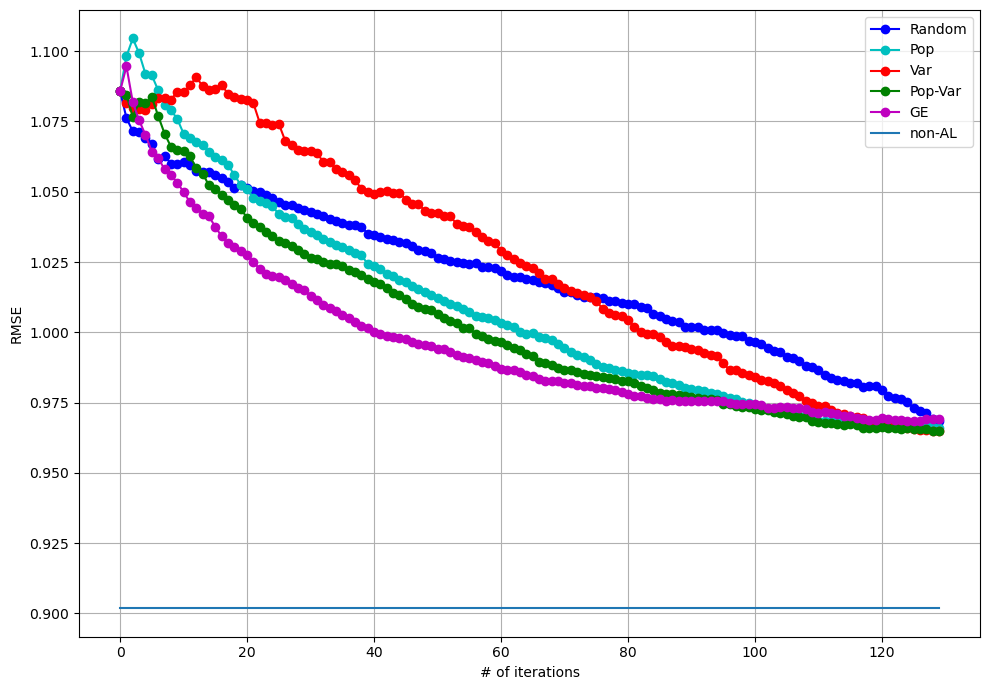

In [145]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

# y_axis = list(range(0, dataset.item_n, w))
# y_axis = list(range(0, results[i][1]['rmse']))


for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(list(range(0, len(results[i][1]['rmse']))), results[i][1]['rmse'], m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
    

ax.plot(list(range(0, len(results[0][1]['rmse']))), [fin_acc]*len(list(range(0, len(results[0][1]['rmse'])))),'-', label='non-AL')   
# ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all-tr')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('Non-personalized AL Strategies')

# plt.show()
plt.savefig('./outputs/rmse_exp3_iter4.png', dpi=300)

### RMSE difference

In [146]:
# results[0][1].keys()

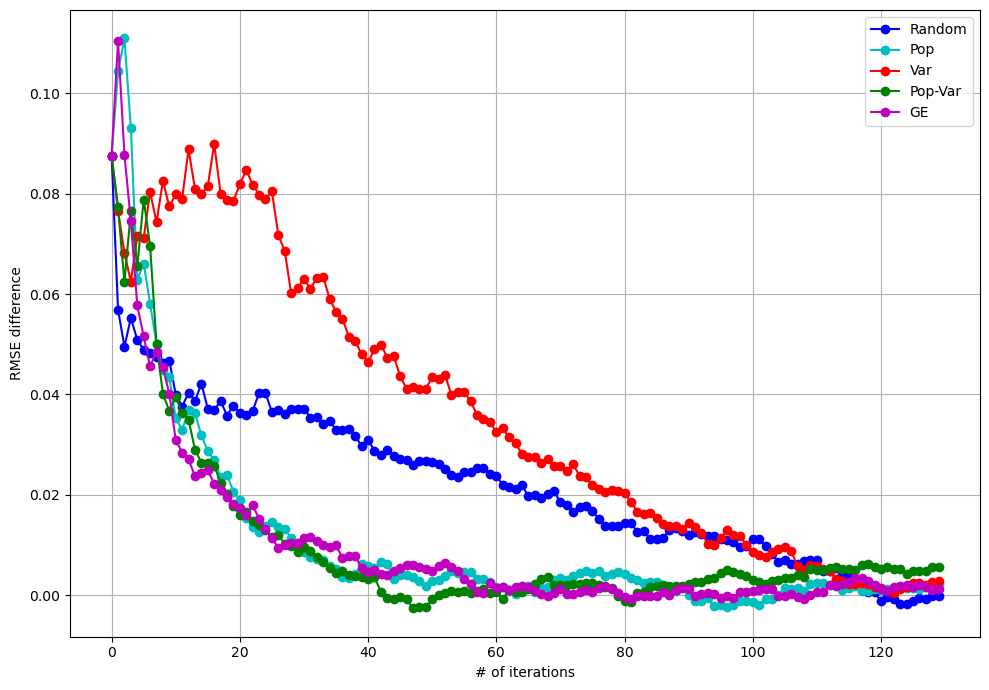

In [147]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(list(range(0, len(results[i][1]['rmse']))), rmse_diff, m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')

# plt.show()
plt.savefig('./outputs/rmse_diff_exp3_iter4.png', dpi=300)

### SEP RMSE

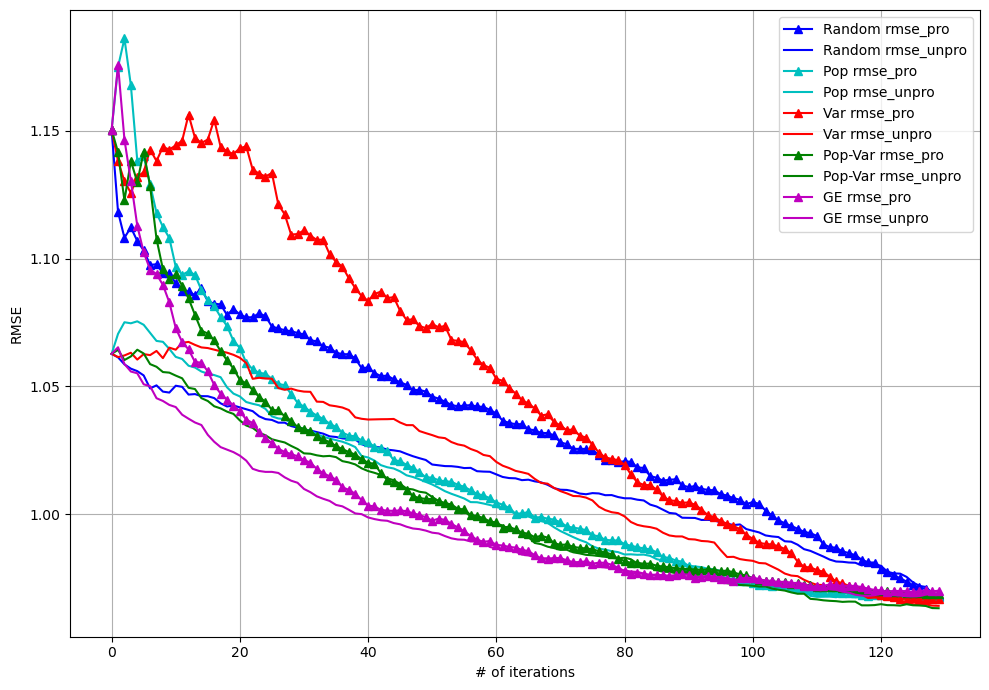

In [148]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))
list(range(0, len(results[i][1]['rmse'])))


for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['rmse_pro']))), results[i][1]['rmse_pro'], m+'^', label=label_d[results[i][0]]+' rmse_pro')
    ax.plot(list(range(0, len(results[i][1]['rmse_unpro']))), results[i][1]['rmse_unpro'], m, label=label_d[results[i][0]]+' rmse_unpro')
    # ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    # ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('RMSE Plors for Pro & Unpro')
# plt.show()
plt.savefig('./outputs/rmse_sep_exp3_iter4.png', dpi=300)

### pro/Unpro count

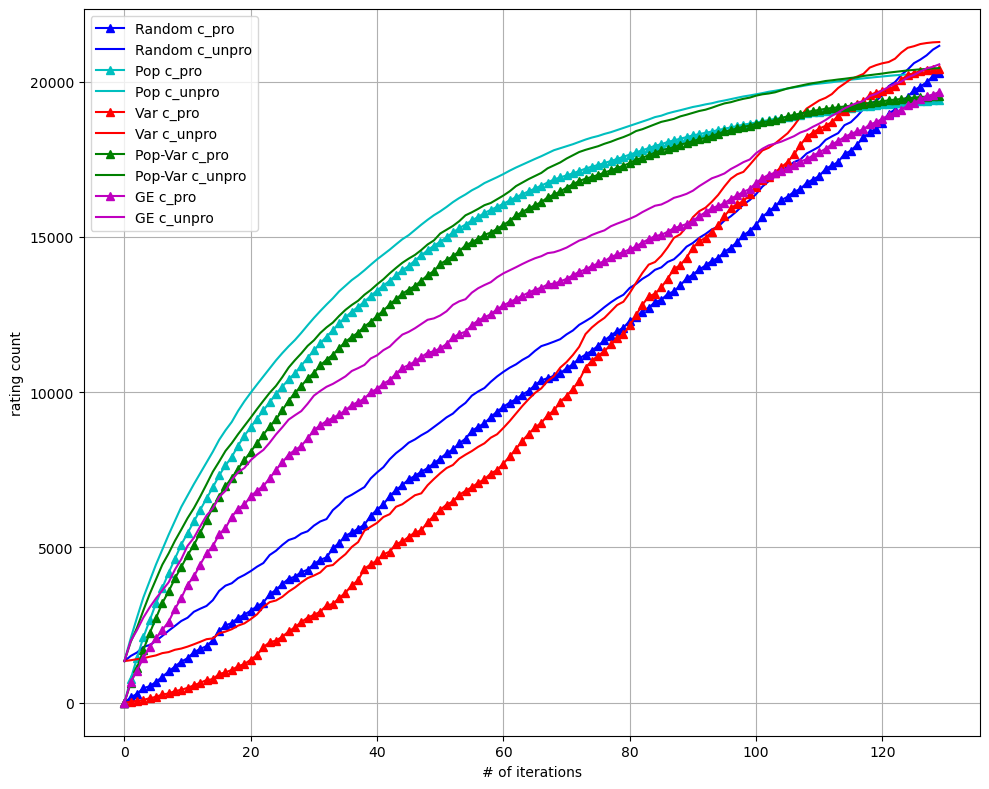

In [149]:
fig, ax = plt.subplots(figsize=(10, 8))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

# y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['c_pro']))), results[i][1]['c_pro'], m+'^', label=label_d[results[i][0]]+' c_pro')
    ax.plot(list(range(0, len(results[i][1]['c_unpro']))), results[i][1]['c_unpro'], m, label=label_d[results[i][0]]+' c_unpro')

    
#     ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
#     ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('rating count')
# plt.title('Pro & Unpro Counts')
# plt.show()
plt.savefig('./outputs/c_sep_exp3_iter4.png', dpi=300)

# 4. same ratio known_df / normal picking / normal test

In [150]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(tr_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        # if i_indx%100. == 0.:
        #     print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]

            # sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
            tr_iter = pd.concat([tr_iter, 
                                  tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()

        else:
            tr_iter = knw_df


        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])

        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    


################## main #######################


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}
    

    
    #------------------------ test set & algo & window ---------------------
    
    # the known set, a part of the training set
    # known_n = 0.02
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    
    initial_train_df_rat = initial_train_df[(initial_train_df['user']).isin(unpro_users_index + random.sample(unpro_users_index, len(pro_users_index)))]
    # known_df = initial_train_df
    known_df = initial_train_df_rat
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    w = 10   # window of w items    

    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=10)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))



while loop:  10%|█         | 130/1299 [05:50<52:33,  2.70s/it]  


Process Time: 350.79 secs


## save results

In [151]:
for a, b in results:
    print(a)
    pd.DataFrame.from_dict(b).to_csv('./outputs/%s_exp4_iter4.csv'%a,index=False)
    

ran
pop
var
popvar
ge


## plots

In [152]:
label_d = {'ran':'Random', 'var':'Var', 'pop':'Pop', 'popvar': 'Pop-Var', 'ge':'GE'}

### RMSE

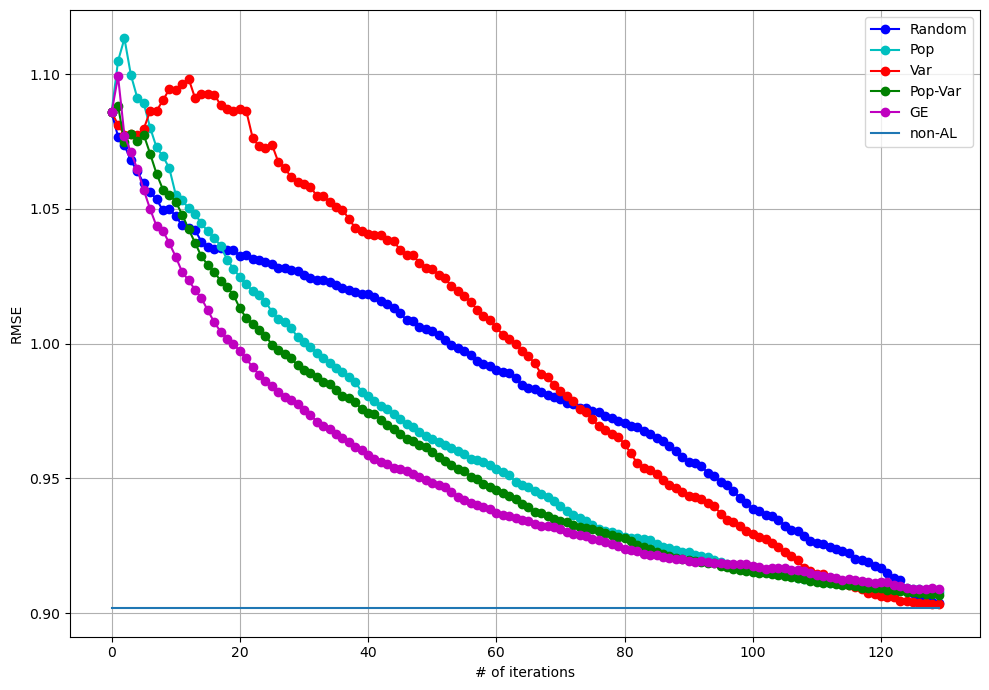

In [153]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

# y_axis = list(range(0, dataset.item_n, w))
# y_axis = list(range(0, results[i][1]['rmse']))


for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(list(range(0, len(results[i][1]['rmse']))), results[i][1]['rmse'], m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
    

ax.plot(list(range(0, len(results[0][1]['rmse']))), [fin_acc]*len(list(range(0, len(results[0][1]['rmse'])))),'-', label='non-AL')   
# ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all-tr')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('Non-personalized AL Strategies')

# plt.show()
plt.savefig('./outputs/rmse_exp4_iter4.png', dpi=300)

### RMSE difference

In [154]:
# results[0][1].keys()

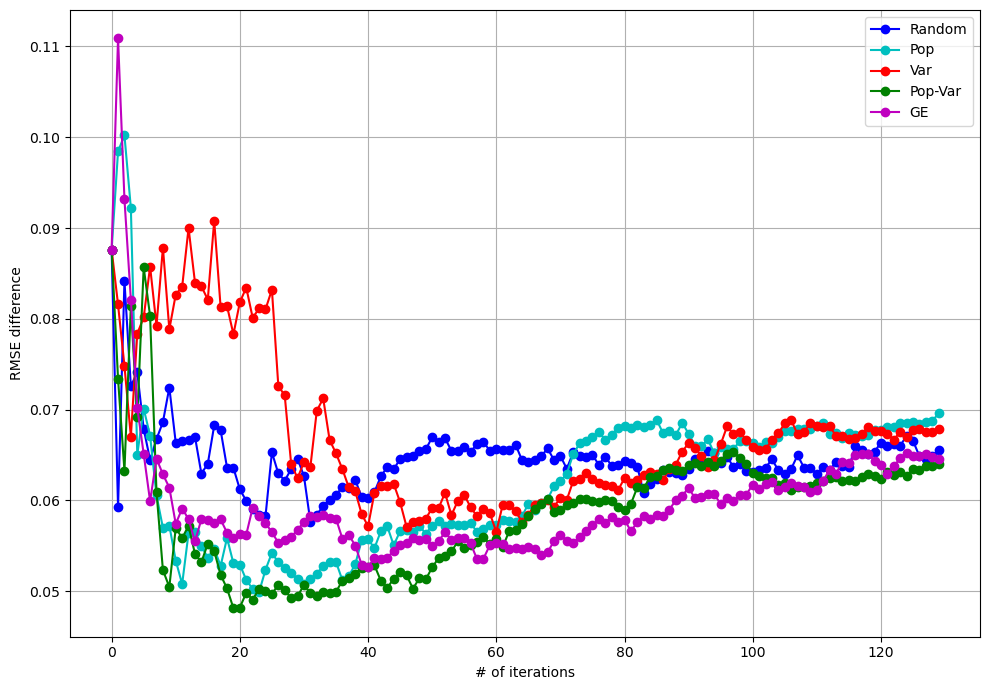

In [155]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(list(range(0, len(results[i][1]['rmse']))), rmse_diff, m, label=label_d[results[i][0]])
    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')

# plt.show()
plt.savefig('./outputs/rmse_diff_exp4_iter4.png', dpi=300)

### SEP RMSE

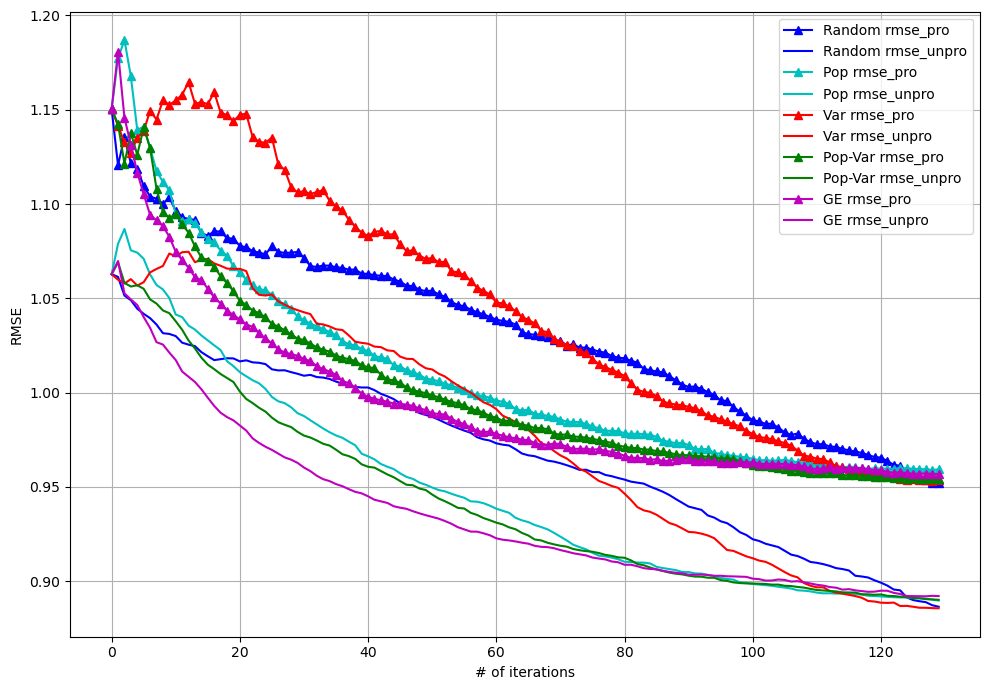

In [156]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))
list(range(0, len(results[i][1]['rmse'])))


for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['rmse_pro']))), results[i][1]['rmse_pro'], m+'^', label=label_d[results[i][0]]+' rmse_pro')
    ax.plot(list(range(0, len(results[i][1]['rmse_unpro']))), results[i][1]['rmse_unpro'], m, label=label_d[results[i][0]]+' rmse_unpro')
    # ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    # ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('RMSE Plors for Pro & Unpro')
# plt.show()
plt.savefig('./outputs/rmse_sep_exp4_iter4.png', dpi=300)

### pro/Unpro count

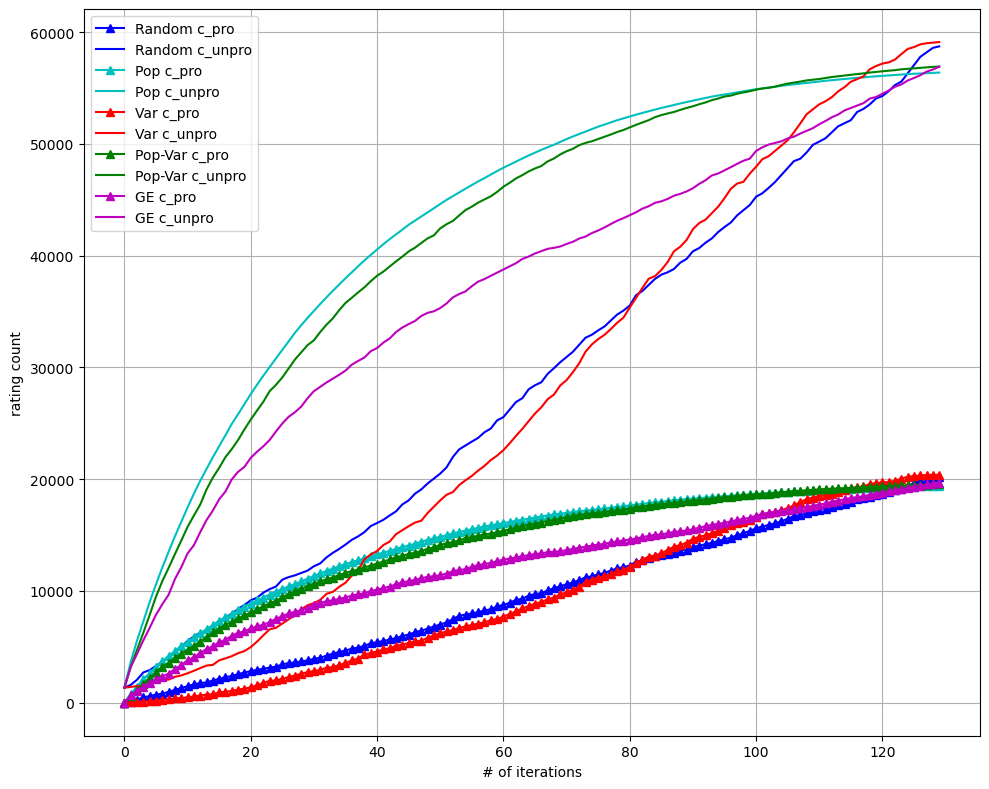

In [157]:
fig, ax = plt.subplots(figsize=(10, 8))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

# y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['c_pro']))), results[i][1]['c_pro'], m+'^', label=label_d[results[i][0]]+' c_pro')
    ax.plot(list(range(0, len(results[i][1]['c_unpro']))), results[i][1]['c_unpro'], m, label=label_d[results[i][0]]+' c_unpro')

    
#     ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
#     ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('rating count')
# plt.title('Pro & Unpro Counts')
# plt.show()
plt.savefig('./outputs/c_sep_exp4_iter4.png', dpi=300)

# 5. normal known_df / normal picking / same ratio testset 

In [220]:
# #---------------------------------------------
# from tqdm import tqdm


# def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
#     pro_c = []
#     unpro_c = []
    
#     rmse = []
#     rmse_pro = []
#     rmse_unpro = []
    
# #     vu = []
    
#     tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
#     # number of items
#     n_itm = np.unique(tr_df['item']).shape[0]
#     i_indx = 0

#     pbar = tqdm(desc='while loop', total=n_itm+1)
#     while i_indx < n_itm:

#         # if i_indx%100. == 0.:
#         #     print('sample %i-th item...' %i_indx)
    

#         if i_indx != 0:
#             # choosing the next item to sample
#             chosen_is = srt_it[i_indx:i_indx+win]

#             # sample based on item popularity but without replacement.
#             # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#             tr_iter = pd.concat([tr_iter, 
#                                   tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()

#         else:
#             tr_iter = knw_df


#         # turn the data into a Surprise readbale file
#         trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


#         # fitting to the model
#         algo.fit(trainset_act)
#         preds = algo.test(tes)

#         # evaluating the outcome
#         rmse.append(accuracy.rmse(preds, verbose=False))
#         # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


#         # pro & unpro RMSE
#         pro_, unpro_ = seperate_preds(preds)    
#         rmse_pro.append(accuracy.rmse(pro_, verbose=False))
#         rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


# #         # value fairness
# #         vu.append(value_unfairness(pd.DataFrame(preds)))


#         # pro/unpro count
#         pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
#         unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])

        
#         #----------------------------------next iteration---------------------------------
#         i_indx += win
#         pbar.update(1)
       
    
#     pbar.close()  
#     return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    


# ################## main #######################


# if __name__ == "__main__":
    
#     # edited train_df is sent here

#     def comp_paral (akey):
#         # strtgs[akey] is the sorted list of items based on a strategy
#         return(akey, ac_proc(train_df_ratio, known_df, testset, w, strtgs[akey], svd_sup))
#         # (tr_df, knw_df, tes, win, srt_it, algo)
     
#     start = timeit.default_timer()
#     import multiprocess as mp


#     #------------------------item lists (act sorted & rand shuffled)---------------------
#     # unique sorted items
#     # if you use set() or np.unique(), they will disorder the list!
#     sorted_i_pop = item_pop_df['item_iid'].tolist()

#     # suffled list of items
#     shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

#     # uncertainty - variance
#     sorted_i_v = item_uc_var_df['item_iid'].tolist()

#     # items order by their Sqrt(norm pop) * Var
#     sorted_i_spv = item_popvar_df['item_iid'].tolist()

#     # sorted based on their contribution to RMSE
#     sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

#     strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
#               'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}
    

    
#     #------------------------ test set & algo & window ---------------------
    
#     # the known set, a part of the training set
#     # known_n = 0.02
#     # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    
#     # initial_train_df_rat = initial_train_df[(initial_train_df['user']).isin(unpro_users_index + random.sample(unpro_users_index, len(pro_users_index)))]
#     # known_df = initial_train_df
#     known_df = initial_train_df
    
    
#     # chosen users
#     chu = unpro_users_index + random.sample(unpro_users_index, len(pro_users_index))
    
#     # build the test set
#     test_df_ratio = test_df[(test_df['user']).isin(chu)]
#     testset = Dataset.load_from_df(test_df_ratio[['user', 'item', 'rating']],
#                                    reader).build_full_trainset().build_testset()
    
    
#     # train df
#     train_df_ratio = train_df[(train_df['user']).isin(chu)]
    
    
#     svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
# #     algo = SVD()

#     w = 10   # window of w items    

    
#     #------------------------ function ---------------------
#     pool = mp.Pool(processes=10)
#     results = pool.map(comp_paral, list(strtgs.keys()))
# #     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
#     pool.close()
#     pool.join()
#     pool.terminate()
#     # print(results)

#     stop = timeit.default_timer()
#     print('Process Time: %.2f secs' % (stop - start))



# 6. same ratio known_df / same ratio picking / same ratio testset 

In [219]:
# #---------------------------------------------
# from tqdm import tqdm


# def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
#     pro_c = []
#     unpro_c = []
    
#     rmse = []
#     rmse_pro = []
#     rmse_unpro = []
    
# #     vu = []
    
#     tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
#     # number of items
#     n_itm = np.unique(tr_df['item']).shape[0]
#     i_indx = 0

#     pbar = tqdm(desc='while loop', total=n_itm+1)
#     while i_indx < n_itm:

#         if i_indx%100. == 0.:
#             print('sample %i-th item...' %i_indx)
    

#         if i_indx != 0:
#             # choosing the next item to sample
#             chosen_is = srt_it[i_indx:i_indx+win]
            
            
#             # filtering for equal proportions
#             chosen_df = tr_df[tr_df['item'].isin(chosen_is)]
            
#             pro_chosen_df = chosen_df[chosen_df['user'].isin(pro_users_index)]
            
#             p_c = pro_chosen_df.shape[0] # count of how many female ratings
            
#             # select as many male ratings as women's ratings
#             unpro_chosen_df = chosen_df[~chosen_df['user'].isin(pro_users_index)][:p_c]

            
#             print(p_c, unpro_chosen_df.shape[0])
            
            
#             tr_iter = pd.concat([tr_iter, 
#                                 pro_chosen_df,
#                                 unpro_chosen_df]).drop_duplicates()

#             # Sample based on item popularity but without replacement.
#             # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
# #             tr_iter = pd.concat([tr_iter, 
# #                                   tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()
        
#         else:
#             tr_iter = knw_df

 
            
#         # turn the data into a Surprise readbale file
#         trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


#         # fitting to the model
#         algo.fit(trainset_act)
#         preds = algo.test(tes)

#         # evaluating the outcome
#         rmse.append(accuracy.rmse(preds, verbose=False))
#         # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


#         # pro & unpro RMSE
#         pro_, unpro_ = seperate_preds(preds)
#         print(len(pro_), len(unpro_))
#         rmse_pro.append(accuracy.rmse(pro_, verbose=False))
#         rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


# #         # value fairness
# #         vu.append(value_unfairness(pd.DataFrame(preds)))


#         # pro/unpro count
#         pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
#         unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])
        
        
#         #----------------------------------next iteration---------------------------------
#         i_indx += win
#         pbar.update(1)
       
    
#     pbar.close()  
#     return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    
    


# if __name__ == "__main__":

#     def comp_paral (akey):
#         # strtgs[akey] is the sorted list of items based on a strategy
#         return(akey, ac_proc(train_df_ratio, known_df, testset, w, strtgs[akey], svd_sup))
#         # (tr_df, knw_df, tes, win, srt_it, algo)
     
#     start = timeit.default_timer()
#     import multiprocess as mp


#     #------------------------item lists (act sorted & rand shuffled)---------------------
#     # unique sorted items
#     # if you use set() or np.unique(), they will disorder the list!
#     sorted_i_pop = item_pop_df['item_iid'].tolist()

#     # suffled list of items
#     shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

#     # uncertainty - variance
#     sorted_i_v = item_uc_var_df['item_iid'].tolist()

#     # items order by their Sqrt(norm pop) * Var
#     sorted_i_spv = item_popvar_df['item_iid'].tolist()

#     # sorted based on their contribution to RMSE
#     sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

#     strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
#               'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}

# #     strtgs = {'ran':shuffled_i_ran}
    

    
#     #------------------------ test set & algo & window ---------------------
#     # the known set, a part of the training set
#     # known_n = 0.02
#     # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
# #     known_df = initial_train_df
    
    
# #     # build the test set
# #     testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
# #                                    reader).build_full_trainset().build_testset()


#      # chosen users
#     chu = unpro_users_index + random.sample(unpro_users_index, len(pro_users_index))
    
    
#     # initial_train_df_rat = initial_train_df[(initial_train_df['user']).isin(unpro_users_index + random.sample(unpro_users_index, len(pro_users_index)))]
#     initial_train_df_rat = initial_train_df[(initial_train_df['user']).isin(chu)]
#     # known_df = initial_train_df
#     known_df = initial_train_df_rat
    
    
   
    
#     # build the test set
#     test_df_ratio = test_df[(test_df['user']).isin(chu)]
#     # test_df_ratio = test_df[(test_df['user']).isin(unpro_users_index + random.sample(unpro_users_index, len(pro_users_index)))]
#     testset = Dataset.load_from_df(test_df_ratio[['user', 'item', 'rating']],
#                                    reader).build_full_trainset().build_testset()
    
    
#     # train df
#     train_df_ratio = train_df[(train_df['user']).isin(chu)]
    
    
#     svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
# #     algo = SVD()

#     w = 10   # window of w items
    
    
#     #------------------------ function ---------------------
#     pool = mp.Pool(processes=1)
#     results = pool.map(comp_paral, list(strtgs.keys()))
# #     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
#     pool.close()
#     pool.join()
#     pool.terminate()
#     # print(results)

#     stop = timeit.default_timer()
#     print('Process Time: %.2f secs' % (stop - start))
